In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet
import emsim_utils

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

import cv2

from unet import UNet
import scipy.optimize as optimize
from scipy.optimize import curve_fit

## Write events to a DataFrame

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/pixelated_tracks_K2_5um_front_3M_100keV.txt"

In [ ]:
# Read a new dataset.
df = emsim_utils.read_electron_data(datfile,nevts=200005)
df.to_pickle("EM_5um_front_3M_100keV.pkl")

# Generate random multi-electron events

In [11]:
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

Created dataset for events from 0 to 198917


In [12]:
frameset  = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0, lside = 0)
#frameset = tr.EMFrameDataset(dset,frame_size=4855,nelec_mean=103713,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=88,nelec_sigma=2,noise_mean=0,noise_sigma=20)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=10,nelec_sigma=1,noise_mean=0,noise_sigma=20)

##### Generate many frames and fit

In [13]:
def fit_line(fit_img, th = 0.5, pct_rng = 0.2, nbins_hdist = 40):
    
    A = fit_img/np.max(fit_img)
    nrows = A.shape[0]
    ncols = A.shape[1]
    ncts = np.sum(A[A >= th])
    nzeros = np.sum(1-A[A < th])
    wcts = 1.0 #nzeros/ncts
    indices = np.indices((nrows,ncols))
    irows = indices[0]
    icols = indices[1]
    print("nzeros = {}, ncts = {}, wcts = {}".format(nzeros,ncts,wcts))

    def count_loss(x):
        m,b = x

        # The loss L is:
        #
        # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
        # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
        # 
        # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
        # the number of zeros.
        L = 0
        L1 = np.sum(1-A[(irows < m*icols + b) & (A < th)])
        L2 = np.sum(A[(irows < m*icols + b) & (A >= th)])
        L3 = np.sum(A[(irows >= m*icols + b) & (A >= th)])
        L4 = np.sum(1-A[(irows >= m*icols + b) & (A < th)])

        L = L1 - wcts*L2 + wcts*L3 - L4
        #print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
        return -L
    
    initial_guess = [-1.5*nrows/ncols,2*nrows]
    result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-5)
    m,b = result.x
    Lmin = result.fun
    print("m = ",m,"b = ",b,"Lmin=",Lmin)
    
    # Get the loss over a range of the parameters.
    mrng = np.arange(m-pct_rng*m, m+pct_rng*m, 2*pct_rng*m/1000)
    Lrng_m = np.array([count_loss([mval,b])/Lmin for mval in mrng])
    brng = np.arange(b-pct_rng*b, b+pct_rng*b, 2*pct_rng*b/1000)
    Lrng_b = np.array([count_loss([m,bval])/Lmin for bval in brng])
    
    # Get the histogram of mean value vs. distance.
    dist = (m*icols - irows + b) / (m**2 + 1)                          # compute distance to line for each point
    hw, bb = np.histogram(dist.flatten(),weights=A.flatten(),bins=nbins_hdist)  # weighted histogram
    hh, bb = np.histogram(dist.flatten(),bins=nbins_hdist)                      # unweighted (for normalization)
    hh[hh == 0] = 0.1
    hfinal = hw / hh                                                   # normalize the histogram
    bcenters = (bb[1:] + bb[:-1]) / 2                                  # determine the bin centers
    
    return m,b,Lmin,mrng,Lrng_m,brng,Lrng_b,hfinal,bcenters

In [14]:
# Create some number of events and count them.
th_unet = 0.7
th_classical = 825
evts = np.arange(0,10000)
l_frames, l_labels, l_ct_unet, l_ct_classical = [], [], [], []
for evt in evts:
    frame,label = frameset[evt]
    label = label[0]
    
    # Send through the model.
    data = torch.tensor(frame).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    ct_unet = (prob > th_unet)
    
    # Count with a single threshold.
    #ct_classical = (frame > th_classical)
    ct_classical = np.zeros(frame.shape)
    ct_classical[np.unravel_index(np.argmax(frame),frame.shape)] = 1
    
    l_frames.append(frame)
    l_labels.append(label)
    l_ct_unet.append(ct_unet)
    l_ct_classical.append(ct_classical)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
            
l_frames = np.array(l_frames)
l_labels = np.array(l_labels)
l_ct_unet = np.array(l_ct_unet)
l_ct_classical = np.array(l_ct_classical)

# Create a summed frame, label, and count arrays.
frame = np.sum(l_frames,axis=0)
label = np.sum(l_labels,axis=0)
ct_unet = np.sum(l_ct_unet,axis=0)
ct_classical = np.sum(l_ct_classical,axis=0)

0% done
1% done
2% done
3% done
4% done
5% done
6% done
7% done
8% done
9% done
10% done
11% done
12% done
13% done
14% done
15% done
16% done
17% done
18% done
19% done
20% done
21% done
22% done
23% done
24% done
25% done
26% done
27% done
28% done
29% done
30% done
31% done
32% done
33% done
34% done
35% done
36% done
37% done
38% done
39% done
40% done
41% done
42% done
43% done
44% done
45% done
46% done
47% done
48% done
49% done
50% done
51% done
52% done
53% done
54% done
55% done
56% done
57% done
58% done
59% done
60% done
61% done
62% done
63% done
64% done
65% done
66% done
67% done
68% done
69% done
70% done
71% done
72% done
73% done
74% done
75% done
76% done
77% done
78% done
79% done
80% done
81% done
82% done
83% done
84% done
85% done
86% done
87% done
88% done
89% done
90% done
91% done
92% done
93% done
94% done
95% done
96% done
97% done
98% done
99% done


In [15]:
raw_th = 0.992
ct_th = 0.4
m_frame,b_frame,Lmin_frame,mrng_frame,Lrng_m_frame,brng_frame,Lrng_b_frame,hdist_frame,bcenters_frame = fit_line(frame,th=raw_th)
m_label,b_label,Lmin_label,mrng_label,Lrng_m_label,brng_label,Lrng_b_label,hdist_label,bcenters_label = fit_line(label,th=ct_th)
m_unet,b_unet,Lmin_unet,mrng_unet,Lrng_m_unet,brng_unet,Lrng_b_unet,hdist_unet,bcenters_unet = fit_line(ct_unet,th=ct_th)
m_classical,b_classical,Lmin_classical,mrng_classical,Lrng_m_classical,brng_classical,Lrng_b_classical,hdist_classical,bcenters_classical = fit_line(ct_classical,th=ct_th)

nzeros = 3.4195121927159, ncts = 173.2943585703273, wcts = 1.0
m =  -1.9134246826171906 b =  28.9091796875 Lmin= -176.47944690542096
nzeros = 210.0, ncts = 140.8450704225352, wcts = 1.0
m =  -1.9345733642578153 b =  28.7001953125 Lmin= -350.8450704225352
nzeros = 204.56338028169014, ncts = 131.8450704225352, wcts = 1.0
m =  -1.9345733642578153 b =  28.7001953125 Lmin= -336.40845070422534
nzeros = 204.72727272727272, ncts = 124.5974025974026, wcts = 1.0
m =  -1.937805175781253 b =  28.76953125 Lmin= -329.32467532467535


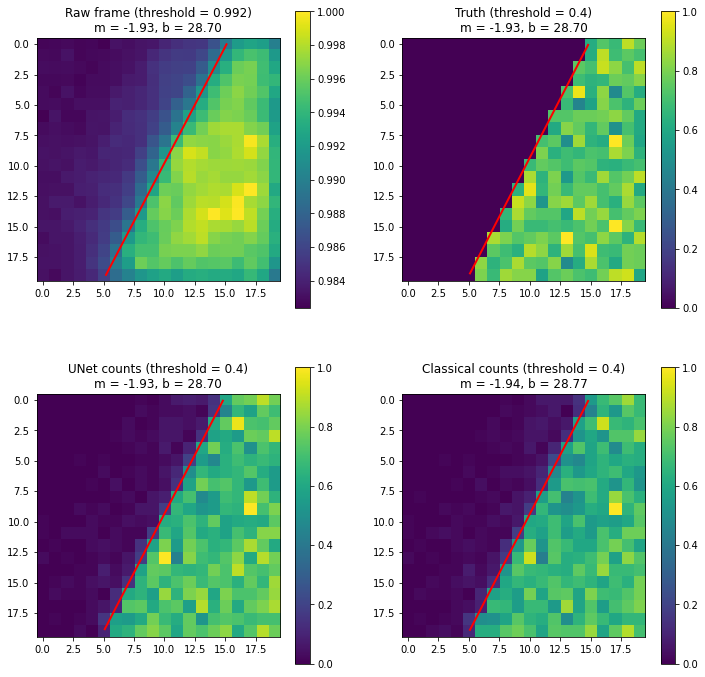

In [16]:
#frame,label = frameset[0]
logscale = False
nrows = frame.shape[0]
ncols = frame.shape[1]

fig = plt.figure()
fig.set_figheight(12.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(221)
if(logscale):
    plt.imshow(np.log(frame))
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    plt.title("Raw frame (log counts, threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_label,b_label))
else:
    plt.imshow(frame/np.max(frame))
    cbar = plt.colorbar()
    plt.title("Raw frame (threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_label,b_label))
xfit = np.arange(0,ncols-1,0.1)
yfit = m_frame*xfit + b_frame
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax2 = fig.add_subplot(222)
plt.imshow(label/np.max(label))
plt.title("Truth (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_label,b_label))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_label*xfit + b_label
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax3 = fig.add_subplot(223)
plt.imshow(ct_unet/np.max(ct_unet))
plt.title("UNet counts (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_unet,b_unet))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_unet*xfit + b_unet
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax4 = fig.add_subplot(224)
plt.imshow(ct_classical/np.max(ct_classical))
plt.title("Classical counts (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_classical,b_classical))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_classical*xfit + b_classical
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

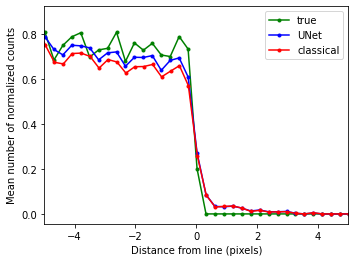

In [17]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
#plt.plot(bcenters_frame,hdist_frame,color='black',label='frame')
plt.plot(bcenters_label,hdist_label,'.-',color='green',label='true')
plt.plot(bcenters_unet,hdist_unet,'.-',color='blue',label='UNet')
plt.plot(bcenters_classical,hdist_classical,'.-',color='red',label='classical')
plt.xlim([-5,5])
plt.xlabel("Distance from line (pixels)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
plt.plot(mrng_frame/m_frame,Lrng_m_frame,color='black',label='frame')
plt.plot(mrng_label/m_label,Lrng_m_label,color='green',label='true')
plt.plot(mrng_unet/m_unet,Lrng_m_unet,color='blue',label='UNet')
plt.plot(mrng_classical/m_classical,Lrng_m_classical,color='red',label='classical')
plt.xlabel("Parameter m/m$_0$")
plt.ylabel("Relative loss L/L(m$_0$)")
plt.legend()

ax2 = fig.add_subplot(122)
plt.plot(brng_frame/b_frame,Lrng_b_frame,color='black',label='frame')
plt.plot(brng_label/b_label,Lrng_b_label,color='green',label='true')
plt.plot(brng_unet/b_unet,Lrng_b_unet,color='blue',label='UNet')
plt.plot(brng_classical/b_classical,Lrng_b_classical,color='red',label='classical')
plt.xlabel("Parameter b/b$_0$")
plt.ylabel("Relative loss L/L(b$_0$)")
plt.legend()

In [ ]:
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

##### Examine a large generated frame

In [ ]:
plt.imshow(label[0,0:50,0:50])
plt.colorbar()

In [ ]:
img_sim = frame.flatten()

In [ ]:
#plt.hist(img_sim[(img_sim < 400)],bins=50)
plt.hist(img_sim,bins=50)
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
print("Total pixels:",len(img_sim))
#plt.xlim([0,500])

In [ ]:
np.savez("frame_4855x4855_11occ.npz",frame=frame)

## Train a network (multi-electron)

In [2]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-4   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 500    # Number of final epoch
model_load_checkpoint = "{}/model_frames_20x20_noise683_2e_bcsloss_edge_weighted_front_1em4_100kev_499.pt".format(modeldir)

# Create the dataset.
# 576x576: 2927 +/- 71
# 100x100: 88 +/- 2
# 50x50: 22 +/- 0.5
#dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

# "Real-data-like" dataset: occupancy 11, noise_mean=683, noise_sigma=11.2
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
dataset_train = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_unet, num_workers=8)

# Define the model.
model = UNet(n_channels=1, n_classes=1)
model.cuda()

optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if model.n_classes > 1 else 'max', patience=2)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

Created dataset for events from 0 to 198917


In [3]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train_unet(model, epoch, train_loader, optimizer)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

Epoch:  0


/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [0/1000 (0%)]	Loss: 236.364044	 score_max: 0.996141	 score_min: -5.618519; Accuracy 0.997
Train Epoch: 0 [50/1000 (5%)]	Loss: 223.868790	 score_max: 1.480430	 score_min: -5.187538; Accuracy 0.997
Train Epoch: 0 [100/1000 (10%)]	Loss: 213.293839	 score_max: 2.246847	 score_min: -1.839697; Accuracy 0.996
Train Epoch: 0 [150/1000 (15%)]	Loss: 204.438782	 score_max: 3.834100	 score_min: -3.494267; Accuracy 0.996
Train Epoch: 0 [200/1000 (20%)]	Loss: 197.594788	 score_max: 1.880139	 score_min: -1.368839; Accuracy 0.996
Train Epoch: 0 [250/1000 (25%)]	Loss: 188.882034	 score_max: 2.930870	 score_min: -3.120150; Accuracy 0.997
Train Epoch: 0 [300/1000 (30%)]	Loss: 180.877060	 score_max: 2.032013	 score_min: -3.176257; Accuracy 0.996
Train Epoch: 0 [350/1000 (35%)]	Loss: 172.931671	 score_max: 1.002536	 score_min: -1.500070; Accuracy 0.997
Train Epoch: 0 [400/1000 (40%)]	Loss: 166.039398	 score_max: 0.927740	 score_min: -2.478176; Accuracy 0.997
Train Epoch: 0 [450/1000 (45%)]	L

Train Epoch: 3 [800/1000 (80%)]	Loss: 36.387623	 score_max: -0.624015	 score_min: -3.050559; Accuracy 0.998
Train Epoch: 3 [850/1000 (85%)]	Loss: 35.781273	 score_max: 0.032918	 score_min: -4.138508; Accuracy 0.998
Train Epoch: 3 [900/1000 (90%)]	Loss: 35.172894	 score_max: 0.137375	 score_min: -3.654600; Accuracy 0.998
Train Epoch: 3 [950/1000 (95%)]	Loss: 34.437038	 score_max: 0.254073	 score_min: -3.810606; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 41.40286655426026 ACCURACY: 0.9975000023841858
Epoch:  4
Train Epoch: 4 [0/1000 (0%)]	Loss: 33.930058	 score_max: 0.125798	 score_min: -4.631122; Accuracy 0.998
Train Epoch: 4 [50/1000 (5%)]	Loss: 33.334606	 score_max: 0.859100	 score_min: -7.947246; Accuracy 0.998
Train Epoch: 4 [100/1000 (10%)]	Loss: 32.582500	 score_max: 0.132545	 score_min: -4.499324; Accuracy 0.998
Train Epoch: 4 [150/1000 (15%)]	Loss: 32.107891	 score_max: 0.032223	 score_min: -4.453131; Accuracy 0.998
Train Epoch: 4 [200/1000 (20%)]	Loss: 31.571806	 score_max: 0.3695

Train Epoch: 7 [800/1000 (80%)]	Loss: 8.791509	 score_max: -0.038313	 score_min: -7.372860; Accuracy 0.998
Train Epoch: 7 [850/1000 (85%)]	Loss: 8.724950	 score_max: -0.039451	 score_min: -9.556116; Accuracy 0.998
Train Epoch: 7 [900/1000 (90%)]	Loss: 8.535094	 score_max: -0.040587	 score_min: -7.652727; Accuracy 0.998
Train Epoch: 7 [950/1000 (95%)]	Loss: 8.550874	 score_max: -0.041722	 score_min: -15.049690; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 9.975485372543336 ACCURACY: 0.9975000023841858
Epoch:  8
Train Epoch: 8 [0/1000 (0%)]	Loss: 8.315653	 score_max: -0.042854	 score_min: -6.942356; Accuracy 0.998
Train Epoch: 8 [50/1000 (5%)]	Loss: 8.078408	 score_max: -0.043986	 score_min: -8.400519; Accuracy 0.998
Train Epoch: 8 [100/1000 (10%)]	Loss: 8.129893	 score_max: -0.045115	 score_min: -10.137761; Accuracy 0.998
Train Epoch: 8 [150/1000 (15%)]	Loss: 8.014428	 score_max: -0.046244	 score_min: -7.739253; Accuracy 0.998
Train Epoch: 8 [200/1000 (20%)]	Loss: 7.649895	 score_max: -0.047

Train Epoch: 11 [800/1000 (80%)]	Loss: 2.702019	 score_max: -0.125510	 score_min: -11.770575; Accuracy 0.998
Train Epoch: 11 [850/1000 (85%)]	Loss: 2.684693	 score_max: -0.126565	 score_min: -24.490530; Accuracy 0.998
Train Epoch: 11 [900/1000 (90%)]	Loss: 2.597042	 score_max: -0.127620	 score_min: -16.982986; Accuracy 0.998
Train Epoch: 11 [950/1000 (95%)]	Loss: 2.657969	 score_max: -0.128674	 score_min: -13.543658; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 2.9331271648406982 ACCURACY: 0.9975000023841858
Epoch:  12
Train Epoch: 12 [0/1000 (0%)]	Loss: 2.469085	 score_max: -0.129727	 score_min: -13.355057; Accuracy 0.998
Train Epoch: 12 [50/1000 (5%)]	Loss: 2.638286	 score_max: -0.130780	 score_min: -14.713037; Accuracy 0.998
Train Epoch: 12 [100/1000 (10%)]	Loss: 2.486071	 score_max: -0.131832	 score_min: -13.669268; Accuracy 0.998
Train Epoch: 12 [150/1000 (15%)]	Loss: 2.611825	 score_max: -0.132884	 score_min: -13.242653; Accuracy 0.998
Train Epoch: 12 [200/1000 (20%)]	Loss: 2.362072	 

Train Epoch: 15 [800/1000 (80%)]	Loss: 1.362175	 score_max: -0.187184	 score_min: -21.873743; Accuracy 0.998
Train Epoch: 15 [850/1000 (85%)]	Loss: 1.348075	 score_max: -0.186531	 score_min: -22.648798; Accuracy 0.998
Train Epoch: 15 [900/1000 (90%)]	Loss: 1.233341	 score_max: -0.185834	 score_min: -24.873409; Accuracy 0.998
Train Epoch: 15 [950/1000 (95%)]	Loss: 1.325071	 score_max: -0.185098	 score_min: -19.553129; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 1.3854109585285186 ACCURACY: 0.9975000023841858
Epoch:  16
Train Epoch: 16 [0/1000 (0%)]	Loss: 1.258039	 score_max: -0.184327	 score_min: -36.372814; Accuracy 0.998
Train Epoch: 16 [50/1000 (5%)]	Loss: 1.257195	 score_max: -0.183524	 score_min: -20.898632; Accuracy 0.998
Train Epoch: 16 [100/1000 (10%)]	Loss: 1.254166	 score_max: -0.182693	 score_min: -20.393326; Accuracy 0.998
Train Epoch: 16 [150/1000 (15%)]	Loss: 1.246284	 score_max: -0.181837	 score_min: -22.906389; Accuracy 0.998
Train Epoch: 16 [200/1000 (20%)]	Loss: 1.291552	 

Train Epoch: 19 [450/1000 (45%)]	Loss: 1.017023	 score_max: -0.113615	 score_min: -26.612423; Accuracy 0.998
Train Epoch: 19 [500/1000 (50%)]	Loss: 1.126890	 score_max: -0.112571	 score_min: -32.933739; Accuracy 0.998
Train Epoch: 19 [550/1000 (55%)]	Loss: 1.113442	 score_max: -0.111527	 score_min: -40.666210; Accuracy 0.998
Train Epoch: 19 [600/1000 (60%)]	Loss: 1.012936	 score_max: -0.110483	 score_min: -32.683861; Accuracy 0.998
Train Epoch: 19 [650/1000 (65%)]	Loss: 1.058204	 score_max: -0.109440	 score_min: -19.057400; Accuracy 0.998
Train Epoch: 19 [700/1000 (70%)]	Loss: 1.002263	 score_max: -0.108397	 score_min: -27.857029; Accuracy 0.998
Train Epoch: 19 [750/1000 (75%)]	Loss: 0.994122	 score_max: -0.107355	 score_min: -36.651520; Accuracy 0.998
Train Epoch: 19 [800/1000 (80%)]	Loss: 1.001756	 score_max: -0.106313	 score_min: -25.056574; Accuracy 0.998
Train Epoch: 19 [850/1000 (85%)]	Loss: 1.023620	 score_max: -0.105271	 score_min: -19.052811; Accuracy 0.998
Train Epoch: 19 [90

Train Epoch: 23 [100/1000 (10%)]	Loss: 0.959743	 score_max: -0.038330	 score_min: -38.391281; Accuracy 0.998
Train Epoch: 23 [150/1000 (15%)]	Loss: 0.972391	 score_max: -0.037309	 score_min: -37.361649; Accuracy 0.998
Train Epoch: 23 [200/1000 (20%)]	Loss: 0.886988	 score_max: -0.036288	 score_min: -26.637133; Accuracy 0.998
Train Epoch: 23 [250/1000 (25%)]	Loss: 1.079564	 score_max: -0.035268	 score_min: -26.784159; Accuracy 0.998
Train Epoch: 23 [300/1000 (30%)]	Loss: 0.907031	 score_max: -0.034248	 score_min: -25.163548; Accuracy 0.998
Train Epoch: 23 [350/1000 (35%)]	Loss: 0.945241	 score_max: -0.033228	 score_min: -26.545532; Accuracy 0.998
Train Epoch: 23 [400/1000 (40%)]	Loss: 0.949624	 score_max: -0.032208	 score_min: -30.614023; Accuracy 0.998
Train Epoch: 23 [450/1000 (45%)]	Loss: 0.930925	 score_max: -0.031189	 score_min: -26.518747; Accuracy 0.998
Train Epoch: 23 [500/1000 (50%)]	Loss: 0.908332	 score_max: -0.030170	 score_min: -29.383974; Accuracy 0.998
Train Epoch: 23 [55

Train Epoch: 26 [800/1000 (80%)]	Loss: 0.945709	 score_max: 0.036750	 score_min: -44.517094; Accuracy 0.998
Train Epoch: 26 [850/1000 (85%)]	Loss: 0.851233	 score_max: 0.037760	 score_min: -40.741356; Accuracy 0.998
Train Epoch: 26 [900/1000 (90%)]	Loss: 0.855836	 score_max: 0.038770	 score_min: -30.133814; Accuracy 0.998
Train Epoch: 26 [950/1000 (95%)]	Loss: 0.827868	 score_max: 0.039779	 score_min: -63.933758; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.8906146138906479 ACCURACY: 0.9975000023841858
Epoch:  27
Train Epoch: 27 [0/1000 (0%)]	Loss: 0.868669	 score_max: 0.040789	 score_min: -36.069855; Accuracy 0.998
Train Epoch: 27 [50/1000 (5%)]	Loss: 0.928930	 score_max: 0.041798	 score_min: -56.456272; Accuracy 0.998
Train Epoch: 27 [100/1000 (10%)]	Loss: 0.886784	 score_max: 0.042807	 score_min: -32.427059; Accuracy 0.998
Train Epoch: 27 [150/1000 (15%)]	Loss: 0.866295	 score_max: 0.043816	 score_min: -50.745438; Accuracy 0.998
Train Epoch: 27 [200/1000 (20%)]	Loss: 0.947452	 score_ma

Train Epoch: 30 [550/1000 (55%)]	Loss: 0.848713	 score_max: 0.112262	 score_min: -53.603886; Accuracy 0.998
Train Epoch: 30 [600/1000 (60%)]	Loss: 0.842375	 score_max: 0.113267	 score_min: -72.866341; Accuracy 0.998
Train Epoch: 30 [650/1000 (65%)]	Loss: 0.751891	 score_max: 0.114271	 score_min: -49.347363; Accuracy 0.998
Train Epoch: 30 [700/1000 (70%)]	Loss: 0.869848	 score_max: 0.115276	 score_min: -51.487652; Accuracy 0.998
Train Epoch: 30 [750/1000 (75%)]	Loss: 0.815846	 score_max: 0.116280	 score_min: -37.124802; Accuracy 0.998
Train Epoch: 30 [800/1000 (80%)]	Loss: 0.800921	 score_max: 0.117285	 score_min: -33.815819; Accuracy 0.998
Train Epoch: 30 [850/1000 (85%)]	Loss: 0.862957	 score_max: 0.118289	 score_min: -104.217331; Accuracy 0.998
Train Epoch: 30 [900/1000 (90%)]	Loss: 0.790817	 score_max: 0.119293	 score_min: -43.514282; Accuracy 0.998
Train Epoch: 30 [950/1000 (95%)]	Loss: 0.980171	 score_max: 0.120297	 score_min: -59.322731; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.

Train Epoch: 34 [250/1000 (25%)]	Loss: 0.744772	 score_max: 0.186500	 score_min: -57.382698; Accuracy 0.998
Train Epoch: 34 [300/1000 (30%)]	Loss: 0.715610	 score_max: 0.187502	 score_min: -58.591778; Accuracy 0.998
Train Epoch: 34 [350/1000 (35%)]	Loss: 0.812440	 score_max: 0.188504	 score_min: -65.779129; Accuracy 0.998
Train Epoch: 34 [400/1000 (40%)]	Loss: 0.797686	 score_max: 0.189506	 score_min: -29.893099; Accuracy 0.998
Train Epoch: 34 [450/1000 (45%)]	Loss: 0.860915	 score_max: 0.190508	 score_min: -130.558838; Accuracy 0.998
Train Epoch: 34 [500/1000 (50%)]	Loss: 0.736900	 score_max: 0.191510	 score_min: -50.688251; Accuracy 0.998
Train Epoch: 34 [550/1000 (55%)]	Loss: 0.735625	 score_max: 0.192512	 score_min: -67.554016; Accuracy 0.998
Train Epoch: 34 [600/1000 (60%)]	Loss: 0.829200	 score_max: 0.193514	 score_min: -92.092041; Accuracy 0.998
Train Epoch: 34 [650/1000 (65%)]	Loss: 0.811646	 score_max: 0.194516	 score_min: -81.555824; Accuracy 0.998
Train Epoch: 34 [700/1000 (

Train Epoch: 38 [0/1000 (0%)]	Loss: 0.748446	 score_max: 0.261613	 score_min: -80.467682; Accuracy 0.998
Train Epoch: 38 [50/1000 (5%)]	Loss: 0.810311	 score_max: 0.262614	 score_min: -90.809120; Accuracy 0.998
Train Epoch: 38 [100/1000 (10%)]	Loss: 0.700196	 score_max: 0.263615	 score_min: -55.059479; Accuracy 0.998
Train Epoch: 38 [150/1000 (15%)]	Loss: 0.662934	 score_max: 0.264616	 score_min: -50.647198; Accuracy 0.998
Train Epoch: 38 [200/1000 (20%)]	Loss: 0.692002	 score_max: 0.265617	 score_min: -79.456123; Accuracy 0.998
Train Epoch: 38 [250/1000 (25%)]	Loss: 0.738965	 score_max: 0.266618	 score_min: -57.900040; Accuracy 0.998
Train Epoch: 38 [300/1000 (30%)]	Loss: 0.781306	 score_max: 0.267619	 score_min: -78.303116; Accuracy 0.998
Train Epoch: 38 [350/1000 (35%)]	Loss: 0.658046	 score_max: 0.268620	 score_min: -72.473648; Accuracy 0.998
Train Epoch: 38 [400/1000 (40%)]	Loss: 0.680555	 score_max: 0.269621	 score_min: -56.195690; Accuracy 0.998
Train Epoch: 38 [450/1000 (45%)]	

Train Epoch: 41 [800/1000 (80%)]	Loss: 0.619710	 score_max: 0.337667	 score_min: -55.576958; Accuracy 0.998
Train Epoch: 41 [850/1000 (85%)]	Loss: 0.741426	 score_max: 0.338667	 score_min: -76.416649; Accuracy 0.998
Train Epoch: 41 [900/1000 (90%)]	Loss: 0.631381	 score_max: 0.339668	 score_min: -53.675518; Accuracy 0.998
Train Epoch: 41 [950/1000 (95%)]	Loss: 0.845141	 score_max: 0.340668	 score_min: -119.529526; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.696760305762291 ACCURACY: 0.9975000023841858
Epoch:  42
Train Epoch: 42 [0/1000 (0%)]	Loss: 0.773650	 score_max: 0.341669	 score_min: -137.373215; Accuracy 0.998
Train Epoch: 42 [50/1000 (5%)]	Loss: 0.667537	 score_max: 0.342669	 score_min: -127.695984; Accuracy 0.998
Train Epoch: 42 [100/1000 (10%)]	Loss: 0.864131	 score_max: 0.343670	 score_min: -76.188377; Accuracy 0.998
Train Epoch: 42 [150/1000 (15%)]	Loss: 0.689374	 score_max: 0.344670	 score_min: -64.849640; Accuracy 0.998
Train Epoch: 42 [200/1000 (20%)]	Loss: 0.767316	 score_

Train Epoch: 45 [550/1000 (55%)]	Loss: 0.754595	 score_max: 0.412692	 score_min: -54.856457; Accuracy 0.998
Train Epoch: 45 [600/1000 (60%)]	Loss: 0.605989	 score_max: 0.413692	 score_min: -65.389542; Accuracy 0.998
Train Epoch: 45 [650/1000 (65%)]	Loss: 0.685113	 score_max: 0.414692	 score_min: -56.897923; Accuracy 0.998
Train Epoch: 45 [700/1000 (70%)]	Loss: 0.630844	 score_max: 0.415692	 score_min: -68.403450; Accuracy 0.998
Train Epoch: 45 [750/1000 (75%)]	Loss: 0.610885	 score_max: 0.416693	 score_min: -147.317612; Accuracy 0.998
Train Epoch: 45 [800/1000 (80%)]	Loss: 0.839645	 score_max: 0.417693	 score_min: -211.772598; Accuracy 0.998
Train Epoch: 45 [850/1000 (85%)]	Loss: 0.694584	 score_max: 0.418693	 score_min: -98.515282; Accuracy 0.998
Train Epoch: 45 [900/1000 (90%)]	Loss: 0.578863	 score_max: 0.419693	 score_min: -36.119305; Accuracy 0.998
Train Epoch: 45 [950/1000 (95%)]	Loss: 0.671263	 score_max: 0.420694	 score_min: -120.622688; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 

Train Epoch: 49 [400/1000 (40%)]	Loss: 0.512249	 score_max: 0.489704	 score_min: -37.976406; Accuracy 0.998
Train Epoch: 49 [450/1000 (45%)]	Loss: 0.649631	 score_max: 0.490704	 score_min: -131.121338; Accuracy 0.998
Train Epoch: 49 [500/1000 (50%)]	Loss: 0.679723	 score_max: 0.491704	 score_min: -83.567284; Accuracy 0.998
Train Epoch: 49 [550/1000 (55%)]	Loss: 0.604226	 score_max: 0.492704	 score_min: -50.010353; Accuracy 0.998
Train Epoch: 49 [600/1000 (60%)]	Loss: 0.528901	 score_max: 0.493704	 score_min: -85.087479; Accuracy 0.998
Train Epoch: 49 [650/1000 (65%)]	Loss: 0.586272	 score_max: 0.494704	 score_min: -92.274239; Accuracy 0.998
Train Epoch: 49 [700/1000 (70%)]	Loss: 0.723131	 score_max: 0.495704	 score_min: -60.043449; Accuracy 0.998
Train Epoch: 49 [750/1000 (75%)]	Loss: 0.595225	 score_max: 0.496704	 score_min: -66.559921; Accuracy 0.998
Train Epoch: 49 [800/1000 (80%)]	Loss: 0.697627	 score_max: 0.497705	 score_min: -215.694382; Accuracy 0.998
Train Epoch: 49 [850/1000 

Train Epoch: 53 [400/1000 (40%)]	Loss: 0.519110	 score_max: 0.569709	 score_min: -89.591927; Accuracy 0.998
Train Epoch: 53 [450/1000 (45%)]	Loss: 0.492756	 score_max: 0.570709	 score_min: -90.712044; Accuracy 0.998
Train Epoch: 53 [500/1000 (50%)]	Loss: 0.791820	 score_max: 0.571709	 score_min: -185.433624; Accuracy 0.998
Train Epoch: 53 [550/1000 (55%)]	Loss: 0.771529	 score_max: 0.572709	 score_min: -126.979774; Accuracy 0.998
Train Epoch: 53 [600/1000 (60%)]	Loss: 0.543600	 score_max: 0.573709	 score_min: -144.735184; Accuracy 0.998
Train Epoch: 53 [650/1000 (65%)]	Loss: 0.520607	 score_max: 0.574709	 score_min: -110.401299; Accuracy 0.998
Train Epoch: 53 [700/1000 (70%)]	Loss: 0.586575	 score_max: 0.575709	 score_min: -153.488297; Accuracy 0.998
Train Epoch: 53 [750/1000 (75%)]	Loss: 0.511631	 score_max: 0.576709	 score_min: -94.780685; Accuracy 0.998
Train Epoch: 53 [800/1000 (80%)]	Loss: 0.711142	 score_max: 0.577709	 score_min: -246.891937; Accuracy 0.998
Train Epoch: 53 [850/1

Train Epoch: 57 [250/1000 (25%)]	Loss: 0.541711	 score_max: 0.646713	 score_min: -135.980972; Accuracy 0.998
Train Epoch: 57 [300/1000 (30%)]	Loss: 0.558074	 score_max: 0.647713	 score_min: -54.276035; Accuracy 0.998
Train Epoch: 57 [350/1000 (35%)]	Loss: 0.528488	 score_max: 0.648713	 score_min: -109.838730; Accuracy 0.998
Train Epoch: 57 [400/1000 (40%)]	Loss: 0.510325	 score_max: 0.649713	 score_min: -262.975769; Accuracy 0.998
Train Epoch: 57 [450/1000 (45%)]	Loss: 0.472788	 score_max: 0.650713	 score_min: -97.542343; Accuracy 0.998
Train Epoch: 57 [500/1000 (50%)]	Loss: 0.452249	 score_max: 0.651713	 score_min: -66.250221; Accuracy 0.998
Train Epoch: 57 [550/1000 (55%)]	Loss: 0.441938	 score_max: 0.652713	 score_min: -87.647659; Accuracy 0.998
Train Epoch: 57 [600/1000 (60%)]	Loss: 0.528355	 score_max: 0.653713	 score_min: -69.787804; Accuracy 0.998
Train Epoch: 57 [650/1000 (65%)]	Loss: 0.534457	 score_max: 0.654713	 score_min: -82.156151; Accuracy 0.998
Train Epoch: 57 [700/1000

Train Epoch: 61 [0/1000 (0%)]	Loss: 0.486328	 score_max: 0.721713	 score_min: -147.266037; Accuracy 0.998
Train Epoch: 61 [50/1000 (5%)]	Loss: 0.425127	 score_max: 0.722713	 score_min: -95.931686; Accuracy 0.998
Train Epoch: 61 [100/1000 (10%)]	Loss: 0.499648	 score_max: 0.723713	 score_min: -174.060120; Accuracy 0.998
Train Epoch: 61 [150/1000 (15%)]	Loss: 0.553704	 score_max: 0.724713	 score_min: -144.625092; Accuracy 0.998
Train Epoch: 61 [200/1000 (20%)]	Loss: 0.509448	 score_max: 0.725713	 score_min: -85.340965; Accuracy 0.998
Train Epoch: 61 [250/1000 (25%)]	Loss: 0.569348	 score_max: 0.726713	 score_min: -54.110832; Accuracy 0.998
Train Epoch: 61 [300/1000 (30%)]	Loss: 0.536227	 score_max: 0.727713	 score_min: -90.810257; Accuracy 0.998
Train Epoch: 61 [350/1000 (35%)]	Loss: 0.507580	 score_max: 0.728713	 score_min: -109.073967; Accuracy 0.998
Train Epoch: 61 [400/1000 (40%)]	Loss: 0.774526	 score_max: 0.729713	 score_min: -48.628048; Accuracy 0.998
Train Epoch: 61 [450/1000 (45

Train Epoch: 64 [800/1000 (80%)]	Loss: 0.593506	 score_max: 0.797712	 score_min: -163.831970; Accuracy 0.998
Train Epoch: 64 [850/1000 (85%)]	Loss: 0.505240	 score_max: 0.798712	 score_min: -78.472862; Accuracy 0.998
Train Epoch: 64 [900/1000 (90%)]	Loss: 0.580011	 score_max: 0.799712	 score_min: -54.300724; Accuracy 0.998
Train Epoch: 64 [950/1000 (95%)]	Loss: 0.462197	 score_max: 0.800712	 score_min: -141.192184; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.5186562895774841 ACCURACY: 0.9975000023841858
Epoch:  65
Train Epoch: 65 [0/1000 (0%)]	Loss: 0.406079	 score_max: 0.801712	 score_min: -75.270676; Accuracy 0.998
Train Epoch: 65 [50/1000 (5%)]	Loss: 0.553000	 score_max: 0.802712	 score_min: -75.575500; Accuracy 0.998
Train Epoch: 65 [100/1000 (10%)]	Loss: 0.529799	 score_max: 0.803712	 score_min: -253.493668; Accuracy 0.998
Train Epoch: 65 [150/1000 (15%)]	Loss: 0.441250	 score_max: 0.804712	 score_min: -155.559891; Accuracy 0.998
Train Epoch: 65 [200/1000 (20%)]	Loss: 0.544726	 scor

Train Epoch: 68 [450/1000 (45%)]	Loss: 0.411068	 score_max: 0.870711	 score_min: -102.521507; Accuracy 0.998
Train Epoch: 68 [500/1000 (50%)]	Loss: 0.475712	 score_max: 0.871711	 score_min: -112.734856; Accuracy 0.998
Train Epoch: 68 [550/1000 (55%)]	Loss: 0.433833	 score_max: 0.872711	 score_min: -98.567726; Accuracy 0.998
Train Epoch: 68 [600/1000 (60%)]	Loss: 0.403832	 score_max: 0.873711	 score_min: -56.758144; Accuracy 0.998
Train Epoch: 68 [650/1000 (65%)]	Loss: 0.547738	 score_max: 0.874711	 score_min: -120.562592; Accuracy 0.998
Train Epoch: 68 [700/1000 (70%)]	Loss: 0.622296	 score_max: 0.875711	 score_min: -208.290085; Accuracy 0.998
Train Epoch: 68 [750/1000 (75%)]	Loss: 0.595018	 score_max: 0.876711	 score_min: -58.904850; Accuracy 0.998
Train Epoch: 68 [800/1000 (80%)]	Loss: 0.381958	 score_max: 0.877711	 score_min: -114.988037; Accuracy 0.998
Train Epoch: 68 [850/1000 (85%)]	Loss: 0.452874	 score_max: 0.878711	 score_min: -85.623154; Accuracy 0.998
Train Epoch: 68 [900/10

Train Epoch: 72 [200/1000 (20%)]	Loss: 0.368350	 score_max: 0.945710	 score_min: -65.564034; Accuracy 0.998
Train Epoch: 72 [250/1000 (25%)]	Loss: 0.371330	 score_max: 0.946710	 score_min: -184.414093; Accuracy 0.998
Train Epoch: 72 [300/1000 (30%)]	Loss: 0.422972	 score_max: 0.947710	 score_min: -99.912422; Accuracy 0.998
Train Epoch: 72 [350/1000 (35%)]	Loss: 0.407107	 score_max: 0.948710	 score_min: -72.704544; Accuracy 0.997
Train Epoch: 72 [400/1000 (40%)]	Loss: 0.449869	 score_max: 0.949710	 score_min: -128.678909; Accuracy 0.998
Train Epoch: 72 [450/1000 (45%)]	Loss: 0.484922	 score_max: 0.950710	 score_min: -94.093216; Accuracy 0.998
Train Epoch: 72 [500/1000 (50%)]	Loss: 0.488181	 score_max: 0.951710	 score_min: -79.628494; Accuracy 0.998
Train Epoch: 72 [550/1000 (55%)]	Loss: 0.503774	 score_max: 0.952710	 score_min: -56.168194; Accuracy 0.998
Train Epoch: 72 [600/1000 (60%)]	Loss: 0.492061	 score_max: 0.953710	 score_min: -214.209030; Accuracy 0.998
Train Epoch: 72 [650/1000

Train Epoch: 76 [0/1000 (0%)]	Loss: 0.573400	 score_max: 1.021711	 score_min: -83.738953; Accuracy 0.998
Train Epoch: 76 [50/1000 (5%)]	Loss: 0.472838	 score_max: 1.022711	 score_min: -92.247398; Accuracy 0.998
Train Epoch: 76 [100/1000 (10%)]	Loss: 0.393578	 score_max: 1.023711	 score_min: -183.179077; Accuracy 0.998
Train Epoch: 76 [150/1000 (15%)]	Loss: 0.520257	 score_max: 1.024711	 score_min: -136.142426; Accuracy 0.998
Train Epoch: 76 [200/1000 (20%)]	Loss: 0.431127	 score_max: 1.025711	 score_min: -94.307999; Accuracy 0.998
Train Epoch: 76 [250/1000 (25%)]	Loss: 0.495668	 score_max: 1.026711	 score_min: -115.128342; Accuracy 0.998
Train Epoch: 76 [300/1000 (30%)]	Loss: 0.339132	 score_max: 1.027711	 score_min: -150.738464; Accuracy 0.998
Train Epoch: 76 [350/1000 (35%)]	Loss: 0.456791	 score_max: 1.028711	 score_min: -97.635437; Accuracy 0.998
Train Epoch: 76 [400/1000 (40%)]	Loss: 0.428332	 score_max: 1.029711	 score_min: -70.676430; Accuracy 0.997
Train Epoch: 76 [450/1000 (45

Train Epoch: 79 [800/1000 (80%)]	Loss: 0.316121	 score_max: 1.097714	 score_min: -69.891434; Accuracy 0.999
Train Epoch: 79 [850/1000 (85%)]	Loss: 0.451905	 score_max: 1.098714	 score_min: -103.508537; Accuracy 0.998
Train Epoch: 79 [900/1000 (90%)]	Loss: 0.706794	 score_max: 1.099714	 score_min: -47.096992; Accuracy 0.998
Train Epoch: 79 [950/1000 (95%)]	Loss: 0.348652	 score_max: 1.100714	 score_min: -100.621544; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.44587915688753127 ACCURACY: 0.9980049699544906
Epoch:  80
Train Epoch: 80 [0/1000 (0%)]	Loss: 0.566003	 score_max: 1.101714	 score_min: -68.884270; Accuracy 0.998
Train Epoch: 80 [50/1000 (5%)]	Loss: 0.333754	 score_max: 1.102714	 score_min: -135.696182; Accuracy 0.998
Train Epoch: 80 [100/1000 (10%)]	Loss: 0.450780	 score_max: 1.103714	 score_min: -94.507927; Accuracy 0.998
Train Epoch: 80 [150/1000 (15%)]	Loss: 0.356701	 score_max: 1.104714	 score_min: -130.242249; Accuracy 0.998
Train Epoch: 80 [200/1000 (20%)]	Loss: 0.326185	 sco

Train Epoch: 83 [800/1000 (80%)]	Loss: 0.498691	 score_max: 1.177718	 score_min: -92.183907; Accuracy 0.998
Train Epoch: 83 [850/1000 (85%)]	Loss: 0.365955	 score_max: 1.178718	 score_min: -126.304626; Accuracy 0.998
Train Epoch: 83 [900/1000 (90%)]	Loss: 0.456799	 score_max: 1.179718	 score_min: -192.107788; Accuracy 0.998
Train Epoch: 83 [950/1000 (95%)]	Loss: 0.349834	 score_max: 1.180718	 score_min: -98.180214; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.38218636363744735 ACCURACY: 0.9980949759483337
Epoch:  84
Train Epoch: 84 [0/1000 (0%)]	Loss: 0.344755	 score_max: 1.181718	 score_min: -45.506905; Accuracy 0.998
Train Epoch: 84 [50/1000 (5%)]	Loss: 0.349380	 score_max: 1.182718	 score_min: -75.227753; Accuracy 0.998
Train Epoch: 84 [100/1000 (10%)]	Loss: 0.324426	 score_max: 1.183718	 score_min: -60.476139; Accuracy 0.998
Train Epoch: 84 [150/1000 (15%)]	Loss: 0.488856	 score_max: 1.184718	 score_min: -127.874397; Accuracy 0.998
Train Epoch: 84 [200/1000 (20%)]	Loss: 0.427466	 scor

Train Epoch: 87 [800/1000 (80%)]	Loss: 0.351375	 score_max: 1.257722	 score_min: -96.736412; Accuracy 0.998
Train Epoch: 87 [850/1000 (85%)]	Loss: 0.327023	 score_max: 1.258722	 score_min: -67.227737; Accuracy 0.998
Train Epoch: 87 [900/1000 (90%)]	Loss: 0.338780	 score_max: 1.259722	 score_min: -208.105194; Accuracy 0.998
Train Epoch: 87 [950/1000 (95%)]	Loss: 0.399350	 score_max: 1.260722	 score_min: -100.946411; Accuracy 0.997
---EPOCH AVG TRAIN LOSS: 0.3714998200535774 ACCURACY: 0.9981599777936936
Epoch:  88
Train Epoch: 88 [0/1000 (0%)]	Loss: 0.377720	 score_max: 1.261722	 score_min: -210.604614; Accuracy 0.998
Train Epoch: 88 [50/1000 (5%)]	Loss: 0.329453	 score_max: 1.262722	 score_min: -146.658768; Accuracy 0.998
Train Epoch: 88 [100/1000 (10%)]	Loss: 0.326361	 score_max: 1.263722	 score_min: -99.907578; Accuracy 0.999
Train Epoch: 88 [150/1000 (15%)]	Loss: 0.350648	 score_max: 1.264722	 score_min: -116.233421; Accuracy 0.999
Train Epoch: 88 [200/1000 (20%)]	Loss: 0.296811	 sco

Train Epoch: 91 [550/1000 (55%)]	Loss: 0.296711	 score_max: 1.332725	 score_min: -118.308769; Accuracy 0.998
Train Epoch: 91 [600/1000 (60%)]	Loss: 0.394629	 score_max: 1.333725	 score_min: -72.672821; Accuracy 0.998
Train Epoch: 91 [650/1000 (65%)]	Loss: 0.452676	 score_max: 1.334725	 score_min: -135.404190; Accuracy 0.998
Train Epoch: 91 [700/1000 (70%)]	Loss: 0.455390	 score_max: 1.335725	 score_min: -155.163116; Accuracy 0.998
Train Epoch: 91 [750/1000 (75%)]	Loss: 0.521382	 score_max: 1.336725	 score_min: -156.087036; Accuracy 0.998
Train Epoch: 91 [800/1000 (80%)]	Loss: 0.383541	 score_max: 1.337725	 score_min: -230.652405; Accuracy 0.998
Train Epoch: 91 [850/1000 (85%)]	Loss: 0.281720	 score_max: 1.338725	 score_min: -152.588409; Accuracy 0.998
Train Epoch: 91 [900/1000 (90%)]	Loss: 0.299593	 score_max: 1.339725	 score_min: -85.528099; Accuracy 0.998
Train Epoch: 91 [950/1000 (95%)]	Loss: 0.345281	 score_max: 1.340725	 score_min: -102.938148; Accuracy 0.998
---EPOCH AVG TRAIN LO

Train Epoch: 95 [350/1000 (35%)]	Loss: 0.290435	 score_max: 1.408729	 score_min: -90.407822; Accuracy 0.998
Train Epoch: 95 [400/1000 (40%)]	Loss: 0.508605	 score_max: 1.409729	 score_min: -41.856789; Accuracy 0.998
Train Epoch: 95 [450/1000 (45%)]	Loss: 0.247091	 score_max: 1.410729	 score_min: -97.059814; Accuracy 0.998
Train Epoch: 95 [500/1000 (50%)]	Loss: 0.302348	 score_max: 1.411729	 score_min: -60.817326; Accuracy 0.998
Train Epoch: 95 [550/1000 (55%)]	Loss: 0.428416	 score_max: 1.412729	 score_min: -89.897514; Accuracy 0.998
Train Epoch: 95 [600/1000 (60%)]	Loss: 0.382556	 score_max: 1.413729	 score_min: -178.290039; Accuracy 0.998
Train Epoch: 95 [650/1000 (65%)]	Loss: 0.301880	 score_max: 1.414729	 score_min: -167.169815; Accuracy 0.998
Train Epoch: 95 [700/1000 (70%)]	Loss: 0.309197	 score_max: 1.415729	 score_min: -148.609772; Accuracy 0.998
Train Epoch: 95 [750/1000 (75%)]	Loss: 0.436872	 score_max: 1.416729	 score_min: -86.550873; Accuracy 0.998
Train Epoch: 95 [800/1000

Train Epoch: 99 [0/1000 (0%)]	Loss: 0.496182	 score_max: 1.481732	 score_min: -162.466461; Accuracy 0.997
Train Epoch: 99 [50/1000 (5%)]	Loss: 0.319553	 score_max: 1.482732	 score_min: -137.835815; Accuracy 0.998
Train Epoch: 99 [100/1000 (10%)]	Loss: 0.341821	 score_max: 1.483732	 score_min: -84.761765; Accuracy 0.998
Train Epoch: 99 [150/1000 (15%)]	Loss: 0.463400	 score_max: 1.484732	 score_min: -172.558914; Accuracy 0.998
Train Epoch: 99 [200/1000 (20%)]	Loss: 0.333770	 score_max: 1.485732	 score_min: -73.263054; Accuracy 0.998
Train Epoch: 99 [250/1000 (25%)]	Loss: 0.332298	 score_max: 1.486732	 score_min: -71.103645; Accuracy 0.998
Train Epoch: 99 [300/1000 (30%)]	Loss: 0.258946	 score_max: 1.487732	 score_min: -76.851685; Accuracy 0.998
Train Epoch: 99 [350/1000 (35%)]	Loss: 0.278361	 score_max: 1.488732	 score_min: -215.824905; Accuracy 0.998
Train Epoch: 99 [400/1000 (40%)]	Loss: 0.280324	 score_max: 1.489732	 score_min: -136.991577; Accuracy 0.998
Train Epoch: 99 [450/1000 (4

Train Epoch: 102 [700/1000 (70%)]	Loss: 0.209730	 score_max: 1.555671	 score_min: -104.387581; Accuracy 0.999
Train Epoch: 102 [750/1000 (75%)]	Loss: 0.318098	 score_max: 1.556668	 score_min: -114.116241; Accuracy 0.997
Train Epoch: 102 [800/1000 (80%)]	Loss: 0.309471	 score_max: 1.557666	 score_min: -83.957314; Accuracy 0.997
Train Epoch: 102 [850/1000 (85%)]	Loss: 0.379602	 score_max: 1.558664	 score_min: -116.937408; Accuracy 0.998
Train Epoch: 102 [900/1000 (90%)]	Loss: 0.332042	 score_max: 1.559663	 score_min: -79.436981; Accuracy 0.998
Train Epoch: 102 [950/1000 (95%)]	Loss: 0.569059	 score_max: 1.560661	 score_min: -154.875671; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.3586705565452576 ACCURACY: 0.9980349719524384
Epoch:  103
Train Epoch: 103 [0/1000 (0%)]	Loss: 0.291631	 score_max: 1.561660	 score_min: -203.506424; Accuracy 0.998
Train Epoch: 103 [50/1000 (5%)]	Loss: 0.322988	 score_max: 1.562659	 score_min: -120.642693; Accuracy 0.998
Train Epoch: 103 [100/1000 (10%)]	Loss: 0.

Train Epoch: 106 [350/1000 (35%)]	Loss: 0.541890	 score_max: 1.628564	 score_min: -122.607018; Accuracy 0.998
Train Epoch: 106 [400/1000 (40%)]	Loss: 0.423202	 score_max: 1.629563	 score_min: -65.983948; Accuracy 0.998
Train Epoch: 106 [450/1000 (45%)]	Loss: 0.444152	 score_max: 1.630562	 score_min: -96.102547; Accuracy 0.998
Train Epoch: 106 [500/1000 (50%)]	Loss: 0.253595	 score_max: 1.631561	 score_min: -76.055336; Accuracy 0.998
Train Epoch: 106 [550/1000 (55%)]	Loss: 0.214697	 score_max: 1.632560	 score_min: -70.553947; Accuracy 0.998
Train Epoch: 106 [600/1000 (60%)]	Loss: 0.353571	 score_max: 1.633560	 score_min: -155.725052; Accuracy 0.998
Train Epoch: 106 [650/1000 (65%)]	Loss: 0.508193	 score_max: 1.634560	 score_min: -79.488678; Accuracy 0.998
Train Epoch: 106 [700/1000 (70%)]	Loss: 0.276556	 score_max: 1.635560	 score_min: -62.152294; Accuracy 0.997
Train Epoch: 106 [750/1000 (75%)]	Loss: 0.417783	 score_max: 1.636560	 score_min: -112.606689; Accuracy 0.998
Train Epoch: 106

Train Epoch: 110 [0/1000 (0%)]	Loss: 0.271757	 score_max: 1.700666	 score_min: -163.149338; Accuracy 0.998
Train Epoch: 110 [50/1000 (5%)]	Loss: 0.255325	 score_max: 1.701658	 score_min: -106.712105; Accuracy 0.998
Train Epoch: 110 [100/1000 (10%)]	Loss: 0.344297	 score_max: 1.702652	 score_min: -45.547073; Accuracy 0.998
Train Epoch: 110 [150/1000 (15%)]	Loss: 0.240702	 score_max: 1.703648	 score_min: -132.473541; Accuracy 0.998
Train Epoch: 110 [200/1000 (20%)]	Loss: 0.332342	 score_max: 1.704645	 score_min: -119.271004; Accuracy 0.998
Train Epoch: 110 [250/1000 (25%)]	Loss: 0.309322	 score_max: 1.705642	 score_min: -178.951599; Accuracy 0.998
Train Epoch: 110 [300/1000 (30%)]	Loss: 0.394422	 score_max: 1.706641	 score_min: -52.979935; Accuracy 0.998
Train Epoch: 110 [350/1000 (35%)]	Loss: 0.248918	 score_max: 1.707641	 score_min: -58.360516; Accuracy 0.998
Train Epoch: 110 [400/1000 (40%)]	Loss: 0.197181	 score_max: 1.708642	 score_min: -93.621552; Accuracy 0.998
Train Epoch: 110 [4

Train Epoch: 113 [800/1000 (80%)]	Loss: 0.234282	 score_max: 1.776745	 score_min: -196.371384; Accuracy 0.998
Train Epoch: 113 [850/1000 (85%)]	Loss: 0.286421	 score_max: 1.777743	 score_min: -90.569893; Accuracy 0.998
Train Epoch: 113 [900/1000 (90%)]	Loss: 0.257027	 score_max: 1.778743	 score_min: -159.611786; Accuracy 0.998
Train Epoch: 113 [950/1000 (95%)]	Loss: 0.224450	 score_max: 1.779737	 score_min: -180.907715; Accuracy 0.997
---EPOCH AVG TRAIN LOSS: 0.28679185584187505 ACCURACY: 0.997987475991249
Epoch:  114
Train Epoch: 114 [0/1000 (0%)]	Loss: 0.265379	 score_max: 1.780733	 score_min: -83.316277; Accuracy 0.998
Train Epoch: 114 [50/1000 (5%)]	Loss: 0.246699	 score_max: 1.781729	 score_min: -69.804489; Accuracy 0.998
Train Epoch: 114 [100/1000 (10%)]	Loss: 0.276678	 score_max: 1.782727	 score_min: -87.616737; Accuracy 0.998
Train Epoch: 114 [150/1000 (15%)]	Loss: 0.218702	 score_max: 1.783725	 score_min: -181.356476; Accuracy 0.998
Train Epoch: 114 [200/1000 (20%)]	Loss: 0.24

Train Epoch: 117 [400/1000 (40%)]	Loss: 0.264467	 score_max: 1.848657	 score_min: -124.963562; Accuracy 0.998
Train Epoch: 117 [450/1000 (45%)]	Loss: 0.412423	 score_max: 1.849649	 score_min: -156.261612; Accuracy 0.998
Train Epoch: 117 [500/1000 (50%)]	Loss: 0.436185	 score_max: 1.850643	 score_min: -158.691956; Accuracy 0.998
Train Epoch: 117 [550/1000 (55%)]	Loss: 0.220601	 score_max: 1.851638	 score_min: -171.584213; Accuracy 0.998
Train Epoch: 117 [600/1000 (60%)]	Loss: 0.267612	 score_max: 1.852632	 score_min: -247.164673; Accuracy 0.998
Train Epoch: 117 [650/1000 (65%)]	Loss: 0.253803	 score_max: 1.853612	 score_min: -101.609062; Accuracy 0.998
Train Epoch: 117 [700/1000 (70%)]	Loss: 0.176773	 score_max: 1.854594	 score_min: -144.863724; Accuracy 0.998
Train Epoch: 117 [750/1000 (75%)]	Loss: 0.175120	 score_max: 1.855580	 score_min: -179.356384; Accuracy 0.998
Train Epoch: 117 [800/1000 (80%)]	Loss: 0.224499	 score_max: 1.856568	 score_min: -112.827713; Accuracy 0.998
Train Epoc

Train Epoch: 121 [0/1000 (0%)]	Loss: 0.238178	 score_max: 1.920192	 score_min: -80.470238; Accuracy 0.998
Train Epoch: 121 [50/1000 (5%)]	Loss: 0.189970	 score_max: 1.921154	 score_min: -130.215485; Accuracy 0.998
Train Epoch: 121 [100/1000 (10%)]	Loss: 0.287356	 score_max: 1.922122	 score_min: -106.908089; Accuracy 0.998
Train Epoch: 121 [150/1000 (15%)]	Loss: 0.222999	 score_max: 1.923094	 score_min: -159.941025; Accuracy 0.998
Train Epoch: 121 [200/1000 (20%)]	Loss: 0.492297	 score_max: 1.924071	 score_min: -60.104527; Accuracy 0.998
Train Epoch: 121 [250/1000 (25%)]	Loss: 0.227439	 score_max: 1.925051	 score_min: -54.428730; Accuracy 0.999
Train Epoch: 121 [300/1000 (30%)]	Loss: 0.308596	 score_max: 1.926035	 score_min: -265.492737; Accuracy 0.998
Train Epoch: 121 [350/1000 (35%)]	Loss: 0.177875	 score_max: 1.927021	 score_min: -149.975098; Accuracy 0.998
Train Epoch: 121 [400/1000 (40%)]	Loss: 0.438566	 score_max: 1.928010	 score_min: -98.830162; Accuracy 0.998
Train Epoch: 121 [4

Train Epoch: 124 [750/1000 (75%)]	Loss: 0.155548	 score_max: 1.992414	 score_min: -185.234665; Accuracy 0.998
Train Epoch: 124 [800/1000 (80%)]	Loss: 0.192172	 score_max: 1.993403	 score_min: -76.199043; Accuracy 0.998
Train Epoch: 124 [850/1000 (85%)]	Loss: 0.313943	 score_max: 1.994397	 score_min: -164.089859; Accuracy 0.998
Train Epoch: 124 [900/1000 (90%)]	Loss: 0.305394	 score_max: 1.995376	 score_min: -108.437706; Accuracy 0.998
Train Epoch: 124 [950/1000 (95%)]	Loss: 0.484244	 score_max: 1.996361	 score_min: -102.034721; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.26572702303528783 ACCURACY: 0.997887471318245
Epoch:  125
Train Epoch: 125 [0/1000 (0%)]	Loss: 0.258829	 score_max: 1.997350	 score_min: -118.771370; Accuracy 0.998
Train Epoch: 125 [50/1000 (5%)]	Loss: 0.311008	 score_max: 1.998320	 score_min: -172.520386; Accuracy 0.998
Train Epoch: 125 [100/1000 (10%)]	Loss: 0.232989	 score_max: 1.999256	 score_min: -242.282059; Accuracy 0.997
Train Epoch: 125 [150/1000 (15%)]	Loss: 0

Train Epoch: 128 [400/1000 (40%)]	Loss: 0.370755	 score_max: 2.062659	 score_min: -76.513069; Accuracy 0.999
Train Epoch: 128 [450/1000 (45%)]	Loss: 0.188701	 score_max: 2.063643	 score_min: -101.538635; Accuracy 0.998
Train Epoch: 128 [500/1000 (50%)]	Loss: 0.304619	 score_max: 2.064634	 score_min: -79.740463; Accuracy 0.998
Train Epoch: 128 [550/1000 (55%)]	Loss: 0.221435	 score_max: 2.065632	 score_min: -137.337311; Accuracy 0.998
Train Epoch: 128 [600/1000 (60%)]	Loss: 0.225061	 score_max: 2.066625	 score_min: -156.158508; Accuracy 0.998
Train Epoch: 128 [650/1000 (65%)]	Loss: 0.202481	 score_max: 2.067625	 score_min: -102.040123; Accuracy 0.998
Train Epoch: 128 [700/1000 (70%)]	Loss: 0.206095	 score_max: 2.068631	 score_min: -306.994049; Accuracy 0.998
Train Epoch: 128 [750/1000 (75%)]	Loss: 0.202034	 score_max: 2.069641	 score_min: -118.815826; Accuracy 0.998
Train Epoch: 128 [800/1000 (80%)]	Loss: 0.175824	 score_max: 2.070656	 score_min: -134.616653; Accuracy 0.998
Train Epoch:

Train Epoch: 132 [0/1000 (0%)]	Loss: 0.376208	 score_max: 2.133130	 score_min: -213.000168; Accuracy 0.997
Train Epoch: 132 [50/1000 (5%)]	Loss: 0.156503	 score_max: 2.134114	 score_min: -90.026321; Accuracy 0.998
Train Epoch: 132 [100/1000 (10%)]	Loss: 0.144258	 score_max: 2.135106	 score_min: -183.679474; Accuracy 0.998
Train Epoch: 132 [150/1000 (15%)]	Loss: 0.189088	 score_max: 2.136105	 score_min: -98.097916; Accuracy 0.998
Train Epoch: 132 [200/1000 (20%)]	Loss: 0.340610	 score_max: 2.137100	 score_min: -112.275497; Accuracy 0.998
Train Epoch: 132 [250/1000 (25%)]	Loss: 0.257554	 score_max: 2.138101	 score_min: -302.164673; Accuracy 0.998
Train Epoch: 132 [300/1000 (30%)]	Loss: 0.360497	 score_max: 2.139105	 score_min: -169.155243; Accuracy 0.999
Train Epoch: 132 [350/1000 (35%)]	Loss: 0.351677	 score_max: 2.140110	 score_min: -55.459846; Accuracy 0.998
Train Epoch: 132 [400/1000 (40%)]	Loss: 0.180632	 score_max: 2.141109	 score_min: -54.031582; Accuracy 0.998
Train Epoch: 132 [4

Train Epoch: 135 [800/1000 (80%)]	Loss: 0.364513	 score_max: 2.203364	 score_min: -89.248779; Accuracy 0.998
Train Epoch: 135 [850/1000 (85%)]	Loss: 0.183646	 score_max: 2.204290	 score_min: -95.413239; Accuracy 0.998
Train Epoch: 135 [900/1000 (90%)]	Loss: 0.218360	 score_max: 2.205225	 score_min: -141.402557; Accuracy 0.998
Train Epoch: 135 [950/1000 (95%)]	Loss: 0.272720	 score_max: 2.206173	 score_min: -74.715538; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.2461835764348507 ACCURACY: 0.9979349702596665
Epoch:  136
Train Epoch: 136 [0/1000 (0%)]	Loss: 0.227896	 score_max: 2.207095	 score_min: -139.935593; Accuracy 0.998
Train Epoch: 136 [50/1000 (5%)]	Loss: 0.237723	 score_max: 2.208036	 score_min: -48.001030; Accuracy 0.998
Train Epoch: 136 [100/1000 (10%)]	Loss: 0.314302	 score_max: 2.208944	 score_min: -273.384308; Accuracy 0.998
Train Epoch: 136 [150/1000 (15%)]	Loss: 0.118619	 score_max: 2.209829	 score_min: -102.164238; Accuracy 0.998
Train Epoch: 136 [200/1000 (20%)]	Loss: 0.18

Train Epoch: 139 [400/1000 (40%)]	Loss: 0.155165	 score_max: 2.268548	 score_min: -156.100082; Accuracy 0.998
Train Epoch: 139 [450/1000 (45%)]	Loss: 0.214375	 score_max: 2.269504	 score_min: -67.661331; Accuracy 0.997
Train Epoch: 139 [500/1000 (50%)]	Loss: 0.228811	 score_max: 2.270482	 score_min: -88.927475; Accuracy 0.998
Train Epoch: 139 [550/1000 (55%)]	Loss: 0.245031	 score_max: 2.271466	 score_min: -189.672806; Accuracy 0.998
Train Epoch: 139 [600/1000 (60%)]	Loss: 0.107400	 score_max: 2.272463	 score_min: -77.253349; Accuracy 0.998
Train Epoch: 139 [650/1000 (65%)]	Loss: 0.181673	 score_max: 2.273467	 score_min: -122.173866; Accuracy 0.998
Train Epoch: 139 [700/1000 (70%)]	Loss: 0.192015	 score_max: 2.274477	 score_min: -80.328094; Accuracy 0.998
Train Epoch: 139 [750/1000 (75%)]	Loss: 0.201568	 score_max: 2.275471	 score_min: -86.420555; Accuracy 0.998
Train Epoch: 139 [800/1000 (80%)]	Loss: 0.392409	 score_max: 2.276440	 score_min: -103.326302; Accuracy 0.997
Train Epoch: 13

Train Epoch: 143 [0/1000 (0%)]	Loss: 0.110018	 score_max: 2.333913	 score_min: -80.338821; Accuracy 0.998
Train Epoch: 143 [50/1000 (5%)]	Loss: 0.210809	 score_max: 2.334757	 score_min: -126.177971; Accuracy 0.998
Train Epoch: 143 [100/1000 (10%)]	Loss: 0.163295	 score_max: 2.335602	 score_min: -92.511902; Accuracy 0.998
Train Epoch: 143 [150/1000 (15%)]	Loss: 0.372540	 score_max: 2.336478	 score_min: -177.522446; Accuracy 0.997
Train Epoch: 143 [200/1000 (20%)]	Loss: 0.222793	 score_max: 2.337381	 score_min: -364.589874; Accuracy 0.998
Train Epoch: 143 [250/1000 (25%)]	Loss: 0.202210	 score_max: 2.338318	 score_min: -113.332878; Accuracy 0.998
Train Epoch: 143 [300/1000 (30%)]	Loss: 0.097126	 score_max: 2.339271	 score_min: -107.610619; Accuracy 0.999
Train Epoch: 143 [350/1000 (35%)]	Loss: 0.234775	 score_max: 2.340235	 score_min: -154.992859; Accuracy 0.998
Train Epoch: 143 [400/1000 (40%)]	Loss: 0.109147	 score_max: 2.341202	 score_min: -133.654633; Accuracy 0.998
Train Epoch: 143 

Train Epoch: 146 [750/1000 (75%)]	Loss: 0.395045	 score_max: 2.400584	 score_min: -150.181885; Accuracy 0.998
Train Epoch: 146 [800/1000 (80%)]	Loss: 0.108457	 score_max: 2.401416	 score_min: -78.473412; Accuracy 0.998
Train Epoch: 146 [850/1000 (85%)]	Loss: 0.285869	 score_max: 2.402267	 score_min: -217.054474; Accuracy 0.998
Train Epoch: 146 [900/1000 (90%)]	Loss: 0.134224	 score_max: 2.403095	 score_min: -78.133812; Accuracy 0.998
Train Epoch: 146 [950/1000 (95%)]	Loss: 0.255217	 score_max: 2.403940	 score_min: -130.223618; Accuracy 0.997
---EPOCH AVG TRAIN LOSS: 0.2277740728110075 ACCURACY: 0.9980349719524384
Epoch:  147
Train Epoch: 147 [0/1000 (0%)]	Loss: 0.167909	 score_max: 2.404771	 score_min: -156.378159; Accuracy 0.998
Train Epoch: 147 [50/1000 (5%)]	Loss: 0.515483	 score_max: 2.405637	 score_min: -166.447830; Accuracy 0.998
Train Epoch: 147 [100/1000 (10%)]	Loss: 0.127836	 score_max: 2.406549	 score_min: -157.013092; Accuracy 0.998
Train Epoch: 147 [150/1000 (15%)]	Loss: 0.

Train Epoch: 150 [400/1000 (40%)]	Loss: 0.252590	 score_max: 2.466858	 score_min: -157.668762; Accuracy 0.998
Train Epoch: 150 [450/1000 (45%)]	Loss: 0.207639	 score_max: 2.467730	 score_min: -123.102776; Accuracy 0.998
Train Epoch: 150 [500/1000 (50%)]	Loss: 0.127633	 score_max: 2.468586	 score_min: -190.786301; Accuracy 0.999
Train Epoch: 150 [550/1000 (55%)]	Loss: 0.310284	 score_max: 2.469446	 score_min: -158.457809; Accuracy 0.998
Train Epoch: 150 [600/1000 (60%)]	Loss: 0.110700	 score_max: 2.470328	 score_min: -104.265358; Accuracy 0.998
Train Epoch: 150 [650/1000 (65%)]	Loss: 0.160119	 score_max: 2.471207	 score_min: -121.529770; Accuracy 0.998
Train Epoch: 150 [700/1000 (70%)]	Loss: 0.208352	 score_max: 2.472042	 score_min: -103.413788; Accuracy 0.998
Train Epoch: 150 [750/1000 (75%)]	Loss: 0.240414	 score_max: 2.472856	 score_min: -225.503738; Accuracy 0.998
Train Epoch: 150 [800/1000 (80%)]	Loss: 0.111946	 score_max: 2.473682	 score_min: -192.443832; Accuracy 0.998
Train Epoc

Train Epoch: 154 [0/1000 (0%)]	Loss: 0.132015	 score_max: 2.529869	 score_min: -78.670433; Accuracy 0.998
Train Epoch: 154 [50/1000 (5%)]	Loss: 0.178898	 score_max: 2.530687	 score_min: -97.222290; Accuracy 0.998
Train Epoch: 154 [100/1000 (10%)]	Loss: 0.194036	 score_max: 2.531520	 score_min: -97.083977; Accuracy 0.998
Train Epoch: 154 [150/1000 (15%)]	Loss: 0.261783	 score_max: 2.532402	 score_min: -184.869171; Accuracy 0.998
Train Epoch: 154 [200/1000 (20%)]	Loss: 0.268257	 score_max: 2.533290	 score_min: -113.921432; Accuracy 0.998
Train Epoch: 154 [250/1000 (25%)]	Loss: 0.316823	 score_max: 2.534212	 score_min: -179.337402; Accuracy 0.998
Train Epoch: 154 [300/1000 (30%)]	Loss: 0.186415	 score_max: 2.535122	 score_min: -198.107468; Accuracy 0.998
Train Epoch: 154 [350/1000 (35%)]	Loss: 0.171677	 score_max: 2.536061	 score_min: -59.032253; Accuracy 0.998
Train Epoch: 154 [400/1000 (40%)]	Loss: 0.307978	 score_max: 2.537014	 score_min: -103.345703; Accuracy 0.998
Train Epoch: 154 [4

Train Epoch: 157 [800/1000 (80%)]	Loss: 0.178700	 score_max: 2.596381	 score_min: -61.316257; Accuracy 0.998
Train Epoch: 157 [850/1000 (85%)]	Loss: 0.134237	 score_max: 2.597357	 score_min: -192.276886; Accuracy 0.998
Train Epoch: 157 [900/1000 (90%)]	Loss: 0.143582	 score_max: 2.598343	 score_min: -67.243607; Accuracy 0.997
Train Epoch: 157 [950/1000 (95%)]	Loss: 0.103145	 score_max: 2.599333	 score_min: -145.263184; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.20015104711055756 ACCURACY: 0.9979249715805054
Epoch:  158
Train Epoch: 158 [0/1000 (0%)]	Loss: 0.077522	 score_max: 2.600341	 score_min: -95.321655; Accuracy 0.998
Train Epoch: 158 [50/1000 (5%)]	Loss: 0.120214	 score_max: 2.601351	 score_min: -181.373459; Accuracy 0.998
Train Epoch: 158 [100/1000 (10%)]	Loss: 0.219521	 score_max: 2.602356	 score_min: -82.359756; Accuracy 0.998
Train Epoch: 158 [150/1000 (15%)]	Loss: 0.091846	 score_max: 2.603364	 score_min: -126.480621; Accuracy 0.998
Train Epoch: 158 [200/1000 (20%)]	Loss: 0.1

Train Epoch: 161 [400/1000 (40%)]	Loss: 0.097335	 score_max: 2.660584	 score_min: -131.449600; Accuracy 0.998
Train Epoch: 161 [450/1000 (45%)]	Loss: 0.139314	 score_max: 2.661482	 score_min: -111.129692; Accuracy 0.998
Train Epoch: 161 [500/1000 (50%)]	Loss: 0.353345	 score_max: 2.662361	 score_min: -65.214615; Accuracy 0.998
Train Epoch: 161 [550/1000 (55%)]	Loss: 0.073296	 score_max: 2.663286	 score_min: -98.811050; Accuracy 0.998
Train Epoch: 161 [600/1000 (60%)]	Loss: 0.184308	 score_max: 2.664220	 score_min: -66.695892; Accuracy 0.998
Train Epoch: 161 [650/1000 (65%)]	Loss: 0.149343	 score_max: 2.665156	 score_min: -256.351074; Accuracy 0.999
Train Epoch: 161 [700/1000 (70%)]	Loss: 0.107598	 score_max: 2.666099	 score_min: -75.278328; Accuracy 0.998
Train Epoch: 161 [750/1000 (75%)]	Loss: 0.136386	 score_max: 2.667038	 score_min: -109.886780; Accuracy 0.999
Train Epoch: 161 [800/1000 (80%)]	Loss: 0.207518	 score_max: 2.667981	 score_min: -154.459167; Accuracy 0.998
Train Epoch: 1

Train Epoch: 165 [0/1000 (0%)]	Loss: 0.136853	 score_max: 2.722881	 score_min: -165.058243; Accuracy 0.998
Train Epoch: 165 [50/1000 (5%)]	Loss: 0.124452	 score_max: 2.723823	 score_min: -174.355087; Accuracy 0.998
Train Epoch: 165 [100/1000 (10%)]	Loss: 0.199910	 score_max: 2.724755	 score_min: -210.271347; Accuracy 0.997
Train Epoch: 165 [150/1000 (15%)]	Loss: 0.892421	 score_max: 2.725650	 score_min: -229.811676; Accuracy 0.998
Train Epoch: 165 [200/1000 (20%)]	Loss: 0.386413	 score_max: 2.726491	 score_min: -172.240967; Accuracy 0.998
Train Epoch: 165 [250/1000 (25%)]	Loss: 0.081794	 score_max: 2.727341	 score_min: -151.555893; Accuracy 0.999
Train Epoch: 165 [300/1000 (30%)]	Loss: 0.158411	 score_max: 2.728195	 score_min: -173.311981; Accuracy 0.998
Train Epoch: 165 [350/1000 (35%)]	Loss: 0.261596	 score_max: 2.729066	 score_min: -163.697861; Accuracy 0.998
Train Epoch: 165 [400/1000 (40%)]	Loss: 0.226734	 score_max: 2.729911	 score_min: -132.069427; Accuracy 0.998
Train Epoch: 16

Train Epoch: 168 [800/1000 (80%)]	Loss: 0.293979	 score_max: 2.787883	 score_min: -143.022827; Accuracy 0.997
Train Epoch: 168 [850/1000 (85%)]	Loss: 0.419084	 score_max: 2.788861	 score_min: -168.147842; Accuracy 0.998
Train Epoch: 168 [900/1000 (90%)]	Loss: 0.300107	 score_max: 2.789824	 score_min: -123.054482; Accuracy 0.998
Train Epoch: 168 [950/1000 (95%)]	Loss: 0.196981	 score_max: 2.790794	 score_min: -131.390488; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.2139007117599249 ACCURACY: 0.9980099767446518
Epoch:  169
Train Epoch: 169 [0/1000 (0%)]	Loss: 0.183497	 score_max: 2.791777	 score_min: -115.984100; Accuracy 0.998
Train Epoch: 169 [50/1000 (5%)]	Loss: 0.167112	 score_max: 2.792760	 score_min: -103.045341; Accuracy 0.998
Train Epoch: 169 [100/1000 (10%)]	Loss: 0.124072	 score_max: 2.793716	 score_min: -75.581352; Accuracy 0.998
Train Epoch: 169 [150/1000 (15%)]	Loss: 0.131233	 score_max: 2.794663	 score_min: -99.147636; Accuracy 0.998
Train Epoch: 169 [200/1000 (20%)]	Loss: 0.

Train Epoch: 172 [400/1000 (40%)]	Loss: 0.145998	 score_max: 2.848891	 score_min: -77.211075; Accuracy 0.998
Train Epoch: 172 [450/1000 (45%)]	Loss: 0.209770	 score_max: 2.849876	 score_min: -229.332626; Accuracy 0.997
Train Epoch: 172 [500/1000 (50%)]	Loss: 0.218584	 score_max: 2.850821	 score_min: -189.649673; Accuracy 0.998
Train Epoch: 172 [550/1000 (55%)]	Loss: 0.256801	 score_max: 2.851734	 score_min: -94.084763; Accuracy 0.997
Train Epoch: 172 [600/1000 (60%)]	Loss: 0.123065	 score_max: 2.852631	 score_min: -255.219482; Accuracy 0.998
Train Epoch: 172 [650/1000 (65%)]	Loss: 0.157656	 score_max: 2.853500	 score_min: -55.096062; Accuracy 0.998
Train Epoch: 172 [700/1000 (70%)]	Loss: 0.189732	 score_max: 2.854330	 score_min: -375.596649; Accuracy 0.998
Train Epoch: 172 [750/1000 (75%)]	Loss: 0.124289	 score_max: 2.855099	 score_min: -198.477371; Accuracy 0.999
Train Epoch: 172 [800/1000 (80%)]	Loss: 0.128591	 score_max: 2.855864	 score_min: -158.598953; Accuracy 0.998
Train Epoch: 

Train Epoch: 176 [0/1000 (0%)]	Loss: 0.354312	 score_max: 2.909663	 score_min: -61.873928; Accuracy 0.998
Train Epoch: 176 [50/1000 (5%)]	Loss: 0.282067	 score_max: 2.910576	 score_min: -171.851227; Accuracy 0.998
Train Epoch: 176 [100/1000 (10%)]	Loss: 0.157841	 score_max: 2.911501	 score_min: -250.928497; Accuracy 0.999
Train Epoch: 176 [150/1000 (15%)]	Loss: 0.231681	 score_max: 2.912411	 score_min: -267.491241; Accuracy 0.998
Train Epoch: 176 [200/1000 (20%)]	Loss: 0.138404	 score_max: 2.913210	 score_min: -132.597076; Accuracy 0.998
Train Epoch: 176 [250/1000 (25%)]	Loss: 0.159466	 score_max: 2.913981	 score_min: -276.232086; Accuracy 0.997
Train Epoch: 176 [300/1000 (30%)]	Loss: 0.352811	 score_max: 2.914685	 score_min: -122.418922; Accuracy 0.998
Train Epoch: 176 [350/1000 (35%)]	Loss: 0.172675	 score_max: 2.915380	 score_min: -216.631454; Accuracy 0.998
Train Epoch: 176 [400/1000 (40%)]	Loss: 0.181744	 score_max: 2.916025	 score_min: -83.304893; Accuracy 0.998
Train Epoch: 176 

Train Epoch: 179 [800/1000 (80%)]	Loss: 0.136246	 score_max: 2.968240	 score_min: -146.260315; Accuracy 0.998
Train Epoch: 179 [850/1000 (85%)]	Loss: 0.138733	 score_max: 2.969030	 score_min: -163.507782; Accuracy 0.998
Train Epoch: 179 [900/1000 (90%)]	Loss: 0.165023	 score_max: 2.969836	 score_min: -151.092102; Accuracy 0.998
Train Epoch: 179 [950/1000 (95%)]	Loss: 0.186740	 score_max: 2.970658	 score_min: -96.183983; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.16961694583296777 ACCURACY: 0.9981674730777741
Epoch:  180
Train Epoch: 180 [0/1000 (0%)]	Loss: 0.160421	 score_max: 2.971543	 score_min: -212.433578; Accuracy 0.998
Train Epoch: 180 [50/1000 (5%)]	Loss: 0.109188	 score_max: 2.972511	 score_min: -127.021126; Accuracy 0.998
Train Epoch: 180 [100/1000 (10%)]	Loss: 0.152937	 score_max: 2.973521	 score_min: -123.669830; Accuracy 0.998
Train Epoch: 180 [150/1000 (15%)]	Loss: 0.300006	 score_max: 2.974485	 score_min: -102.313072; Accuracy 0.998
Train Epoch: 180 [200/1000 (20%)]	Loss: 

Train Epoch: 183 [400/1000 (40%)]	Loss: 0.159077	 score_max: 3.031325	 score_min: -142.925339; Accuracy 0.998
Train Epoch: 183 [450/1000 (45%)]	Loss: 0.274072	 score_max: 3.032093	 score_min: -106.280281; Accuracy 0.998
Train Epoch: 183 [500/1000 (50%)]	Loss: 0.233048	 score_max: 3.032872	 score_min: -178.645432; Accuracy 0.998
Train Epoch: 183 [550/1000 (55%)]	Loss: 0.196120	 score_max: 3.033652	 score_min: -99.109077; Accuracy 0.998
Train Epoch: 183 [600/1000 (60%)]	Loss: 0.119090	 score_max: 3.034421	 score_min: -75.460861; Accuracy 0.997
Train Epoch: 183 [650/1000 (65%)]	Loss: 0.208187	 score_max: 3.035222	 score_min: -194.853195; Accuracy 0.998
Train Epoch: 183 [700/1000 (70%)]	Loss: 0.079311	 score_max: 3.036055	 score_min: -104.423912; Accuracy 0.998
Train Epoch: 183 [750/1000 (75%)]	Loss: 0.052916	 score_max: 3.036922	 score_min: -271.154510; Accuracy 0.998
Train Epoch: 183 [800/1000 (80%)]	Loss: 0.126348	 score_max: 3.037807	 score_min: -295.423462; Accuracy 0.998
Train Epoch:

Train Epoch: 187 [0/1000 (0%)]	Loss: 0.080403	 score_max: 3.088885	 score_min: -166.266388; Accuracy 0.998
Train Epoch: 187 [50/1000 (5%)]	Loss: 0.297078	 score_max: 3.089674	 score_min: -259.901276; Accuracy 0.998
Train Epoch: 187 [100/1000 (10%)]	Loss: 0.086532	 score_max: 3.090538	 score_min: -213.433578; Accuracy 0.998
Train Epoch: 187 [150/1000 (15%)]	Loss: 0.128515	 score_max: 3.091365	 score_min: -182.885513; Accuracy 0.997
Train Epoch: 187 [200/1000 (20%)]	Loss: 0.313293	 score_max: 3.092180	 score_min: -109.593727; Accuracy 0.997
Train Epoch: 187 [250/1000 (25%)]	Loss: 0.167750	 score_max: 3.092895	 score_min: -213.065842; Accuracy 0.998
Train Epoch: 187 [300/1000 (30%)]	Loss: 0.150157	 score_max: 3.093614	 score_min: -189.520447; Accuracy 0.998
Train Epoch: 187 [350/1000 (35%)]	Loss: 0.427430	 score_max: 3.094332	 score_min: -351.557983; Accuracy 0.998
Train Epoch: 187 [400/1000 (40%)]	Loss: 0.205214	 score_max: 3.095125	 score_min: -139.486145; Accuracy 0.998
Train Epoch: 18

Train Epoch: 190 [650/1000 (65%)]	Loss: 0.054902	 score_max: 3.148658	 score_min: -215.460602; Accuracy 0.998
Train Epoch: 190 [700/1000 (70%)]	Loss: 0.127865	 score_max: 3.149501	 score_min: -153.381470; Accuracy 0.999
Train Epoch: 190 [750/1000 (75%)]	Loss: 0.070328	 score_max: 3.150320	 score_min: -101.954689; Accuracy 0.998
Train Epoch: 190 [800/1000 (80%)]	Loss: 0.174106	 score_max: 3.151134	 score_min: -177.289627; Accuracy 0.998
Train Epoch: 190 [850/1000 (85%)]	Loss: 0.119058	 score_max: 3.151989	 score_min: -70.766808; Accuracy 0.998
Train Epoch: 190 [900/1000 (90%)]	Loss: 0.079162	 score_max: 3.152876	 score_min: -125.585541; Accuracy 0.998
Train Epoch: 190 [950/1000 (95%)]	Loss: 0.173169	 score_max: 3.153719	 score_min: -145.660721; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.17089549843221902 ACCURACY: 0.9979899793863296
Epoch:  191
Train Epoch: 191 [0/1000 (0%)]	Loss: 0.308702	 score_max: 3.154618	 score_min: -97.881622; Accuracy 0.998
Train Epoch: 191 [50/1000 (5%)]	Loss: 0

Train Epoch: 194 [400/1000 (40%)]	Loss: 0.148843	 score_max: 3.209919	 score_min: -122.664543; Accuracy 0.998
Train Epoch: 194 [450/1000 (45%)]	Loss: 0.129119	 score_max: 3.210563	 score_min: -109.331734; Accuracy 0.999
Train Epoch: 194 [500/1000 (50%)]	Loss: 0.134809	 score_max: 3.211248	 score_min: -92.286636; Accuracy 0.998
Train Epoch: 194 [550/1000 (55%)]	Loss: 0.072759	 score_max: 3.211989	 score_min: -256.077759; Accuracy 0.998
Train Epoch: 194 [600/1000 (60%)]	Loss: 0.172312	 score_max: 3.212729	 score_min: -137.754791; Accuracy 0.999
Train Epoch: 194 [650/1000 (65%)]	Loss: 0.389926	 score_max: 3.213453	 score_min: -111.127029; Accuracy 0.998
Train Epoch: 194 [700/1000 (70%)]	Loss: 0.073111	 score_max: 3.214296	 score_min: -95.646782; Accuracy 0.998
Train Epoch: 194 [750/1000 (75%)]	Loss: 0.106027	 score_max: 3.215166	 score_min: -185.249557; Accuracy 0.998
Train Epoch: 194 [800/1000 (80%)]	Loss: 0.128132	 score_max: 3.216084	 score_min: -135.842316; Accuracy 0.998
Train Epoch:

Train Epoch: 198 [0/1000 (0%)]	Loss: 0.129738	 score_max: 3.272187	 score_min: -159.927948; Accuracy 0.998
Train Epoch: 198 [50/1000 (5%)]	Loss: 0.329021	 score_max: 3.273161	 score_min: -250.451782; Accuracy 0.998
Train Epoch: 198 [100/1000 (10%)]	Loss: 0.076421	 score_max: 3.274075	 score_min: -197.899033; Accuracy 0.998
Train Epoch: 198 [150/1000 (15%)]	Loss: 0.272752	 score_max: 3.274982	 score_min: -108.854950; Accuracy 0.998
Train Epoch: 198 [200/1000 (20%)]	Loss: 0.164822	 score_max: 3.275865	 score_min: -290.930786; Accuracy 0.998
Train Epoch: 198 [250/1000 (25%)]	Loss: 0.066258	 score_max: 3.276800	 score_min: -144.439423; Accuracy 0.998
Train Epoch: 198 [300/1000 (30%)]	Loss: 0.287246	 score_max: 3.277770	 score_min: -82.332451; Accuracy 0.998
Train Epoch: 198 [350/1000 (35%)]	Loss: 0.085898	 score_max: 3.278634	 score_min: -284.174469; Accuracy 0.998
Train Epoch: 198 [400/1000 (40%)]	Loss: 0.185626	 score_max: 3.279468	 score_min: -113.162323; Accuracy 0.998
Train Epoch: 198

Train Epoch: 201 [800/1000 (80%)]	Loss: 0.161857	 score_max: 3.336457	 score_min: -125.728760; Accuracy 0.998
Train Epoch: 201 [850/1000 (85%)]	Loss: 0.158863	 score_max: 3.337286	 score_min: -251.665146; Accuracy 0.997
Train Epoch: 201 [900/1000 (90%)]	Loss: 0.160539	 score_max: 3.338005	 score_min: -108.172623; Accuracy 0.997
Train Epoch: 201 [950/1000 (95%)]	Loss: 0.239135	 score_max: 3.338601	 score_min: -133.731735; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.16401596441864968 ACCURACY: 0.9978174775838852
Epoch:  202
Train Epoch: 202 [0/1000 (0%)]	Loss: 0.095523	 score_max: 3.339107	 score_min: -234.525269; Accuracy 0.998
Train Epoch: 202 [50/1000 (5%)]	Loss: 0.064863	 score_max: 3.339592	 score_min: -100.863136; Accuracy 0.997
Train Epoch: 202 [100/1000 (10%)]	Loss: 0.095505	 score_max: 3.340108	 score_min: -188.813034; Accuracy 0.998
Train Epoch: 202 [150/1000 (15%)]	Loss: 0.227911	 score_max: 3.340583	 score_min: -53.772526; Accuracy 0.998
Train Epoch: 202 [200/1000 (20%)]	Loss: 

Train Epoch: 205 [400/1000 (40%)]	Loss: 0.160872	 score_max: 3.390082	 score_min: -93.467262; Accuracy 0.997
Train Epoch: 205 [450/1000 (45%)]	Loss: 0.297863	 score_max: 3.390837	 score_min: -130.072830; Accuracy 0.998
Train Epoch: 205 [500/1000 (50%)]	Loss: 0.079951	 score_max: 3.391617	 score_min: -165.024841; Accuracy 0.998
Train Epoch: 205 [550/1000 (55%)]	Loss: 0.100399	 score_max: 3.392387	 score_min: -207.766388; Accuracy 0.998
Train Epoch: 205 [600/1000 (60%)]	Loss: 0.286059	 score_max: 3.393111	 score_min: -378.706573; Accuracy 0.998
Train Epoch: 205 [650/1000 (65%)]	Loss: 0.198098	 score_max: 3.393960	 score_min: -123.635300; Accuracy 0.998
Train Epoch: 205 [700/1000 (70%)]	Loss: 0.101556	 score_max: 3.394734	 score_min: -144.206070; Accuracy 0.998
Train Epoch: 205 [750/1000 (75%)]	Loss: 0.203547	 score_max: 3.395516	 score_min: -84.754974; Accuracy 0.998
Train Epoch: 205 [800/1000 (80%)]	Loss: 0.192745	 score_max: 3.396249	 score_min: -65.772362; Accuracy 0.998
Train Epoch: 

Train Epoch: 209 [0/1000 (0%)]	Loss: 0.111699	 score_max: 3.444527	 score_min: -209.478500; Accuracy 0.999
Train Epoch: 209 [50/1000 (5%)]	Loss: 0.129614	 score_max: 3.445142	 score_min: -174.925674; Accuracy 0.998
Train Epoch: 209 [100/1000 (10%)]	Loss: 0.170455	 score_max: 3.445711	 score_min: -175.172424; Accuracy 0.999
Train Epoch: 209 [150/1000 (15%)]	Loss: 0.070365	 score_max: 3.446347	 score_min: -267.603882; Accuracy 0.998
Train Epoch: 209 [200/1000 (20%)]	Loss: 0.146998	 score_max: 3.447030	 score_min: -192.361786; Accuracy 0.998
Train Epoch: 209 [250/1000 (25%)]	Loss: 0.158624	 score_max: 3.447733	 score_min: -136.255142; Accuracy 0.998
Train Epoch: 209 [300/1000 (30%)]	Loss: 0.076779	 score_max: 3.448436	 score_min: -101.252502; Accuracy 0.998
Train Epoch: 209 [350/1000 (35%)]	Loss: 0.341006	 score_max: 3.449170	 score_min: -86.207779; Accuracy 0.998
Train Epoch: 209 [400/1000 (40%)]	Loss: 0.135949	 score_max: 3.449921	 score_min: -59.023350; Accuracy 0.998
Train Epoch: 209 

Train Epoch: 212 [700/1000 (70%)]	Loss: 0.174649	 score_max: 3.499632	 score_min: -69.593178; Accuracy 0.998
Train Epoch: 212 [750/1000 (75%)]	Loss: 0.293927	 score_max: 3.500433	 score_min: -69.404198; Accuracy 0.997
Train Epoch: 212 [800/1000 (80%)]	Loss: 0.072551	 score_max: 3.501298	 score_min: -106.555450; Accuracy 0.998
Train Epoch: 212 [850/1000 (85%)]	Loss: 0.075381	 score_max: 3.502189	 score_min: -224.651398; Accuracy 0.998
Train Epoch: 212 [900/1000 (90%)]	Loss: 0.268383	 score_max: 3.503108	 score_min: -79.671082; Accuracy 0.998
Train Epoch: 212 [950/1000 (95%)]	Loss: 0.034795	 score_max: 3.504006	 score_min: -71.164902; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.12850172035396099 ACCURACY: 0.9980474710464478
Epoch:  213
Train Epoch: 213 [0/1000 (0%)]	Loss: 0.082862	 score_max: 3.504900	 score_min: -68.950401; Accuracy 0.998
Train Epoch: 213 [50/1000 (5%)]	Loss: 0.096082	 score_max: 3.505802	 score_min: -188.676163; Accuracy 0.998
Train Epoch: 213 [100/1000 (10%)]	Loss: 0.05

Train Epoch: 216 [350/1000 (35%)]	Loss: 0.270226	 score_max: 3.553229	 score_min: -167.769913; Accuracy 0.999
Train Epoch: 216 [400/1000 (40%)]	Loss: 0.096732	 score_max: 3.553945	 score_min: -107.948654; Accuracy 0.998
Train Epoch: 216 [450/1000 (45%)]	Loss: 0.097231	 score_max: 3.554670	 score_min: -181.095367; Accuracy 0.998
Train Epoch: 216 [500/1000 (50%)]	Loss: 0.114543	 score_max: 3.555527	 score_min: -87.387611; Accuracy 0.998
Train Epoch: 216 [550/1000 (55%)]	Loss: 0.206004	 score_max: 3.556417	 score_min: -68.931732; Accuracy 0.998
Train Epoch: 216 [600/1000 (60%)]	Loss: 0.148295	 score_max: 3.557304	 score_min: -124.839790; Accuracy 0.998
Train Epoch: 216 [650/1000 (65%)]	Loss: 0.158040	 score_max: 3.558135	 score_min: -221.260406; Accuracy 0.998
Train Epoch: 216 [700/1000 (70%)]	Loss: 0.042788	 score_max: 3.559011	 score_min: -179.495621; Accuracy 0.997
Train Epoch: 216 [750/1000 (75%)]	Loss: 0.033267	 score_max: 3.559896	 score_min: -50.017372; Accuracy 0.998
Train Epoch: 

Train Epoch: 220 [0/1000 (0%)]	Loss: 0.058742	 score_max: 3.609212	 score_min: -170.235947; Accuracy 0.998
Train Epoch: 220 [50/1000 (5%)]	Loss: 0.191458	 score_max: 3.610180	 score_min: -79.304184; Accuracy 0.999
Train Epoch: 220 [100/1000 (10%)]	Loss: 0.417432	 score_max: 3.611173	 score_min: -144.889923; Accuracy 0.997
Train Epoch: 220 [150/1000 (15%)]	Loss: 0.130641	 score_max: 3.612212	 score_min: -83.142479; Accuracy 0.997
Train Epoch: 220 [200/1000 (20%)]	Loss: 0.131825	 score_max: 3.613143	 score_min: -214.721115; Accuracy 0.998
Train Epoch: 220 [250/1000 (25%)]	Loss: 0.133671	 score_max: 3.613988	 score_min: -115.008995; Accuracy 0.998
Train Epoch: 220 [300/1000 (30%)]	Loss: 0.251079	 score_max: 3.614789	 score_min: -93.885216; Accuracy 0.998
Train Epoch: 220 [350/1000 (35%)]	Loss: 0.070345	 score_max: 3.615536	 score_min: -124.948563; Accuracy 0.998
Train Epoch: 220 [400/1000 (40%)]	Loss: 0.216809	 score_max: 3.616232	 score_min: -71.833687; Accuracy 0.998
Train Epoch: 220 [4

Train Epoch: 223 [800/1000 (80%)]	Loss: 0.067603	 score_max: 3.661747	 score_min: -146.889557; Accuracy 0.998
Train Epoch: 223 [850/1000 (85%)]	Loss: 0.101738	 score_max: 3.662558	 score_min: -150.475098; Accuracy 0.997
Train Epoch: 223 [900/1000 (90%)]	Loss: 0.412943	 score_max: 3.663403	 score_min: -74.010902; Accuracy 0.998
Train Epoch: 223 [950/1000 (95%)]	Loss: 0.320243	 score_max: 3.664226	 score_min: -227.834900; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.13677548989653587 ACCURACY: 0.9978424787521363
Epoch:  224
Train Epoch: 224 [0/1000 (0%)]	Loss: 0.072644	 score_max: 3.665020	 score_min: -183.894730; Accuracy 0.997
Train Epoch: 224 [50/1000 (5%)]	Loss: 0.183560	 score_max: 3.665829	 score_min: -151.108170; Accuracy 0.998
Train Epoch: 224 [100/1000 (10%)]	Loss: 0.296782	 score_max: 3.666734	 score_min: -163.068924; Accuracy 0.998
Train Epoch: 224 [150/1000 (15%)]	Loss: 0.045425	 score_max: 3.667592	 score_min: -149.808304; Accuracy 0.998
Train Epoch: 224 [200/1000 (20%)]	Loss: 

Train Epoch: 227 [400/1000 (40%)]	Loss: 0.091297	 score_max: 3.718592	 score_min: -157.922974; Accuracy 0.998
Train Epoch: 227 [450/1000 (45%)]	Loss: 0.063443	 score_max: 3.719506	 score_min: -124.278221; Accuracy 0.998
Train Epoch: 227 [500/1000 (50%)]	Loss: 0.223581	 score_max: 3.720347	 score_min: -126.861015; Accuracy 0.998
Train Epoch: 227 [550/1000 (55%)]	Loss: 0.132343	 score_max: 3.721173	 score_min: -88.027618; Accuracy 0.998
Train Epoch: 227 [600/1000 (60%)]	Loss: 0.325394	 score_max: 3.721965	 score_min: -164.840271; Accuracy 0.998
Train Epoch: 227 [650/1000 (65%)]	Loss: 0.099090	 score_max: 3.722661	 score_min: -248.371399; Accuracy 0.998
Train Epoch: 227 [700/1000 (70%)]	Loss: 0.231863	 score_max: 3.723349	 score_min: -141.317886; Accuracy 0.998
Train Epoch: 227 [750/1000 (75%)]	Loss: 0.191248	 score_max: 3.724045	 score_min: -269.466003; Accuracy 0.998
Train Epoch: 227 [800/1000 (80%)]	Loss: 0.161127	 score_max: 3.724780	 score_min: -96.617744; Accuracy 0.998
Train Epoch:

Train Epoch: 231 [0/1000 (0%)]	Loss: 0.075743	 score_max: 3.764812	 score_min: -151.734863; Accuracy 0.998
Train Epoch: 231 [50/1000 (5%)]	Loss: 0.112724	 score_max: 3.765565	 score_min: -190.286850; Accuracy 0.998
Train Epoch: 231 [100/1000 (10%)]	Loss: 0.160494	 score_max: 3.766275	 score_min: -153.052063; Accuracy 0.998
Train Epoch: 231 [150/1000 (15%)]	Loss: 0.257605	 score_max: 3.766900	 score_min: -135.115463; Accuracy 0.998
Train Epoch: 231 [200/1000 (20%)]	Loss: 0.183182	 score_max: 3.767453	 score_min: -117.922157; Accuracy 0.998
Train Epoch: 231 [250/1000 (25%)]	Loss: 0.243805	 score_max: 3.767944	 score_min: -171.742477; Accuracy 0.998
Train Epoch: 231 [300/1000 (30%)]	Loss: 0.068660	 score_max: 3.768605	 score_min: -138.508438; Accuracy 0.998
Train Epoch: 231 [350/1000 (35%)]	Loss: 0.341507	 score_max: 3.769263	 score_min: -105.084328; Accuracy 0.997
Train Epoch: 231 [400/1000 (40%)]	Loss: 0.253036	 score_max: 3.769895	 score_min: -93.926353; Accuracy 0.998
Train Epoch: 231

Train Epoch: 234 [800/1000 (80%)]	Loss: 0.307288	 score_max: 3.812093	 score_min: -223.194336; Accuracy 0.998
Train Epoch: 234 [850/1000 (85%)]	Loss: 0.288588	 score_max: 3.812923	 score_min: -64.765366; Accuracy 0.998
Train Epoch: 234 [900/1000 (90%)]	Loss: 0.231169	 score_max: 3.813847	 score_min: -133.262680; Accuracy 0.998
Train Epoch: 234 [950/1000 (95%)]	Loss: 0.151967	 score_max: 3.814708	 score_min: -57.162811; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.1466155406087637 ACCURACY: 0.9979599684476852
Epoch:  235
Train Epoch: 235 [0/1000 (0%)]	Loss: 0.057132	 score_max: 3.815546	 score_min: -147.029160; Accuracy 0.998
Train Epoch: 235 [50/1000 (5%)]	Loss: 0.064544	 score_max: 3.816423	 score_min: -86.524406; Accuracy 0.998
Train Epoch: 235 [100/1000 (10%)]	Loss: 0.242638	 score_max: 3.817237	 score_min: -127.731407; Accuracy 0.998
Train Epoch: 235 [150/1000 (15%)]	Loss: 0.128459	 score_max: 3.818026	 score_min: -80.084229; Accuracy 0.998
Train Epoch: 235 [200/1000 (20%)]	Loss: 0.14

Train Epoch: 238 [400/1000 (40%)]	Loss: 0.176485	 score_max: 3.854784	 score_min: -46.293285; Accuracy 0.998
Train Epoch: 238 [450/1000 (45%)]	Loss: 0.125138	 score_max: 3.855253	 score_min: -130.086441; Accuracy 0.998
Train Epoch: 238 [500/1000 (50%)]	Loss: 0.277589	 score_max: 3.855793	 score_min: -73.792244; Accuracy 0.998
Train Epoch: 238 [550/1000 (55%)]	Loss: 0.056625	 score_max: 3.856255	 score_min: -40.372669; Accuracy 0.999
Train Epoch: 238 [600/1000 (60%)]	Loss: 0.091037	 score_max: 3.856778	 score_min: -78.245522; Accuracy 0.998
Train Epoch: 238 [650/1000 (65%)]	Loss: 0.080933	 score_max: 3.857295	 score_min: -123.292305; Accuracy 0.998
Train Epoch: 238 [700/1000 (70%)]	Loss: 0.097226	 score_max: 3.857915	 score_min: -172.267242; Accuracy 0.998
Train Epoch: 238 [750/1000 (75%)]	Loss: 0.170293	 score_max: 3.858502	 score_min: -74.184425; Accuracy 0.998
Train Epoch: 238 [800/1000 (80%)]	Loss: 0.054112	 score_max: 3.859038	 score_min: -64.244377; Accuracy 0.998
Train Epoch: 238

Train Epoch: 242 [0/1000 (0%)]	Loss: 0.092969	 score_max: 3.904509	 score_min: -68.076508; Accuracy 0.998
Train Epoch: 242 [50/1000 (5%)]	Loss: 0.348582	 score_max: 3.905028	 score_min: -177.947922; Accuracy 0.998
Train Epoch: 242 [100/1000 (10%)]	Loss: 0.329682	 score_max: 3.905481	 score_min: -66.605453; Accuracy 0.998
Train Epoch: 242 [150/1000 (15%)]	Loss: 0.099810	 score_max: 3.905928	 score_min: -107.911316; Accuracy 0.998
Train Epoch: 242 [200/1000 (20%)]	Loss: 0.133175	 score_max: 3.906380	 score_min: -137.501648; Accuracy 0.997
Train Epoch: 242 [250/1000 (25%)]	Loss: 0.402422	 score_max: 3.906842	 score_min: -105.084175; Accuracy 0.998
Train Epoch: 242 [300/1000 (30%)]	Loss: 0.235833	 score_max: 3.907437	 score_min: -276.741669; Accuracy 0.999
Train Epoch: 242 [350/1000 (35%)]	Loss: 0.106514	 score_max: 3.907980	 score_min: -167.686340; Accuracy 0.998
Train Epoch: 242 [400/1000 (40%)]	Loss: 0.364472	 score_max: 3.908652	 score_min: -101.882523; Accuracy 0.997
Train Epoch: 242 

Train Epoch: 245 [800/1000 (80%)]	Loss: 0.080188	 score_max: 3.949072	 score_min: -94.520378; Accuracy 0.998
Train Epoch: 245 [850/1000 (85%)]	Loss: 0.232043	 score_max: 3.949509	 score_min: -226.043442; Accuracy 0.998
Train Epoch: 245 [900/1000 (90%)]	Loss: 0.138655	 score_max: 3.949869	 score_min: -75.101730; Accuracy 0.999
Train Epoch: 245 [950/1000 (95%)]	Loss: 0.174599	 score_max: 3.950294	 score_min: -163.221603; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.11756039056926966 ACCURACY: 0.9979949772357941
Epoch:  246
Train Epoch: 246 [0/1000 (0%)]	Loss: 0.050502	 score_max: 3.950837	 score_min: -125.520416; Accuracy 0.998
Train Epoch: 246 [50/1000 (5%)]	Loss: 0.098628	 score_max: 3.951448	 score_min: -101.708527; Accuracy 0.998
Train Epoch: 246 [100/1000 (10%)]	Loss: 0.149832	 score_max: 3.951961	 score_min: -73.054459; Accuracy 0.998
Train Epoch: 246 [150/1000 (15%)]	Loss: 0.033004	 score_max: 3.952420	 score_min: -75.223679; Accuracy 0.998
Train Epoch: 246 [200/1000 (20%)]	Loss: 0.0

Train Epoch: 249 [400/1000 (40%)]	Loss: 0.104751	 score_max: 3.991644	 score_min: -157.178925; Accuracy 0.998
Train Epoch: 249 [450/1000 (45%)]	Loss: 0.078930	 score_max: 3.992459	 score_min: -219.250412; Accuracy 0.998
Train Epoch: 249 [500/1000 (50%)]	Loss: 0.047424	 score_max: 3.993332	 score_min: -106.367622; Accuracy 0.998
Train Epoch: 249 [550/1000 (55%)]	Loss: 0.413852	 score_max: 3.994190	 score_min: -50.517986; Accuracy 0.998
Train Epoch: 249 [600/1000 (60%)]	Loss: 0.209417	 score_max: 3.995023	 score_min: -152.747055; Accuracy 0.998
Train Epoch: 249 [650/1000 (65%)]	Loss: 0.209145	 score_max: 3.995723	 score_min: -179.306091; Accuracy 0.998
Train Epoch: 249 [700/1000 (70%)]	Loss: 0.257231	 score_max: 3.996291	 score_min: -122.972252; Accuracy 0.998
Train Epoch: 249 [750/1000 (75%)]	Loss: 0.060221	 score_max: 3.996809	 score_min: -112.247162; Accuracy 0.998
Train Epoch: 249 [800/1000 (80%)]	Loss: 0.091091	 score_max: 3.997323	 score_min: -144.048462; Accuracy 0.997
Train Epoch

Train Epoch: 253 [0/1000 (0%)]	Loss: 0.108733	 score_max: 4.035069	 score_min: -89.574745; Accuracy 0.998
Train Epoch: 253 [50/1000 (5%)]	Loss: 0.073028	 score_max: 4.035679	 score_min: -125.109314; Accuracy 0.997
Train Epoch: 253 [100/1000 (10%)]	Loss: 0.184965	 score_max: 4.036349	 score_min: -101.305557; Accuracy 0.998
Train Epoch: 253 [150/1000 (15%)]	Loss: 0.241237	 score_max: 4.036815	 score_min: -106.795906; Accuracy 0.998
Train Epoch: 253 [200/1000 (20%)]	Loss: 0.134332	 score_max: 4.037197	 score_min: -122.698135; Accuracy 0.998
Train Epoch: 253 [250/1000 (25%)]	Loss: 0.044498	 score_max: 4.037565	 score_min: -105.256958; Accuracy 0.998
Train Epoch: 253 [300/1000 (30%)]	Loss: 0.106827	 score_max: 4.037943	 score_min: -129.742737; Accuracy 0.998
Train Epoch: 253 [350/1000 (35%)]	Loss: 0.111565	 score_max: 4.038209	 score_min: -135.734482; Accuracy 0.998
Train Epoch: 253 [400/1000 (40%)]	Loss: 0.155983	 score_max: 4.038456	 score_min: -412.106903; Accuracy 0.998
Train Epoch: 253

Train Epoch: 256 [750/1000 (75%)]	Loss: 0.058180	 score_max: 4.071155	 score_min: -79.889557; Accuracy 0.998
Train Epoch: 256 [800/1000 (80%)]	Loss: 0.057177	 score_max: 4.071680	 score_min: -69.730972; Accuracy 0.998
Train Epoch: 256 [850/1000 (85%)]	Loss: 0.077891	 score_max: 4.072235	 score_min: -77.983902; Accuracy 0.998
Train Epoch: 256 [900/1000 (90%)]	Loss: 0.058626	 score_max: 4.072786	 score_min: -67.008942; Accuracy 0.998
Train Epoch: 256 [950/1000 (95%)]	Loss: 0.167843	 score_max: 4.073349	 score_min: -258.386108; Accuracy 0.997
---EPOCH AVG TRAIN LOSS: 0.1288237998262048 ACCURACY: 0.9979149699211121
Epoch:  257
Train Epoch: 257 [0/1000 (0%)]	Loss: 0.128003	 score_max: 4.074043	 score_min: -198.336212; Accuracy 0.998
Train Epoch: 257 [50/1000 (5%)]	Loss: 0.084968	 score_max: 4.074854	 score_min: -119.977669; Accuracy 0.999
Train Epoch: 257 [100/1000 (10%)]	Loss: 0.080575	 score_max: 4.075684	 score_min: -70.717545; Accuracy 0.998
Train Epoch: 257 [150/1000 (15%)]	Loss: 0.174

Train Epoch: 260 [400/1000 (40%)]	Loss: 0.020903	 score_max: 4.111139	 score_min: -175.097290; Accuracy 0.998
Train Epoch: 260 [450/1000 (45%)]	Loss: 0.056443	 score_max: 4.111742	 score_min: -215.278290; Accuracy 0.998
Train Epoch: 260 [500/1000 (50%)]	Loss: 0.212431	 score_max: 4.112393	 score_min: -82.249100; Accuracy 0.998
Train Epoch: 260 [550/1000 (55%)]	Loss: 0.211857	 score_max: 4.113053	 score_min: -210.181961; Accuracy 0.998
Train Epoch: 260 [600/1000 (60%)]	Loss: 0.034634	 score_max: 4.113625	 score_min: -147.696411; Accuracy 0.997
Train Epoch: 260 [650/1000 (65%)]	Loss: 0.112377	 score_max: 4.114202	 score_min: -132.756104; Accuracy 0.998
Train Epoch: 260 [700/1000 (70%)]	Loss: 0.072394	 score_max: 4.114673	 score_min: -82.581863; Accuracy 0.998
Train Epoch: 260 [750/1000 (75%)]	Loss: 0.134167	 score_max: 4.115168	 score_min: -128.730042; Accuracy 0.998
Train Epoch: 260 [800/1000 (80%)]	Loss: 0.071718	 score_max: 4.115599	 score_min: -70.854599; Accuracy 0.999
Train Epoch: 

Train Epoch: 264 [0/1000 (0%)]	Loss: 0.060580	 score_max: 4.149114	 score_min: -208.595337; Accuracy 0.998
Train Epoch: 264 [50/1000 (5%)]	Loss: 0.159812	 score_max: 4.149927	 score_min: -189.840424; Accuracy 0.998
Train Epoch: 264 [100/1000 (10%)]	Loss: 0.138701	 score_max: 4.150775	 score_min: -75.719437; Accuracy 0.998
Train Epoch: 264 [150/1000 (15%)]	Loss: 0.044943	 score_max: 4.151453	 score_min: -111.595726; Accuracy 0.998
Train Epoch: 264 [200/1000 (20%)]	Loss: 0.063768	 score_max: 4.152114	 score_min: -312.761902; Accuracy 0.998
Train Epoch: 264 [250/1000 (25%)]	Loss: 0.191863	 score_max: 4.152645	 score_min: -192.252258; Accuracy 0.998
Train Epoch: 264 [300/1000 (30%)]	Loss: 0.025189	 score_max: 4.153112	 score_min: -135.128113; Accuracy 0.998
Train Epoch: 264 [350/1000 (35%)]	Loss: 0.092625	 score_max: 4.153593	 score_min: -278.244232; Accuracy 0.998
Train Epoch: 264 [400/1000 (40%)]	Loss: 0.126887	 score_max: 4.154063	 score_min: -168.235931; Accuracy 0.998
Train Epoch: 264

Train Epoch: 267 [800/1000 (80%)]	Loss: 0.094807	 score_max: 4.184048	 score_min: -63.242504; Accuracy 0.998
Train Epoch: 267 [850/1000 (85%)]	Loss: 0.154602	 score_max: 4.184692	 score_min: -155.216782; Accuracy 0.997
Train Epoch: 267 [900/1000 (90%)]	Loss: 0.045604	 score_max: 4.185469	 score_min: -234.795197; Accuracy 0.998
Train Epoch: 267 [950/1000 (95%)]	Loss: 0.104770	 score_max: 4.186217	 score_min: -94.988251; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.12753095580264925 ACCURACY: 0.9978574752807617
Epoch:  268
Train Epoch: 268 [0/1000 (0%)]	Loss: 0.165992	 score_max: 4.186912	 score_min: -151.796143; Accuracy 0.998
Train Epoch: 268 [50/1000 (5%)]	Loss: 0.023026	 score_max: 4.187571	 score_min: -102.919731; Accuracy 0.998
Train Epoch: 268 [100/1000 (10%)]	Loss: 0.190869	 score_max: 4.188236	 score_min: -186.756668; Accuracy 0.998
Train Epoch: 268 [150/1000 (15%)]	Loss: 0.071633	 score_max: 4.188803	 score_min: -290.548065; Accuracy 0.998
Train Epoch: 268 [200/1000 (20%)]	Loss: 0

Train Epoch: 271 [400/1000 (40%)]	Loss: 0.127898	 score_max: 4.222025	 score_min: -131.092957; Accuracy 0.997
Train Epoch: 271 [450/1000 (45%)]	Loss: 0.132676	 score_max: 4.222754	 score_min: -67.707298; Accuracy 0.998
Train Epoch: 271 [500/1000 (50%)]	Loss: 0.107497	 score_max: 4.223519	 score_min: -112.102722; Accuracy 0.997
Train Epoch: 271 [550/1000 (55%)]	Loss: 0.273332	 score_max: 4.224260	 score_min: -93.939552; Accuracy 0.998
Train Epoch: 271 [600/1000 (60%)]	Loss: 0.160231	 score_max: 4.224926	 score_min: -152.854095; Accuracy 0.998
Train Epoch: 271 [650/1000 (65%)]	Loss: 0.111185	 score_max: 4.225512	 score_min: -143.376389; Accuracy 0.998
Train Epoch: 271 [700/1000 (70%)]	Loss: 0.109888	 score_max: 4.226084	 score_min: -76.164009; Accuracy 0.998
Train Epoch: 271 [750/1000 (75%)]	Loss: 0.117169	 score_max: 4.226602	 score_min: -107.647194; Accuracy 0.997
Train Epoch: 271 [800/1000 (80%)]	Loss: 0.074260	 score_max: 4.226971	 score_min: -213.342392; Accuracy 0.998
Train Epoch: 

Train Epoch: 275 [0/1000 (0%)]	Loss: 0.201788	 score_max: 4.263845	 score_min: -186.178970; Accuracy 0.998
Train Epoch: 275 [50/1000 (5%)]	Loss: 0.046937	 score_max: 4.264574	 score_min: -98.609360; Accuracy 0.997
Train Epoch: 275 [100/1000 (10%)]	Loss: 0.126272	 score_max: 4.265268	 score_min: -132.898666; Accuracy 0.998
Train Epoch: 275 [150/1000 (15%)]	Loss: 0.091662	 score_max: 4.265839	 score_min: -114.627327; Accuracy 0.998
Train Epoch: 275 [200/1000 (20%)]	Loss: 0.062019	 score_max: 4.266413	 score_min: -171.865601; Accuracy 0.998
Train Epoch: 275 [250/1000 (25%)]	Loss: 0.066977	 score_max: 4.266929	 score_min: -199.385117; Accuracy 0.998
Train Epoch: 275 [300/1000 (30%)]	Loss: 0.127081	 score_max: 4.267391	 score_min: -143.015854; Accuracy 0.998
Train Epoch: 275 [350/1000 (35%)]	Loss: 0.119358	 score_max: 4.267764	 score_min: -217.652496; Accuracy 0.998
Train Epoch: 275 [400/1000 (40%)]	Loss: 0.025972	 score_max: 4.268150	 score_min: -177.986511; Accuracy 0.998
Train Epoch: 275

Train Epoch: 278 [700/1000 (70%)]	Loss: 0.125449	 score_max: 4.300596	 score_min: -112.152382; Accuracy 0.998
Train Epoch: 278 [750/1000 (75%)]	Loss: 0.082836	 score_max: 4.301144	 score_min: -201.953369; Accuracy 0.998
Train Epoch: 278 [800/1000 (80%)]	Loss: 0.228557	 score_max: 4.301722	 score_min: -89.879562; Accuracy 0.998
Train Epoch: 278 [850/1000 (85%)]	Loss: 0.062279	 score_max: 4.302399	 score_min: -147.170685; Accuracy 0.998
Train Epoch: 278 [900/1000 (90%)]	Loss: 0.088137	 score_max: 4.303183	 score_min: -79.783714; Accuracy 0.998
Train Epoch: 278 [950/1000 (95%)]	Loss: 0.112120	 score_max: 4.304009	 score_min: -204.115692; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.11633242946118116 ACCURACY: 0.998007470369339
Epoch:  279
Train Epoch: 279 [0/1000 (0%)]	Loss: 0.096165	 score_max: 4.304980	 score_min: -209.232727; Accuracy 0.998
Train Epoch: 279 [50/1000 (5%)]	Loss: 0.104974	 score_max: 4.305974	 score_min: -126.658012; Accuracy 0.999
Train Epoch: 279 [100/1000 (10%)]	Loss: 0.

Train Epoch: 282 [400/1000 (40%)]	Loss: 0.054838	 score_max: 4.338934	 score_min: -141.117874; Accuracy 0.999
Train Epoch: 282 [450/1000 (45%)]	Loss: 0.153802	 score_max: 4.339225	 score_min: -104.765282; Accuracy 0.998
Train Epoch: 282 [500/1000 (50%)]	Loss: 0.161172	 score_max: 4.339565	 score_min: -103.633247; Accuracy 0.997
Train Epoch: 282 [550/1000 (55%)]	Loss: 0.079390	 score_max: 4.340109	 score_min: -82.465233; Accuracy 0.998
Train Epoch: 282 [600/1000 (60%)]	Loss: 0.157168	 score_max: 4.340740	 score_min: -138.605225; Accuracy 0.998
Train Epoch: 282 [650/1000 (65%)]	Loss: 0.180257	 score_max: 4.341430	 score_min: -135.495819; Accuracy 0.997
Train Epoch: 282 [700/1000 (70%)]	Loss: 0.181617	 score_max: 4.342397	 score_min: -110.747620; Accuracy 0.998
Train Epoch: 282 [750/1000 (75%)]	Loss: 0.136515	 score_max: 4.343542	 score_min: -176.854828; Accuracy 0.998
Train Epoch: 282 [800/1000 (80%)]	Loss: 0.064749	 score_max: 4.344740	 score_min: -209.354111; Accuracy 0.998
Train Epoch

Train Epoch: 286 [0/1000 (0%)]	Loss: 0.196458	 score_max: 4.367985	 score_min: -125.123550; Accuracy 0.998
Train Epoch: 286 [50/1000 (5%)]	Loss: 0.132466	 score_max: 4.368169	 score_min: -105.725212; Accuracy 0.997
Train Epoch: 286 [100/1000 (10%)]	Loss: 0.085664	 score_max: 4.368236	 score_min: -114.762459; Accuracy 0.997
Train Epoch: 286 [150/1000 (15%)]	Loss: 0.183418	 score_max: 4.368310	 score_min: -111.308273; Accuracy 0.998
Train Epoch: 286 [200/1000 (20%)]	Loss: 0.054676	 score_max: 4.368406	 score_min: -109.234688; Accuracy 0.997
Train Epoch: 286 [250/1000 (25%)]	Loss: 0.220471	 score_max: 4.368587	 score_min: -87.265083; Accuracy 0.998
Train Epoch: 286 [300/1000 (30%)]	Loss: 0.037138	 score_max: 4.368855	 score_min: -108.897850; Accuracy 0.998
Train Epoch: 286 [350/1000 (35%)]	Loss: 0.115817	 score_max: 4.369184	 score_min: -103.978096; Accuracy 0.998
Train Epoch: 286 [400/1000 (40%)]	Loss: 0.271474	 score_max: 4.369576	 score_min: -108.161568; Accuracy 0.998
Train Epoch: 286

Train Epoch: 289 [800/1000 (80%)]	Loss: 0.105589	 score_max: 4.400114	 score_min: -198.368256; Accuracy 0.997
Train Epoch: 289 [850/1000 (85%)]	Loss: 0.119519	 score_max: 4.400773	 score_min: -198.359039; Accuracy 0.998
Train Epoch: 289 [900/1000 (90%)]	Loss: 0.070837	 score_max: 4.401497	 score_min: -151.327240; Accuracy 0.998
Train Epoch: 289 [950/1000 (95%)]	Loss: 0.187633	 score_max: 4.402098	 score_min: -238.394165; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.12443119417876006 ACCURACY: 0.9979724794626236
Epoch:  290
Train Epoch: 290 [0/1000 (0%)]	Loss: 0.027543	 score_max: 4.402691	 score_min: -125.675644; Accuracy 0.998
Train Epoch: 290 [50/1000 (5%)]	Loss: 0.123427	 score_max: 4.403270	 score_min: -213.259506; Accuracy 0.998
Train Epoch: 290 [100/1000 (10%)]	Loss: 0.149161	 score_max: 4.403773	 score_min: -122.807594; Accuracy 0.998
Train Epoch: 290 [150/1000 (15%)]	Loss: 0.028361	 score_max: 4.404165	 score_min: -188.513153; Accuracy 0.998
Train Epoch: 290 [200/1000 (20%)]	Loss:

Train Epoch: 293 [400/1000 (40%)]	Loss: 0.139323	 score_max: 4.429283	 score_min: -253.136398; Accuracy 0.998
Train Epoch: 293 [450/1000 (45%)]	Loss: 0.101905	 score_max: 4.429981	 score_min: -241.041748; Accuracy 0.998
Train Epoch: 293 [500/1000 (50%)]	Loss: 0.056452	 score_max: 4.430688	 score_min: -190.188660; Accuracy 0.998
Train Epoch: 293 [550/1000 (55%)]	Loss: 0.219969	 score_max: 4.431373	 score_min: -93.862411; Accuracy 0.998
Train Epoch: 293 [600/1000 (60%)]	Loss: 0.036925	 score_max: 4.432140	 score_min: -130.016113; Accuracy 0.998
Train Epoch: 293 [650/1000 (65%)]	Loss: 0.083419	 score_max: 4.432900	 score_min: -210.983292; Accuracy 0.998
Train Epoch: 293 [700/1000 (70%)]	Loss: 0.236099	 score_max: 4.433592	 score_min: -290.040527; Accuracy 0.998
Train Epoch: 293 [750/1000 (75%)]	Loss: 0.139500	 score_max: 4.434103	 score_min: -128.642700; Accuracy 0.998
Train Epoch: 293 [800/1000 (80%)]	Loss: 0.139564	 score_max: 4.434443	 score_min: -105.598701; Accuracy 0.998
Train Epoch

Train Epoch: 297 [0/1000 (0%)]	Loss: 0.248047	 score_max: 4.460269	 score_min: -290.224182; Accuracy 0.997
Train Epoch: 297 [50/1000 (5%)]	Loss: 0.220127	 score_max: 4.460751	 score_min: -334.715332; Accuracy 0.998
Train Epoch: 297 [100/1000 (10%)]	Loss: 0.049851	 score_max: 4.461230	 score_min: -251.149429; Accuracy 0.999
Train Epoch: 297 [150/1000 (15%)]	Loss: 0.289669	 score_max: 4.461761	 score_min: -104.315926; Accuracy 0.998
Train Epoch: 297 [200/1000 (20%)]	Loss: 0.080775	 score_max: 4.462356	 score_min: -97.689041; Accuracy 0.998
Train Epoch: 297 [250/1000 (25%)]	Loss: 0.076637	 score_max: 4.463010	 score_min: -313.063141; Accuracy 0.998
Train Epoch: 297 [300/1000 (30%)]	Loss: 0.255588	 score_max: 4.463577	 score_min: -161.777405; Accuracy 0.998
Train Epoch: 297 [350/1000 (35%)]	Loss: 0.102603	 score_max: 4.464209	 score_min: -125.164650; Accuracy 0.998
Train Epoch: 297 [400/1000 (40%)]	Loss: 0.245536	 score_max: 4.464690	 score_min: -212.186142; Accuracy 0.998
Train Epoch: 297

Train Epoch: 300 [800/1000 (80%)]	Loss: 0.234524	 score_max: 4.495708	 score_min: -261.060211; Accuracy 0.998
Train Epoch: 300 [850/1000 (85%)]	Loss: 0.067740	 score_max: 4.495586	 score_min: -163.788239; Accuracy 0.998
Train Epoch: 300 [900/1000 (90%)]	Loss: 0.217147	 score_max: 4.495513	 score_min: -181.788742; Accuracy 0.998
Train Epoch: 300 [950/1000 (95%)]	Loss: 0.157562	 score_max: 4.495579	 score_min: -83.360687; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.15101672001183034 ACCURACY: 0.9978549867868424
Epoch:  301
Train Epoch: 301 [0/1000 (0%)]	Loss: 0.194164	 score_max: 4.495723	 score_min: -420.791290; Accuracy 0.998
Train Epoch: 301 [50/1000 (5%)]	Loss: 0.026858	 score_max: 4.495936	 score_min: -105.099556; Accuracy 0.998
Train Epoch: 301 [100/1000 (10%)]	Loss: 0.043015	 score_max: 4.496160	 score_min: -120.972816; Accuracy 0.997
Train Epoch: 301 [150/1000 (15%)]	Loss: 0.165280	 score_max: 4.496470	 score_min: -87.599113; Accuracy 0.998
Train Epoch: 301 [200/1000 (20%)]	Loss: 0

Train Epoch: 304 [400/1000 (40%)]	Loss: 0.086930	 score_max: 4.523622	 score_min: -170.095016; Accuracy 0.998
Train Epoch: 304 [450/1000 (45%)]	Loss: 0.056710	 score_max: 4.523821	 score_min: -60.755405; Accuracy 0.998
Train Epoch: 304 [500/1000 (50%)]	Loss: 0.084665	 score_max: 4.524045	 score_min: -211.701950; Accuracy 0.998
Train Epoch: 304 [550/1000 (55%)]	Loss: 0.189452	 score_max: 4.524410	 score_min: -74.383850; Accuracy 0.998
Train Epoch: 304 [600/1000 (60%)]	Loss: 0.376304	 score_max: 4.524956	 score_min: -116.024895; Accuracy 0.998
Train Epoch: 304 [650/1000 (65%)]	Loss: 0.248389	 score_max: 4.525701	 score_min: -221.060745; Accuracy 0.999
Train Epoch: 304 [700/1000 (70%)]	Loss: 0.088123	 score_max: 4.526528	 score_min: -106.018623; Accuracy 0.997
Train Epoch: 304 [750/1000 (75%)]	Loss: 0.055230	 score_max: 4.527226	 score_min: -79.381973; Accuracy 0.999
Train Epoch: 304 [800/1000 (80%)]	Loss: 0.069847	 score_max: 4.527876	 score_min: -57.102093; Accuracy 0.998
Train Epoch: 3

Train Epoch: 308 [0/1000 (0%)]	Loss: 0.085265	 score_max: 4.553532	 score_min: -131.156982; Accuracy 0.998
Train Epoch: 308 [50/1000 (5%)]	Loss: 0.048055	 score_max: 4.553448	 score_min: -232.405884; Accuracy 0.997
Train Epoch: 308 [100/1000 (10%)]	Loss: 0.193291	 score_max: 4.553406	 score_min: -83.776611; Accuracy 0.998
Train Epoch: 308 [150/1000 (15%)]	Loss: 0.159709	 score_max: 4.553477	 score_min: -228.044128; Accuracy 0.998
Train Epoch: 308 [200/1000 (20%)]	Loss: 0.196976	 score_max: 4.553588	 score_min: -97.339767; Accuracy 0.998
Train Epoch: 308 [250/1000 (25%)]	Loss: 0.226239	 score_max: 4.553721	 score_min: -172.658630; Accuracy 0.998
Train Epoch: 308 [300/1000 (30%)]	Loss: 0.066124	 score_max: 4.553910	 score_min: -125.141998; Accuracy 0.998
Train Epoch: 308 [350/1000 (35%)]	Loss: 0.125481	 score_max: 4.554198	 score_min: -115.413162; Accuracy 0.998
Train Epoch: 308 [400/1000 (40%)]	Loss: 0.238770	 score_max: 4.554528	 score_min: -81.688255; Accuracy 0.998
Train Epoch: 308 [

Train Epoch: 311 [700/1000 (70%)]	Loss: 0.083969	 score_max: 4.582463	 score_min: -467.349304; Accuracy 0.998
Train Epoch: 311 [750/1000 (75%)]	Loss: 0.062805	 score_max: 4.583086	 score_min: -252.917953; Accuracy 0.999
Train Epoch: 311 [800/1000 (80%)]	Loss: 0.223935	 score_max: 4.583592	 score_min: -117.992310; Accuracy 0.998
Train Epoch: 311 [850/1000 (85%)]	Loss: 0.117163	 score_max: 4.584020	 score_min: -70.094116; Accuracy 0.998
Train Epoch: 311 [900/1000 (90%)]	Loss: 0.142937	 score_max: 4.584448	 score_min: -154.275848; Accuracy 0.998
Train Epoch: 311 [950/1000 (95%)]	Loss: 0.053533	 score_max: 4.584775	 score_min: -310.455200; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.13178394883871078 ACCURACY: 0.9979624688625336
Epoch:  312
Train Epoch: 312 [0/1000 (0%)]	Loss: 0.115697	 score_max: 4.585041	 score_min: -101.255539; Accuracy 0.998
Train Epoch: 312 [50/1000 (5%)]	Loss: 0.135821	 score_max: 4.585197	 score_min: -283.053833; Accuracy 0.997
Train Epoch: 312 [100/1000 (10%)]	Loss: 

Train Epoch: 315 [400/1000 (40%)]	Loss: 0.081771	 score_max: 4.609420	 score_min: -225.019424; Accuracy 0.998
Train Epoch: 315 [450/1000 (45%)]	Loss: 0.095862	 score_max: 4.609729	 score_min: -103.788315; Accuracy 0.998
Train Epoch: 315 [500/1000 (50%)]	Loss: 0.285808	 score_max: 4.610032	 score_min: -148.138382; Accuracy 0.998
Train Epoch: 315 [550/1000 (55%)]	Loss: 0.060018	 score_max: 4.610232	 score_min: -93.946510; Accuracy 0.998
Train Epoch: 315 [600/1000 (60%)]	Loss: 0.090417	 score_max: 4.610479	 score_min: -204.831497; Accuracy 0.998
Train Epoch: 315 [650/1000 (65%)]	Loss: 0.033009	 score_max: 4.610754	 score_min: -95.099777; Accuracy 0.998
Train Epoch: 315 [700/1000 (70%)]	Loss: 0.085478	 score_max: 4.611055	 score_min: -46.518204; Accuracy 0.998
Train Epoch: 315 [750/1000 (75%)]	Loss: 0.166224	 score_max: 4.611363	 score_min: -149.775375; Accuracy 0.998
Train Epoch: 315 [800/1000 (80%)]	Loss: 0.026911	 score_max: 4.611730	 score_min: -79.986488; Accuracy 0.998
Train Epoch: 3

Train Epoch: 319 [0/1000 (0%)]	Loss: 0.156084	 score_max: 4.640031	 score_min: -135.471771; Accuracy 0.997
Train Epoch: 319 [50/1000 (5%)]	Loss: 0.073701	 score_max: 4.640471	 score_min: -113.525192; Accuracy 0.998
Train Epoch: 319 [100/1000 (10%)]	Loss: 0.145937	 score_max: 4.640722	 score_min: -123.092400; Accuracy 0.998
Train Epoch: 319 [150/1000 (15%)]	Loss: 0.192295	 score_max: 4.640979	 score_min: -95.419159; Accuracy 0.998
Train Epoch: 319 [200/1000 (20%)]	Loss: 0.196304	 score_max: 4.641094	 score_min: -217.153152; Accuracy 0.998
Train Epoch: 319 [250/1000 (25%)]	Loss: 0.117858	 score_max: 4.641146	 score_min: -149.701248; Accuracy 0.998
Train Epoch: 319 [300/1000 (30%)]	Loss: 0.163369	 score_max: 4.641219	 score_min: -187.542053; Accuracy 0.998
Train Epoch: 319 [350/1000 (35%)]	Loss: 0.054175	 score_max: 4.641193	 score_min: -101.307632; Accuracy 0.998
Train Epoch: 319 [400/1000 (40%)]	Loss: 0.235535	 score_max: 4.641120	 score_min: -129.647324; Accuracy 0.998
Train Epoch: 319

Train Epoch: 322 [800/1000 (80%)]	Loss: 0.049077	 score_max: 4.656456	 score_min: -159.639465; Accuracy 0.998
Train Epoch: 322 [850/1000 (85%)]	Loss: 0.271439	 score_max: 4.656662	 score_min: -178.496704; Accuracy 0.998
Train Epoch: 322 [900/1000 (90%)]	Loss: 0.093076	 score_max: 4.657282	 score_min: -70.850296; Accuracy 0.998
Train Epoch: 322 [950/1000 (95%)]	Loss: 0.064751	 score_max: 4.657994	 score_min: -77.060493; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.13811769969761373 ACCURACY: 0.9979099750518798
Epoch:  323
Train Epoch: 323 [0/1000 (0%)]	Loss: 0.278321	 score_max: 4.658677	 score_min: -118.351891; Accuracy 0.998
Train Epoch: 323 [50/1000 (5%)]	Loss: 0.224228	 score_max: 4.659304	 score_min: -55.498695; Accuracy 0.998
Train Epoch: 323 [100/1000 (10%)]	Loss: 0.109882	 score_max: 4.659903	 score_min: -210.527481; Accuracy 0.998
Train Epoch: 323 [150/1000 (15%)]	Loss: 0.393153	 score_max: 4.660521	 score_min: -69.414833; Accuracy 0.998
Train Epoch: 323 [200/1000 (20%)]	Loss: 0.0

Train Epoch: 326 [400/1000 (40%)]	Loss: 0.104218	 score_max: 4.678006	 score_min: -116.985222; Accuracy 0.998
Train Epoch: 326 [450/1000 (45%)]	Loss: 0.051916	 score_max: 4.678474	 score_min: -110.399117; Accuracy 0.998
Train Epoch: 326 [500/1000 (50%)]	Loss: 0.015535	 score_max: 4.679013	 score_min: -86.294296; Accuracy 0.998
Train Epoch: 326 [550/1000 (55%)]	Loss: 0.094157	 score_max: 4.679546	 score_min: -68.370102; Accuracy 0.998
Train Epoch: 326 [600/1000 (60%)]	Loss: 0.071143	 score_max: 4.680089	 score_min: -85.866028; Accuracy 0.998
Train Epoch: 326 [650/1000 (65%)]	Loss: 0.091166	 score_max: 4.680564	 score_min: -141.267761; Accuracy 0.998
Train Epoch: 326 [700/1000 (70%)]	Loss: 0.140303	 score_max: 4.680933	 score_min: -113.158501; Accuracy 0.998
Train Epoch: 326 [750/1000 (75%)]	Loss: 0.074506	 score_max: 4.681180	 score_min: -61.458607; Accuracy 0.998
Train Epoch: 326 [800/1000 (80%)]	Loss: 0.082793	 score_max: 4.681383	 score_min: -307.419434; Accuracy 0.998
Train Epoch: 3

Train Epoch: 330 [0/1000 (0%)]	Loss: 0.039827	 score_max: 4.708419	 score_min: -140.019241; Accuracy 0.997
Train Epoch: 330 [50/1000 (5%)]	Loss: 0.025335	 score_max: 4.708653	 score_min: -71.289192; Accuracy 0.998
Train Epoch: 330 [100/1000 (10%)]	Loss: 0.077363	 score_max: 4.708882	 score_min: -85.801888; Accuracy 0.998
Train Epoch: 330 [150/1000 (15%)]	Loss: 0.103780	 score_max: 4.709164	 score_min: -44.537567; Accuracy 0.998
Train Epoch: 330 [200/1000 (20%)]	Loss: 0.142912	 score_max: 4.709569	 score_min: -74.583809; Accuracy 0.999
Train Epoch: 330 [250/1000 (25%)]	Loss: 0.101693	 score_max: 4.710023	 score_min: -77.921242; Accuracy 0.998
Train Epoch: 330 [300/1000 (30%)]	Loss: 0.151702	 score_max: 4.710549	 score_min: -69.005257; Accuracy 0.998
Train Epoch: 330 [350/1000 (35%)]	Loss: 0.071032	 score_max: 4.711094	 score_min: -202.077728; Accuracy 0.998
Train Epoch: 330 [400/1000 (40%)]	Loss: 0.084437	 score_max: 4.711568	 score_min: -39.503414; Accuracy 0.998
Train Epoch: 330 [450/

Train Epoch: 333 [800/1000 (80%)]	Loss: 0.108213	 score_max: 4.721823	 score_min: -214.346573; Accuracy 0.998
Train Epoch: 333 [850/1000 (85%)]	Loss: 0.027006	 score_max: 4.722590	 score_min: -122.360596; Accuracy 0.998
Train Epoch: 333 [900/1000 (90%)]	Loss: 0.090038	 score_max: 4.723359	 score_min: -91.326218; Accuracy 0.998
Train Epoch: 333 [950/1000 (95%)]	Loss: 0.076402	 score_max: 4.724230	 score_min: -90.269745; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.12320803981274367 ACCURACY: 0.9979199767112732
Epoch:  334
Train Epoch: 334 [0/1000 (0%)]	Loss: 0.167499	 score_max: 4.725004	 score_min: -85.568855; Accuracy 0.998
Train Epoch: 334 [50/1000 (5%)]	Loss: 0.098200	 score_max: 4.725761	 score_min: -109.720627; Accuracy 0.998
Train Epoch: 334 [100/1000 (10%)]	Loss: 0.018678	 score_max: 4.726418	 score_min: -141.453949; Accuracy 0.998
Train Epoch: 334 [150/1000 (15%)]	Loss: 0.040991	 score_max: 4.727065	 score_min: -80.955482; Accuracy 0.998
Train Epoch: 334 [200/1000 (20%)]	Loss: 0.0

Train Epoch: 337 [400/1000 (40%)]	Loss: 0.075660	 score_max: 4.749726	 score_min: -125.321167; Accuracy 0.998
Train Epoch: 337 [450/1000 (45%)]	Loss: 0.066429	 score_max: 4.750261	 score_min: -140.516769; Accuracy 0.998
Train Epoch: 337 [500/1000 (50%)]	Loss: 0.058408	 score_max: 4.750655	 score_min: -65.498924; Accuracy 0.998
Train Epoch: 337 [550/1000 (55%)]	Loss: 0.324452	 score_max: 4.750930	 score_min: -139.573639; Accuracy 0.998
Train Epoch: 337 [600/1000 (60%)]	Loss: 0.054386	 score_max: 4.750948	 score_min: -175.697296; Accuracy 0.997
Train Epoch: 337 [650/1000 (65%)]	Loss: 0.129648	 score_max: 4.750946	 score_min: -147.691208; Accuracy 0.998
Train Epoch: 337 [700/1000 (70%)]	Loss: 0.094445	 score_max: 4.750669	 score_min: -150.750565; Accuracy 0.998
Train Epoch: 337 [750/1000 (75%)]	Loss: 0.020714	 score_max: 4.750330	 score_min: -190.293091; Accuracy 0.998
Train Epoch: 337 [800/1000 (80%)]	Loss: 0.056279	 score_max: 4.750068	 score_min: -183.580170; Accuracy 0.998
Train Epoch

Train Epoch: 341 [0/1000 (0%)]	Loss: 0.080801	 score_max: 4.768938	 score_min: -244.040543; Accuracy 0.998
Train Epoch: 341 [50/1000 (5%)]	Loss: 0.182986	 score_max: 4.769598	 score_min: -196.266922; Accuracy 0.998
Train Epoch: 341 [100/1000 (10%)]	Loss: 0.031589	 score_max: 4.770216	 score_min: -272.985962; Accuracy 0.998
Train Epoch: 341 [150/1000 (15%)]	Loss: 0.220391	 score_max: 4.770796	 score_min: -164.192947; Accuracy 0.998
Train Epoch: 341 [200/1000 (20%)]	Loss: 0.089843	 score_max: 4.771326	 score_min: -260.430359; Accuracy 0.998
Train Epoch: 341 [250/1000 (25%)]	Loss: 0.141399	 score_max: 4.771816	 score_min: -95.846664; Accuracy 0.998
Train Epoch: 341 [300/1000 (30%)]	Loss: 0.040697	 score_max: 4.772194	 score_min: -171.822754; Accuracy 0.998
Train Epoch: 341 [350/1000 (35%)]	Loss: 0.014872	 score_max: 4.772497	 score_min: -219.914185; Accuracy 0.998
Train Epoch: 341 [400/1000 (40%)]	Loss: 0.048524	 score_max: 4.772808	 score_min: -131.365128; Accuracy 0.998
Train Epoch: 341

Train Epoch: 344 [750/1000 (75%)]	Loss: 0.091855	 score_max: 4.792806	 score_min: -60.780247; Accuracy 0.998
Train Epoch: 344 [800/1000 (80%)]	Loss: 0.167706	 score_max: 4.792785	 score_min: -124.640854; Accuracy 0.998
Train Epoch: 344 [850/1000 (85%)]	Loss: 0.143200	 score_max: 4.792886	 score_min: -109.087593; Accuracy 0.998
Train Epoch: 344 [900/1000 (90%)]	Loss: 0.201504	 score_max: 4.793171	 score_min: -101.930412; Accuracy 0.998
Train Epoch: 344 [950/1000 (95%)]	Loss: 0.111314	 score_max: 4.793597	 score_min: -292.371857; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.10087763424962759 ACCURACY: 0.9979674756526947
Epoch:  345
Train Epoch: 345 [0/1000 (0%)]	Loss: 0.095215	 score_max: 4.793962	 score_min: -71.390411; Accuracy 0.998
Train Epoch: 345 [50/1000 (5%)]	Loss: 0.055023	 score_max: 4.794303	 score_min: -76.476311; Accuracy 0.998
Train Epoch: 345 [100/1000 (10%)]	Loss: 0.050736	 score_max: 4.794682	 score_min: -144.773666; Accuracy 0.998
Train Epoch: 345 [150/1000 (15%)]	Loss: 0.

Train Epoch: 348 [400/1000 (40%)]	Loss: 0.230282	 score_max: 4.814944	 score_min: -100.208176; Accuracy 0.998
Train Epoch: 348 [450/1000 (45%)]	Loss: 0.030675	 score_max: 4.815845	 score_min: -185.044617; Accuracy 0.998
Train Epoch: 348 [500/1000 (50%)]	Loss: 0.062183	 score_max: 4.816732	 score_min: -197.548355; Accuracy 0.998
Train Epoch: 348 [550/1000 (55%)]	Loss: 0.216101	 score_max: 4.817555	 score_min: -128.649979; Accuracy 0.998
Train Epoch: 348 [600/1000 (60%)]	Loss: 0.195198	 score_max: 4.818260	 score_min: -296.043488; Accuracy 0.998
Train Epoch: 348 [650/1000 (65%)]	Loss: 0.329382	 score_max: 4.818714	 score_min: -162.328873; Accuracy 0.998
Train Epoch: 348 [700/1000 (70%)]	Loss: 0.099517	 score_max: 4.818962	 score_min: -116.669296; Accuracy 0.998
Train Epoch: 348 [750/1000 (75%)]	Loss: 0.248146	 score_max: 4.818983	 score_min: -200.659012; Accuracy 0.998
Train Epoch: 348 [800/1000 (80%)]	Loss: 0.064938	 score_max: 4.819082	 score_min: -164.645554; Accuracy 0.998
Train Epoc

Train Epoch: 352 [0/1000 (0%)]	Loss: 0.033858	 score_max: 4.841613	 score_min: -104.575775; Accuracy 0.998
Train Epoch: 352 [50/1000 (5%)]	Loss: 0.089107	 score_max: 4.841470	 score_min: -115.073318; Accuracy 0.998
Train Epoch: 352 [100/1000 (10%)]	Loss: 0.078982	 score_max: 4.841332	 score_min: -102.490326; Accuracy 0.998
Train Epoch: 352 [150/1000 (15%)]	Loss: 0.041955	 score_max: 4.841364	 score_min: -198.623688; Accuracy 0.998
Train Epoch: 352 [200/1000 (20%)]	Loss: 0.151050	 score_max: 4.841327	 score_min: -109.957611; Accuracy 0.998
Train Epoch: 352 [250/1000 (25%)]	Loss: 0.053047	 score_max: 4.841531	 score_min: -114.353096; Accuracy 0.998
Train Epoch: 352 [300/1000 (30%)]	Loss: 0.073437	 score_max: 4.841806	 score_min: -66.322304; Accuracy 0.998
Train Epoch: 352 [350/1000 (35%)]	Loss: 0.328980	 score_max: 4.842042	 score_min: -98.469681; Accuracy 0.998
Train Epoch: 352 [400/1000 (40%)]	Loss: 0.232669	 score_max: 4.842442	 score_min: -178.724457; Accuracy 0.998
Train Epoch: 352 

Train Epoch: 355 [800/1000 (80%)]	Loss: 0.036172	 score_max: 4.867630	 score_min: -215.281662; Accuracy 0.998
Train Epoch: 355 [850/1000 (85%)]	Loss: 0.239538	 score_max: 4.867923	 score_min: -93.630859; Accuracy 0.998
Train Epoch: 355 [900/1000 (90%)]	Loss: 0.277705	 score_max: 4.868106	 score_min: -165.621536; Accuracy 0.998
Train Epoch: 355 [950/1000 (95%)]	Loss: 0.040951	 score_max: 4.868088	 score_min: -105.931839; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.14055906096473336 ACCURACY: 0.9980574816465377
Epoch:  356
Train Epoch: 356 [0/1000 (0%)]	Loss: 0.206142	 score_max: 4.868074	 score_min: -92.686676; Accuracy 0.998
Train Epoch: 356 [50/1000 (5%)]	Loss: 0.107403	 score_max: 4.868133	 score_min: -230.397217; Accuracy 0.997
Train Epoch: 356 [100/1000 (10%)]	Loss: 0.026152	 score_max: 4.868258	 score_min: -186.685196; Accuracy 0.998
Train Epoch: 356 [150/1000 (15%)]	Loss: 0.193077	 score_max: 4.868403	 score_min: -192.286270; Accuracy 0.998
Train Epoch: 356 [200/1000 (20%)]	Loss: 0

Train Epoch: 359 [400/1000 (40%)]	Loss: 0.096441	 score_max: 4.889884	 score_min: -68.789093; Accuracy 0.997
Train Epoch: 359 [450/1000 (45%)]	Loss: 0.191575	 score_max: 4.890355	 score_min: -138.815491; Accuracy 0.998
Train Epoch: 359 [500/1000 (50%)]	Loss: 0.150678	 score_max: 4.890639	 score_min: -194.987366; Accuracy 0.999
Train Epoch: 359 [550/1000 (55%)]	Loss: 0.160343	 score_max: 4.890831	 score_min: -58.643112; Accuracy 0.998
Train Epoch: 359 [600/1000 (60%)]	Loss: 0.100683	 score_max: 4.891236	 score_min: -259.663757; Accuracy 0.998
Train Epoch: 359 [650/1000 (65%)]	Loss: 0.027733	 score_max: 4.891613	 score_min: -144.869202; Accuracy 0.998
Train Epoch: 359 [700/1000 (70%)]	Loss: 0.253152	 score_max: 4.891976	 score_min: -63.948280; Accuracy 0.998
Train Epoch: 359 [750/1000 (75%)]	Loss: 0.048019	 score_max: 4.892427	 score_min: -161.686584; Accuracy 0.997
Train Epoch: 359 [800/1000 (80%)]	Loss: 0.076417	 score_max: 4.892794	 score_min: -214.817749; Accuracy 0.998
Train Epoch: 

Train Epoch: 363 [0/1000 (0%)]	Loss: 0.136953	 score_max: 4.911076	 score_min: -191.232040; Accuracy 0.998
Train Epoch: 363 [50/1000 (5%)]	Loss: 0.200712	 score_max: 4.911390	 score_min: -290.749573; Accuracy 0.998
Train Epoch: 363 [100/1000 (10%)]	Loss: 0.220515	 score_max: 4.911811	 score_min: -113.186760; Accuracy 0.998
Train Epoch: 363 [150/1000 (15%)]	Loss: 0.049707	 score_max: 4.912233	 score_min: -154.474167; Accuracy 0.998
Train Epoch: 363 [200/1000 (20%)]	Loss: 0.041026	 score_max: 4.912644	 score_min: -210.383041; Accuracy 0.998
Train Epoch: 363 [250/1000 (25%)]	Loss: 0.063700	 score_max: 4.913044	 score_min: -175.534439; Accuracy 0.997
Train Epoch: 363 [300/1000 (30%)]	Loss: 0.214197	 score_max: 4.913381	 score_min: -164.455963; Accuracy 0.998
Train Epoch: 363 [350/1000 (35%)]	Loss: 0.027941	 score_max: 4.913664	 score_min: -49.269730; Accuracy 0.998
Train Epoch: 363 [400/1000 (40%)]	Loss: 0.148836	 score_max: 4.914027	 score_min: -180.870041; Accuracy 0.998
Train Epoch: 363

Train Epoch: 366 [800/1000 (80%)]	Loss: 0.024764	 score_max: 4.937122	 score_min: -221.658829; Accuracy 0.998
Train Epoch: 366 [850/1000 (85%)]	Loss: 0.239981	 score_max: 4.937481	 score_min: -92.914383; Accuracy 0.997
Train Epoch: 366 [900/1000 (90%)]	Loss: 0.032023	 score_max: 4.937923	 score_min: -356.820831; Accuracy 0.998
Train Epoch: 366 [950/1000 (95%)]	Loss: 0.271962	 score_max: 4.938363	 score_min: -92.822754; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.11253282390534877 ACCURACY: 0.9978799730539322
Epoch:  367
Train Epoch: 367 [0/1000 (0%)]	Loss: 0.162808	 score_max: 4.938938	 score_min: -68.155502; Accuracy 0.998
Train Epoch: 367 [50/1000 (5%)]	Loss: 0.038338	 score_max: 4.939705	 score_min: -234.949677; Accuracy 0.997
Train Epoch: 367 [100/1000 (10%)]	Loss: 0.156090	 score_max: 4.940504	 score_min: -141.227936; Accuracy 0.998
Train Epoch: 367 [150/1000 (15%)]	Loss: 0.012580	 score_max: 4.941323	 score_min: -228.861465; Accuracy 0.997
Train Epoch: 367 [200/1000 (20%)]	Loss: 0.

Train Epoch: 370 [400/1000 (40%)]	Loss: 0.119052	 score_max: 4.965889	 score_min: -143.480316; Accuracy 0.998
Train Epoch: 370 [450/1000 (45%)]	Loss: 0.031010	 score_max: 4.966520	 score_min: -76.485832; Accuracy 0.998
Train Epoch: 370 [500/1000 (50%)]	Loss: 0.017343	 score_max: 4.967069	 score_min: -197.397247; Accuracy 0.998
Train Epoch: 370 [550/1000 (55%)]	Loss: 0.092486	 score_max: 4.967605	 score_min: -102.666397; Accuracy 0.999
Train Epoch: 370 [600/1000 (60%)]	Loss: 0.062071	 score_max: 4.967983	 score_min: -63.272717; Accuracy 0.998
Train Epoch: 370 [650/1000 (65%)]	Loss: 0.041672	 score_max: 4.968329	 score_min: -237.978851; Accuracy 0.998
Train Epoch: 370 [700/1000 (70%)]	Loss: 0.040134	 score_max: 4.968578	 score_min: -210.231476; Accuracy 0.999
Train Epoch: 370 [750/1000 (75%)]	Loss: 0.121299	 score_max: 4.968813	 score_min: -93.722961; Accuracy 0.998
Train Epoch: 370 [800/1000 (80%)]	Loss: 0.224830	 score_max: 4.968900	 score_min: -122.879410; Accuracy 0.998
Train Epoch: 

Train Epoch: 374 [0/1000 (0%)]	Loss: 0.167063	 score_max: 4.988632	 score_min: -73.063354; Accuracy 0.998
Train Epoch: 374 [50/1000 (5%)]	Loss: 0.186447	 score_max: 4.988696	 score_min: -143.770004; Accuracy 0.998
Train Epoch: 374 [100/1000 (10%)]	Loss: 0.118027	 score_max: 4.988974	 score_min: -110.476151; Accuracy 0.998
Train Epoch: 374 [150/1000 (15%)]	Loss: 0.363252	 score_max: 4.989252	 score_min: -101.817612; Accuracy 0.998
Train Epoch: 374 [200/1000 (20%)]	Loss: 0.099395	 score_max: 4.989783	 score_min: -164.807800; Accuracy 0.997
Train Epoch: 374 [250/1000 (25%)]	Loss: 0.047264	 score_max: 4.990222	 score_min: -176.011078; Accuracy 0.998
Train Epoch: 374 [300/1000 (30%)]	Loss: 0.043362	 score_max: 4.990591	 score_min: -135.812180; Accuracy 0.998
Train Epoch: 374 [350/1000 (35%)]	Loss: 0.106652	 score_max: 4.991022	 score_min: -84.901443; Accuracy 0.998
Train Epoch: 374 [400/1000 (40%)]	Loss: 0.117910	 score_max: 4.991305	 score_min: -68.617859; Accuracy 0.998
Train Epoch: 374 [

Train Epoch: 377 [800/1000 (80%)]	Loss: 0.059014	 score_max: 5.004736	 score_min: -152.264648; Accuracy 0.998
Train Epoch: 377 [850/1000 (85%)]	Loss: 0.084022	 score_max: 5.005043	 score_min: -85.653961; Accuracy 0.998
Train Epoch: 377 [900/1000 (90%)]	Loss: 0.053909	 score_max: 5.005406	 score_min: -82.988091; Accuracy 0.998
Train Epoch: 377 [950/1000 (95%)]	Loss: 0.025571	 score_max: 5.005725	 score_min: -131.781830; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.07824676455929876 ACCURACY: 0.9981199711561203
Epoch:  378
Train Epoch: 378 [0/1000 (0%)]	Loss: 0.055286	 score_max: 5.006029	 score_min: -106.055748; Accuracy 0.997
Train Epoch: 378 [50/1000 (5%)]	Loss: 0.068321	 score_max: 5.006325	 score_min: -81.211548; Accuracy 0.998
Train Epoch: 378 [100/1000 (10%)]	Loss: 0.060513	 score_max: 5.006642	 score_min: -155.060196; Accuracy 0.998
Train Epoch: 378 [150/1000 (15%)]	Loss: 0.179333	 score_max: 5.007061	 score_min: -129.628448; Accuracy 0.999
Train Epoch: 378 [200/1000 (20%)]	Loss: 0.

Train Epoch: 381 [400/1000 (40%)]	Loss: 0.120235	 score_max: 5.013672	 score_min: -160.899429; Accuracy 0.998
Train Epoch: 381 [450/1000 (45%)]	Loss: 0.105771	 score_max: 5.014212	 score_min: -170.158112; Accuracy 0.998
Train Epoch: 381 [500/1000 (50%)]	Loss: 0.040632	 score_max: 5.014747	 score_min: -108.095604; Accuracy 0.998
Train Epoch: 381 [550/1000 (55%)]	Loss: 0.052846	 score_max: 5.015317	 score_min: -143.184586; Accuracy 0.998
Train Epoch: 381 [600/1000 (60%)]	Loss: 0.009904	 score_max: 5.015897	 score_min: -165.678879; Accuracy 0.998
Train Epoch: 381 [650/1000 (65%)]	Loss: 0.187794	 score_max: 5.016456	 score_min: -170.281540; Accuracy 0.998
Train Epoch: 381 [700/1000 (70%)]	Loss: 0.113469	 score_max: 5.017001	 score_min: -180.867798; Accuracy 0.998
Train Epoch: 381 [750/1000 (75%)]	Loss: 0.024347	 score_max: 5.017559	 score_min: -117.306793; Accuracy 0.998
Train Epoch: 381 [800/1000 (80%)]	Loss: 0.170922	 score_max: 5.018077	 score_min: -157.119080; Accuracy 0.998
Train Epoc

Train Epoch: 385 [0/1000 (0%)]	Loss: 0.130836	 score_max: 5.033571	 score_min: -165.637177; Accuracy 0.998
Train Epoch: 385 [50/1000 (5%)]	Loss: 0.316741	 score_max: 5.033702	 score_min: -129.368195; Accuracy 0.998
Train Epoch: 385 [100/1000 (10%)]	Loss: 0.090389	 score_max: 5.033711	 score_min: -66.248238; Accuracy 0.997
Train Epoch: 385 [150/1000 (15%)]	Loss: 0.209664	 score_max: 5.033650	 score_min: -242.108292; Accuracy 0.998
Train Epoch: 385 [200/1000 (20%)]	Loss: 0.138288	 score_max: 5.033520	 score_min: -120.233810; Accuracy 0.998
Train Epoch: 385 [250/1000 (25%)]	Loss: 0.076097	 score_max: 5.033350	 score_min: -106.904938; Accuracy 0.998
Train Epoch: 385 [300/1000 (30%)]	Loss: 0.318204	 score_max: 5.033276	 score_min: -232.718475; Accuracy 0.998
Train Epoch: 385 [350/1000 (35%)]	Loss: 0.157429	 score_max: 5.033270	 score_min: -160.789291; Accuracy 0.998
Train Epoch: 385 [400/1000 (40%)]	Loss: 0.133088	 score_max: 5.033312	 score_min: -125.403259; Accuracy 0.998
Train Epoch: 385

Train Epoch: 388 [800/1000 (80%)]	Loss: 0.071634	 score_max: 5.049383	 score_min: -92.700554; Accuracy 0.998
Train Epoch: 388 [850/1000 (85%)]	Loss: 0.091074	 score_max: 5.049721	 score_min: -193.507996; Accuracy 0.998
Train Epoch: 388 [900/1000 (90%)]	Loss: 0.075947	 score_max: 5.049932	 score_min: -258.873901; Accuracy 0.998
Train Epoch: 388 [950/1000 (95%)]	Loss: 0.217813	 score_max: 5.050109	 score_min: -125.220108; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.09291606945917011 ACCURACY: 0.9979199767112732
Epoch:  389
Train Epoch: 389 [0/1000 (0%)]	Loss: 0.202828	 score_max: 5.050098	 score_min: -292.027649; Accuracy 0.998
Train Epoch: 389 [50/1000 (5%)]	Loss: 0.327531	 score_max: 5.049975	 score_min: -145.757736; Accuracy 0.997
Train Epoch: 389 [100/1000 (10%)]	Loss: 0.083821	 score_max: 5.049890	 score_min: -153.986252; Accuracy 0.997
Train Epoch: 389 [150/1000 (15%)]	Loss: 0.053369	 score_max: 5.049770	 score_min: -172.132812; Accuracy 0.998
Train Epoch: 389 [200/1000 (20%)]	Loss: 

Train Epoch: 392 [400/1000 (40%)]	Loss: 0.176118	 score_max: 5.066096	 score_min: -167.857681; Accuracy 0.998
Train Epoch: 392 [450/1000 (45%)]	Loss: 0.084328	 score_max: 5.066425	 score_min: -126.964279; Accuracy 0.998
Train Epoch: 392 [500/1000 (50%)]	Loss: 0.009429	 score_max: 5.066751	 score_min: -126.438576; Accuracy 0.998
Train Epoch: 392 [550/1000 (55%)]	Loss: 0.097430	 score_max: 5.067087	 score_min: -311.131012; Accuracy 0.998
Train Epoch: 392 [600/1000 (60%)]	Loss: 0.191857	 score_max: 5.067400	 score_min: -95.185783; Accuracy 0.997
Train Epoch: 392 [650/1000 (65%)]	Loss: 0.043705	 score_max: 5.067614	 score_min: -133.746552; Accuracy 0.998
Train Epoch: 392 [700/1000 (70%)]	Loss: 0.192768	 score_max: 5.067918	 score_min: -113.052925; Accuracy 0.998
Train Epoch: 392 [750/1000 (75%)]	Loss: 0.109400	 score_max: 5.068063	 score_min: -164.024231; Accuracy 0.998
Train Epoch: 392 [800/1000 (80%)]	Loss: 0.201480	 score_max: 5.068128	 score_min: -272.923187; Accuracy 0.998
Train Epoch

Train Epoch: 396 [0/1000 (0%)]	Loss: 0.188481	 score_max: 5.089290	 score_min: -389.073334; Accuracy 0.997
Train Epoch: 396 [50/1000 (5%)]	Loss: 0.089460	 score_max: 5.090025	 score_min: -189.247406; Accuracy 0.998
Train Epoch: 396 [100/1000 (10%)]	Loss: 0.385865	 score_max: 5.090706	 score_min: -166.525833; Accuracy 0.998
Train Epoch: 396 [150/1000 (15%)]	Loss: 0.089451	 score_max: 5.091352	 score_min: -223.428864; Accuracy 0.997
Train Epoch: 396 [200/1000 (20%)]	Loss: 0.192388	 score_max: 5.092124	 score_min: -318.085541; Accuracy 0.998
Train Epoch: 396 [250/1000 (25%)]	Loss: 0.117526	 score_max: 5.093010	 score_min: -143.256348; Accuracy 0.998
Train Epoch: 396 [300/1000 (30%)]	Loss: 0.254695	 score_max: 5.093870	 score_min: -90.033524; Accuracy 0.998
Train Epoch: 396 [350/1000 (35%)]	Loss: 0.124065	 score_max: 5.094729	 score_min: -171.256912; Accuracy 0.998
Train Epoch: 396 [400/1000 (40%)]	Loss: 0.082313	 score_max: 5.095644	 score_min: -149.716553; Accuracy 0.998
Train Epoch: 396

Train Epoch: 399 [800/1000 (80%)]	Loss: 0.065332	 score_max: 5.110360	 score_min: -134.863068; Accuracy 0.998
Train Epoch: 399 [850/1000 (85%)]	Loss: 0.141059	 score_max: 5.110416	 score_min: -168.652283; Accuracy 0.998
Train Epoch: 399 [900/1000 (90%)]	Loss: 0.153207	 score_max: 5.110382	 score_min: -90.145744; Accuracy 0.998
Train Epoch: 399 [950/1000 (95%)]	Loss: 0.017608	 score_max: 5.110425	 score_min: -88.889481; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.10665652984753252 ACCURACY: 0.9981124758720398
Epoch:  400
Train Epoch: 400 [0/1000 (0%)]	Loss: 0.047598	 score_max: 5.110490	 score_min: -315.277771; Accuracy 0.998
Train Epoch: 400 [50/1000 (5%)]	Loss: 0.049319	 score_max: 5.110530	 score_min: -103.342194; Accuracy 0.998
Train Epoch: 400 [100/1000 (10%)]	Loss: 0.090819	 score_max: 5.110596	 score_min: -133.435974; Accuracy 0.998
Train Epoch: 400 [150/1000 (15%)]	Loss: 0.206723	 score_max: 5.110664	 score_min: -124.059578; Accuracy 0.998
Train Epoch: 400 [200/1000 (20%)]	Loss: 0

Train Epoch: 403 [400/1000 (40%)]	Loss: 0.119566	 score_max: 5.124992	 score_min: -138.381897; Accuracy 0.998
Train Epoch: 403 [450/1000 (45%)]	Loss: 0.016095	 score_max: 5.125709	 score_min: -93.225739; Accuracy 0.998
Train Epoch: 403 [500/1000 (50%)]	Loss: 0.162076	 score_max: 5.126428	 score_min: -212.513824; Accuracy 0.998
Train Epoch: 403 [550/1000 (55%)]	Loss: 0.201412	 score_max: 5.127221	 score_min: -201.082855; Accuracy 0.998
Train Epoch: 403 [600/1000 (60%)]	Loss: 0.063402	 score_max: 5.127797	 score_min: -91.013077; Accuracy 0.998
Train Epoch: 403 [650/1000 (65%)]	Loss: 0.048747	 score_max: 5.128307	 score_min: -129.332550; Accuracy 0.998
Train Epoch: 403 [700/1000 (70%)]	Loss: 0.070347	 score_max: 5.128793	 score_min: -119.537148; Accuracy 0.998
Train Epoch: 403 [750/1000 (75%)]	Loss: 0.130270	 score_max: 5.129170	 score_min: -206.107758; Accuracy 0.998
Train Epoch: 403 [800/1000 (80%)]	Loss: 0.022001	 score_max: 5.129453	 score_min: -201.532043; Accuracy 0.998
Train Epoch:

Epoch:  407
Train Epoch: 407 [0/1000 (0%)]	Loss: 0.231473	 score_max: 5.150370	 score_min: -207.924545; Accuracy 0.998
Train Epoch: 407 [50/1000 (5%)]	Loss: 0.113316	 score_max: 5.151051	 score_min: -89.532669; Accuracy 0.997
Train Epoch: 407 [100/1000 (10%)]	Loss: 0.135467	 score_max: 5.151572	 score_min: -426.007294; Accuracy 0.998
Train Epoch: 407 [150/1000 (15%)]	Loss: 0.034756	 score_max: 5.152081	 score_min: -295.992035; Accuracy 0.997
Train Epoch: 407 [200/1000 (20%)]	Loss: 0.113883	 score_max: 5.152553	 score_min: -172.857529; Accuracy 0.998
Train Epoch: 407 [250/1000 (25%)]	Loss: 0.043072	 score_max: 5.152983	 score_min: -97.681969; Accuracy 0.998
Train Epoch: 407 [300/1000 (30%)]	Loss: 0.196959	 score_max: 5.153312	 score_min: -126.253807; Accuracy 0.998
Train Epoch: 407 [350/1000 (35%)]	Loss: 0.117302	 score_max: 5.153631	 score_min: -93.179901; Accuracy 0.998
Train Epoch: 407 [400/1000 (40%)]	Loss: 0.044589	 score_max: 5.153817	 score_min: -236.329239; Accuracy 0.998
Train 

Train Epoch: 410 [800/1000 (80%)]	Loss: 0.082229	 score_max: 5.170015	 score_min: -195.938782; Accuracy 0.997
Train Epoch: 410 [850/1000 (85%)]	Loss: 0.019847	 score_max: 5.170176	 score_min: -187.662582; Accuracy 0.997
Train Epoch: 410 [900/1000 (90%)]	Loss: 0.059100	 score_max: 5.170344	 score_min: -296.303528; Accuracy 0.998
Train Epoch: 410 [950/1000 (95%)]	Loss: 0.053024	 score_max: 5.170441	 score_min: -121.480675; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.08935981867834926 ACCURACY: 0.9979149758815765
Epoch:  411
Train Epoch: 411 [0/1000 (0%)]	Loss: 0.046581	 score_max: 5.170557	 score_min: -136.736267; Accuracy 0.998
Train Epoch: 411 [50/1000 (5%)]	Loss: 0.029336	 score_max: 5.170619	 score_min: -113.967628; Accuracy 0.998
Train Epoch: 411 [100/1000 (10%)]	Loss: 0.088286	 score_max: 5.170652	 score_min: -156.336060; Accuracy 0.998
Train Epoch: 411 [150/1000 (15%)]	Loss: 0.176307	 score_max: 5.170835	 score_min: -114.826782; Accuracy 0.998
Train Epoch: 411 [200/1000 (20%)]	Loss:

Train Epoch: 414 [400/1000 (40%)]	Loss: 0.130035	 score_max: 5.184729	 score_min: -229.139816; Accuracy 0.998
Train Epoch: 414 [450/1000 (45%)]	Loss: 0.048339	 score_max: 5.185181	 score_min: -109.736084; Accuracy 0.998
Train Epoch: 414 [500/1000 (50%)]	Loss: 0.041779	 score_max: 5.185598	 score_min: -233.249054; Accuracy 0.998
Train Epoch: 414 [550/1000 (55%)]	Loss: 0.076197	 score_max: 5.186023	 score_min: -143.723251; Accuracy 0.998
Train Epoch: 414 [600/1000 (60%)]	Loss: 0.187102	 score_max: 5.186408	 score_min: -105.434067; Accuracy 0.998
Train Epoch: 414 [650/1000 (65%)]	Loss: 0.423476	 score_max: 5.186917	 score_min: -152.011322; Accuracy 0.998
Train Epoch: 414 [700/1000 (70%)]	Loss: 0.061743	 score_max: 5.187467	 score_min: -181.213287; Accuracy 0.998
Train Epoch: 414 [750/1000 (75%)]	Loss: 0.261516	 score_max: 5.187981	 score_min: -88.246185; Accuracy 0.998
Train Epoch: 414 [800/1000 (80%)]	Loss: 0.069943	 score_max: 5.188601	 score_min: -225.109283; Accuracy 0.998
Train Epoch

Train Epoch: 418 [0/1000 (0%)]	Loss: 0.036020	 score_max: 5.201264	 score_min: -238.364227; Accuracy 0.998
Train Epoch: 418 [50/1000 (5%)]	Loss: 0.168092	 score_max: 5.202099	 score_min: -170.072128; Accuracy 0.998
Train Epoch: 418 [100/1000 (10%)]	Loss: 0.036876	 score_max: 5.202831	 score_min: -203.919617; Accuracy 0.998
Train Epoch: 418 [150/1000 (15%)]	Loss: 0.115478	 score_max: 5.203448	 score_min: -135.450226; Accuracy 0.998
Train Epoch: 418 [200/1000 (20%)]	Loss: 0.051797	 score_max: 5.203881	 score_min: -168.906631; Accuracy 0.998
Train Epoch: 418 [250/1000 (25%)]	Loss: 0.308436	 score_max: 5.204204	 score_min: -94.817604; Accuracy 0.998
Train Epoch: 418 [300/1000 (30%)]	Loss: 0.040599	 score_max: 5.204211	 score_min: -167.380783; Accuracy 0.998
Train Epoch: 418 [350/1000 (35%)]	Loss: 0.105737	 score_max: 5.204192	 score_min: -107.160248; Accuracy 0.998
Train Epoch: 418 [400/1000 (40%)]	Loss: 0.030419	 score_max: 5.204082	 score_min: -150.618835; Accuracy 0.998
Train Epoch: 418

Train Epoch: 421 [800/1000 (80%)]	Loss: 0.209125	 score_max: 5.212466	 score_min: -152.222656; Accuracy 0.998
Train Epoch: 421 [850/1000 (85%)]	Loss: 0.018591	 score_max: 5.212331	 score_min: -184.625198; Accuracy 0.998
Train Epoch: 421 [900/1000 (90%)]	Loss: 0.063705	 score_max: 5.212249	 score_min: -240.869705; Accuracy 0.999
Train Epoch: 421 [950/1000 (95%)]	Loss: 0.134671	 score_max: 5.212200	 score_min: -95.113625; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.11127807945013046 ACCURACY: 0.9979949831962586
Epoch:  422
Train Epoch: 422 [0/1000 (0%)]	Loss: 0.086162	 score_max: 5.212136	 score_min: -156.044357; Accuracy 0.998
Train Epoch: 422 [50/1000 (5%)]	Loss: 0.012687	 score_max: 5.212098	 score_min: -161.449112; Accuracy 0.998
Train Epoch: 422 [100/1000 (10%)]	Loss: 0.030018	 score_max: 5.212108	 score_min: -283.200348; Accuracy 0.998
Train Epoch: 422 [150/1000 (15%)]	Loss: 0.040106	 score_max: 5.212166	 score_min: -418.800659; Accuracy 0.998
Train Epoch: 422 [200/1000 (20%)]	Loss: 

Train Epoch: 425 [400/1000 (40%)]	Loss: 0.079979	 score_max: 5.224276	 score_min: -198.599365; Accuracy 0.998
Train Epoch: 425 [450/1000 (45%)]	Loss: 0.055050	 score_max: 5.224534	 score_min: -86.817459; Accuracy 0.998
Train Epoch: 425 [500/1000 (50%)]	Loss: 0.038504	 score_max: 5.224781	 score_min: -498.724152; Accuracy 0.998
Train Epoch: 425 [550/1000 (55%)]	Loss: 0.045792	 score_max: 5.225140	 score_min: -128.306671; Accuracy 0.998
Train Epoch: 425 [600/1000 (60%)]	Loss: 0.148782	 score_max: 5.225426	 score_min: -134.367569; Accuracy 0.998
Train Epoch: 425 [650/1000 (65%)]	Loss: 0.267371	 score_max: 5.225740	 score_min: -166.042328; Accuracy 0.998
Train Epoch: 425 [700/1000 (70%)]	Loss: 0.032559	 score_max: 5.226054	 score_min: -396.925079; Accuracy 0.997
Train Epoch: 425 [750/1000 (75%)]	Loss: 0.031570	 score_max: 5.226319	 score_min: -130.430908; Accuracy 0.998
Train Epoch: 425 [800/1000 (80%)]	Loss: 0.165085	 score_max: 5.226543	 score_min: -132.345276; Accuracy 0.998
Train Epoch

Train Epoch: 429 [0/1000 (0%)]	Loss: 0.012729	 score_max: 5.229943	 score_min: -93.284500; Accuracy 0.998
Train Epoch: 429 [50/1000 (5%)]	Loss: 0.300127	 score_max: 5.230114	 score_min: -162.185318; Accuracy 0.999
Train Epoch: 429 [100/1000 (10%)]	Loss: 0.120606	 score_max: 5.230114	 score_min: -181.119064; Accuracy 0.997
Train Epoch: 429 [150/1000 (15%)]	Loss: 0.012007	 score_max: 5.229948	 score_min: -144.817657; Accuracy 0.998
Train Epoch: 429 [200/1000 (20%)]	Loss: 0.013328	 score_max: 5.229849	 score_min: -90.986565; Accuracy 0.998
Train Epoch: 429 [250/1000 (25%)]	Loss: 0.127490	 score_max: 5.229810	 score_min: -135.448837; Accuracy 0.998
Train Epoch: 429 [300/1000 (30%)]	Loss: 0.084548	 score_max: 5.229795	 score_min: -144.343048; Accuracy 0.998
Train Epoch: 429 [350/1000 (35%)]	Loss: 0.327946	 score_max: 5.229607	 score_min: -165.075668; Accuracy 0.998
Train Epoch: 429 [400/1000 (40%)]	Loss: 0.042992	 score_max: 5.229473	 score_min: -118.285652; Accuracy 0.998
Train Epoch: 429 

Train Epoch: 432 [700/1000 (70%)]	Loss: 0.050931	 score_max: 5.242970	 score_min: -134.325806; Accuracy 0.998
Train Epoch: 432 [750/1000 (75%)]	Loss: 0.278786	 score_max: 5.243084	 score_min: -135.345062; Accuracy 0.998
Train Epoch: 432 [800/1000 (80%)]	Loss: 0.049324	 score_max: 5.243256	 score_min: -122.495010; Accuracy 0.998
Train Epoch: 432 [850/1000 (85%)]	Loss: 0.056835	 score_max: 5.243385	 score_min: -172.469635; Accuracy 0.998
Train Epoch: 432 [900/1000 (90%)]	Loss: 0.192551	 score_max: 5.243550	 score_min: -99.104889; Accuracy 0.998
Train Epoch: 432 [950/1000 (95%)]	Loss: 0.011261	 score_max: 5.243711	 score_min: -115.245506; Accuracy 0.999
---EPOCH AVG TRAIN LOSS: 0.07109222328290343 ACCURACY: 0.9979424744844436
Epoch:  433
Train Epoch: 433 [0/1000 (0%)]	Loss: 0.179790	 score_max: 5.243864	 score_min: -156.252487; Accuracy 0.998
Train Epoch: 433 [50/1000 (5%)]	Loss: 0.075631	 score_max: 5.243838	 score_min: -135.715454; Accuracy 0.998
Train Epoch: 433 [100/1000 (10%)]	Loss: 

Train Epoch: 436 [300/1000 (30%)]	Loss: 0.108439	 score_max: 5.262341	 score_min: -129.715134; Accuracy 0.998
Train Epoch: 436 [350/1000 (35%)]	Loss: 0.248696	 score_max: 5.262656	 score_min: -203.792206; Accuracy 0.998
Train Epoch: 436 [400/1000 (40%)]	Loss: 0.112841	 score_max: 5.262907	 score_min: -105.938522; Accuracy 0.998
Train Epoch: 436 [450/1000 (45%)]	Loss: 0.079908	 score_max: 5.263187	 score_min: -112.003128; Accuracy 0.999
Train Epoch: 436 [500/1000 (50%)]	Loss: 0.034079	 score_max: 5.263350	 score_min: -131.214951; Accuracy 0.999
Train Epoch: 436 [550/1000 (55%)]	Loss: 0.013135	 score_max: 5.263453	 score_min: -77.137871; Accuracy 0.998
Train Epoch: 436 [600/1000 (60%)]	Loss: 0.265521	 score_max: 5.263549	 score_min: -149.056366; Accuracy 0.997
Train Epoch: 436 [650/1000 (65%)]	Loss: 0.114031	 score_max: 5.263656	 score_min: -176.300674; Accuracy 0.998
Train Epoch: 436 [700/1000 (70%)]	Loss: 0.224686	 score_max: 5.263720	 score_min: -88.164726; Accuracy 0.998
Train Epoch:

Train Epoch: 440 [0/1000 (0%)]	Loss: 0.042989	 score_max: 5.274995	 score_min: -207.733170; Accuracy 0.998
Train Epoch: 440 [50/1000 (5%)]	Loss: 0.178719	 score_max: 5.275645	 score_min: -206.382095; Accuracy 0.998
Train Epoch: 440 [100/1000 (10%)]	Loss: 0.143164	 score_max: 5.276234	 score_min: -133.687119; Accuracy 0.998
Train Epoch: 440 [150/1000 (15%)]	Loss: 0.036796	 score_max: 5.276680	 score_min: -123.549309; Accuracy 0.998
Train Epoch: 440 [200/1000 (20%)]	Loss: 0.112219	 score_max: 5.277122	 score_min: -176.425873; Accuracy 0.998
Train Epoch: 440 [250/1000 (25%)]	Loss: 0.160330	 score_max: 5.277348	 score_min: -106.706009; Accuracy 0.998
Train Epoch: 440 [300/1000 (30%)]	Loss: 0.038614	 score_max: 5.277442	 score_min: -143.414963; Accuracy 0.997
Train Epoch: 440 [350/1000 (35%)]	Loss: 0.191992	 score_max: 5.277459	 score_min: -150.159668; Accuracy 0.998
Train Epoch: 440 [400/1000 (40%)]	Loss: 0.130497	 score_max: 5.277325	 score_min: -129.122421; Accuracy 0.998
Train Epoch: 44

Train Epoch: 443 [750/1000 (75%)]	Loss: 0.007518	 score_max: 5.288557	 score_min: -108.874580; Accuracy 0.998
Train Epoch: 443 [800/1000 (80%)]	Loss: 0.178608	 score_max: 5.288743	 score_min: -241.235275; Accuracy 0.998
Train Epoch: 443 [850/1000 (85%)]	Loss: 0.247908	 score_max: 5.288789	 score_min: -62.764908; Accuracy 0.998
Train Epoch: 443 [900/1000 (90%)]	Loss: 0.100281	 score_max: 5.288631	 score_min: -369.913116; Accuracy 0.997
Train Epoch: 443 [950/1000 (95%)]	Loss: 0.044206	 score_max: 5.288360	 score_min: -63.502228; Accuracy 0.997
---EPOCH AVG TRAIN LOSS: 0.12638962580822408 ACCURACY: 0.9979299753904343
Epoch:  444
Train Epoch: 444 [0/1000 (0%)]	Loss: 0.030579	 score_max: 5.288137	 score_min: -301.581848; Accuracy 0.998
Train Epoch: 444 [50/1000 (5%)]	Loss: 0.023303	 score_max: 5.287963	 score_min: -62.279160; Accuracy 0.999
Train Epoch: 444 [100/1000 (10%)]	Loss: 0.104590	 score_max: 5.287905	 score_min: -105.424004; Accuracy 0.998
Train Epoch: 444 [150/1000 (15%)]	Loss: 0.

Train Epoch: 447 [400/1000 (40%)]	Loss: 0.190730	 score_max: 5.302027	 score_min: -158.579544; Accuracy 0.998
Train Epoch: 447 [450/1000 (45%)]	Loss: 0.127214	 score_max: 5.302065	 score_min: -197.150482; Accuracy 0.998
Train Epoch: 447 [500/1000 (50%)]	Loss: 0.053361	 score_max: 5.302047	 score_min: -188.378586; Accuracy 0.998
Train Epoch: 447 [550/1000 (55%)]	Loss: 0.126121	 score_max: 5.301937	 score_min: -151.616516; Accuracy 0.998
Train Epoch: 447 [600/1000 (60%)]	Loss: 0.030988	 score_max: 5.301864	 score_min: -82.001007; Accuracy 0.998
Train Epoch: 447 [650/1000 (65%)]	Loss: 0.140502	 score_max: 5.301813	 score_min: -213.385773; Accuracy 0.999
Train Epoch: 447 [700/1000 (70%)]	Loss: 0.134695	 score_max: 5.301710	 score_min: -198.424149; Accuracy 0.998
Train Epoch: 447 [750/1000 (75%)]	Loss: 0.161397	 score_max: 5.301769	 score_min: -321.705322; Accuracy 0.998
Train Epoch: 447 [800/1000 (80%)]	Loss: 0.063437	 score_max: 5.302056	 score_min: -295.491516; Accuracy 0.998
Train Epoch

Train Epoch: 451 [0/1000 (0%)]	Loss: 0.016268	 score_max: 5.313626	 score_min: -164.865585; Accuracy 0.999
Train Epoch: 451 [50/1000 (5%)]	Loss: 0.247850	 score_max: 5.313495	 score_min: -108.916191; Accuracy 0.998
Train Epoch: 451 [100/1000 (10%)]	Loss: 0.373619	 score_max: 5.313548	 score_min: -93.258316; Accuracy 0.998
Train Epoch: 451 [150/1000 (15%)]	Loss: 0.056559	 score_max: 5.313856	 score_min: -218.645203; Accuracy 0.998
Train Epoch: 451 [200/1000 (20%)]	Loss: 0.054133	 score_max: 5.314256	 score_min: -102.467995; Accuracy 0.999
Train Epoch: 451 [250/1000 (25%)]	Loss: 0.225090	 score_max: 5.314711	 score_min: -196.246826; Accuracy 0.998
Train Epoch: 451 [300/1000 (30%)]	Loss: 0.028202	 score_max: 5.315317	 score_min: -115.755295; Accuracy 0.998
Train Epoch: 451 [350/1000 (35%)]	Loss: 0.302614	 score_max: 5.315918	 score_min: -279.916229; Accuracy 0.998
Train Epoch: 451 [400/1000 (40%)]	Loss: 0.043485	 score_max: 5.316921	 score_min: -386.703827; Accuracy 0.998
Train Epoch: 451

Train Epoch: 454 [800/1000 (80%)]	Loss: 0.171556	 score_max: 5.329303	 score_min: -80.978241; Accuracy 0.998
Train Epoch: 454 [850/1000 (85%)]	Loss: 0.027570	 score_max: 5.329665	 score_min: -257.911285; Accuracy 0.998
Train Epoch: 454 [900/1000 (90%)]	Loss: 0.029771	 score_max: 5.329935	 score_min: -256.562012; Accuracy 0.998
Train Epoch: 454 [950/1000 (95%)]	Loss: 0.108749	 score_max: 5.330236	 score_min: -72.372704; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.09586571073159575 ACCURACY: 0.9981199771165847
Epoch:  455
Train Epoch: 455 [0/1000 (0%)]	Loss: 0.056167	 score_max: 5.330502	 score_min: -114.323570; Accuracy 0.998
Train Epoch: 455 [50/1000 (5%)]	Loss: 0.045007	 score_max: 5.330706	 score_min: -186.848022; Accuracy 0.997
Train Epoch: 455 [100/1000 (10%)]	Loss: 0.109902	 score_max: 5.330943	 score_min: -292.060944; Accuracy 0.998
Train Epoch: 455 [150/1000 (15%)]	Loss: 0.078188	 score_max: 5.331192	 score_min: -125.253174; Accuracy 0.997
Train Epoch: 455 [200/1000 (20%)]	Loss: 0

Train Epoch: 458 [400/1000 (40%)]	Loss: 0.155608	 score_max: 5.349935	 score_min: -178.511932; Accuracy 0.998
Train Epoch: 458 [450/1000 (45%)]	Loss: 0.044401	 score_max: 5.350307	 score_min: -125.375252; Accuracy 0.998
Train Epoch: 458 [500/1000 (50%)]	Loss: 0.076777	 score_max: 5.350727	 score_min: -64.135666; Accuracy 0.998
Train Epoch: 458 [550/1000 (55%)]	Loss: 0.086564	 score_max: 5.351223	 score_min: -172.600967; Accuracy 0.998
Train Epoch: 458 [600/1000 (60%)]	Loss: 0.215787	 score_max: 5.351603	 score_min: -169.614288; Accuracy 0.998
Train Epoch: 458 [650/1000 (65%)]	Loss: 0.180343	 score_max: 5.352151	 score_min: -141.219452; Accuracy 0.998
Train Epoch: 458 [700/1000 (70%)]	Loss: 0.114247	 score_max: 5.352623	 score_min: -251.861084; Accuracy 0.998
Train Epoch: 458 [750/1000 (75%)]	Loss: 0.048583	 score_max: 5.353000	 score_min: -177.960556; Accuracy 0.998
Train Epoch: 458 [800/1000 (80%)]	Loss: 0.180193	 score_max: 5.353368	 score_min: -94.899712; Accuracy 0.997
Train Epoch:

Train Epoch: 462 [0/1000 (0%)]	Loss: 0.086207	 score_max: 5.365983	 score_min: -217.664642; Accuracy 0.998
Train Epoch: 462 [50/1000 (5%)]	Loss: 0.014065	 score_max: 5.365677	 score_min: -123.220825; Accuracy 0.998
Train Epoch: 462 [100/1000 (10%)]	Loss: 0.016748	 score_max: 5.365422	 score_min: -143.716309; Accuracy 0.998
Train Epoch: 462 [150/1000 (15%)]	Loss: 0.090169	 score_max: 5.365207	 score_min: -109.581558; Accuracy 0.998
Train Epoch: 462 [200/1000 (20%)]	Loss: 0.108174	 score_max: 5.364996	 score_min: -194.195084; Accuracy 0.998
Train Epoch: 462 [250/1000 (25%)]	Loss: 0.406641	 score_max: 5.364990	 score_min: -69.487038; Accuracy 0.998
Train Epoch: 462 [300/1000 (30%)]	Loss: 0.046813	 score_max: 5.365005	 score_min: -165.570297; Accuracy 0.998
Train Epoch: 462 [350/1000 (35%)]	Loss: 0.099177	 score_max: 5.365066	 score_min: -185.678284; Accuracy 0.997
Train Epoch: 462 [400/1000 (40%)]	Loss: 0.044987	 score_max: 5.365140	 score_min: -189.477890; Accuracy 0.997
Train Epoch: 462

Train Epoch: 465 [800/1000 (80%)]	Loss: 0.036618	 score_max: 5.373786	 score_min: -201.493683; Accuracy 0.998
Train Epoch: 465 [850/1000 (85%)]	Loss: 0.191860	 score_max: 5.374358	 score_min: -198.068100; Accuracy 0.998
Train Epoch: 465 [900/1000 (90%)]	Loss: 0.106937	 score_max: 5.375034	 score_min: -243.031235; Accuracy 0.999
Train Epoch: 465 [950/1000 (95%)]	Loss: 0.041880	 score_max: 5.375772	 score_min: -315.376282; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.0830158568918705 ACCURACY: 0.9980599790811538
Epoch:  466
Train Epoch: 466 [0/1000 (0%)]	Loss: 0.140767	 score_max: 5.376553	 score_min: -207.471420; Accuracy 0.997
Train Epoch: 466 [50/1000 (5%)]	Loss: 0.201722	 score_max: 5.377468	 score_min: -77.483719; Accuracy 0.998
Train Epoch: 466 [100/1000 (10%)]	Loss: 0.237701	 score_max: 5.378201	 score_min: -177.635223; Accuracy 0.998
Train Epoch: 466 [150/1000 (15%)]	Loss: 0.085973	 score_max: 5.378937	 score_min: -162.294388; Accuracy 0.998
Train Epoch: 466 [200/1000 (20%)]	Loss: 0

Train Epoch: 469 [400/1000 (40%)]	Loss: 0.046837	 score_max: 5.391894	 score_min: -134.713257; Accuracy 0.998
Train Epoch: 469 [450/1000 (45%)]	Loss: 0.137707	 score_max: 5.392342	 score_min: -81.617706; Accuracy 0.998
Train Epoch: 469 [500/1000 (50%)]	Loss: 0.165944	 score_max: 5.392742	 score_min: -262.204468; Accuracy 0.997
Train Epoch: 469 [550/1000 (55%)]	Loss: 0.221361	 score_max: 5.393180	 score_min: -173.593079; Accuracy 0.998
Train Epoch: 469 [600/1000 (60%)]	Loss: 0.016992	 score_max: 5.393519	 score_min: -172.709885; Accuracy 0.998
Train Epoch: 469 [650/1000 (65%)]	Loss: 0.024995	 score_max: 5.393822	 score_min: -117.526619; Accuracy 0.999
Train Epoch: 469 [700/1000 (70%)]	Loss: 0.013439	 score_max: 5.394098	 score_min: -241.635132; Accuracy 0.998
Train Epoch: 469 [750/1000 (75%)]	Loss: 0.133035	 score_max: 5.394380	 score_min: -69.891586; Accuracy 0.998
Train Epoch: 469 [800/1000 (80%)]	Loss: 0.157329	 score_max: 5.394603	 score_min: -432.124268; Accuracy 0.998
Train Epoch:

Epoch:  473
Train Epoch: 473 [0/1000 (0%)]	Loss: 0.191098	 score_max: 5.402158	 score_min: -117.400932; Accuracy 0.998
Train Epoch: 473 [50/1000 (5%)]	Loss: 0.188086	 score_max: 5.402118	 score_min: -141.161606; Accuracy 0.999
Train Epoch: 473 [100/1000 (10%)]	Loss: 0.035858	 score_max: 5.402195	 score_min: -208.469910; Accuracy 0.998
Train Epoch: 473 [150/1000 (15%)]	Loss: 0.053915	 score_max: 5.402273	 score_min: -395.881683; Accuracy 0.998
Train Epoch: 473 [200/1000 (20%)]	Loss: 0.200782	 score_max: 5.402524	 score_min: -173.794327; Accuracy 0.998
Train Epoch: 473 [250/1000 (25%)]	Loss: 0.073003	 score_max: 5.402749	 score_min: -90.330612; Accuracy 0.998
Train Epoch: 473 [300/1000 (30%)]	Loss: 0.156625	 score_max: 5.403029	 score_min: -416.691864; Accuracy 0.998
Train Epoch: 473 [350/1000 (35%)]	Loss: 0.073799	 score_max: 5.403500	 score_min: -195.960083; Accuracy 0.998
Train Epoch: 473 [400/1000 (40%)]	Loss: 0.253728	 score_max: 5.403985	 score_min: -90.629265; Accuracy 0.998
Train

Train Epoch: 476 [800/1000 (80%)]	Loss: 0.152405	 score_max: 5.418998	 score_min: -161.222702; Accuracy 0.998
Train Epoch: 476 [850/1000 (85%)]	Loss: 0.188649	 score_max: 5.419110	 score_min: -120.241547; Accuracy 0.998
Train Epoch: 476 [900/1000 (90%)]	Loss: 0.118822	 score_max: 5.419272	 score_min: -134.952759; Accuracy 0.998
Train Epoch: 476 [950/1000 (95%)]	Loss: 0.050940	 score_max: 5.419459	 score_min: -115.287598; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.08261694880202412 ACCURACY: 0.9979249745607376
Epoch:  477
Train Epoch: 477 [0/1000 (0%)]	Loss: 0.116629	 score_max: 5.419638	 score_min: -71.039116; Accuracy 0.998
Train Epoch: 477 [50/1000 (5%)]	Loss: 0.100158	 score_max: 5.419880	 score_min: -103.166153; Accuracy 0.998
Train Epoch: 477 [100/1000 (10%)]	Loss: 0.246097	 score_max: 5.420225	 score_min: -347.418335; Accuracy 0.997
Train Epoch: 477 [150/1000 (15%)]	Loss: 0.123883	 score_max: 5.420643	 score_min: -154.654068; Accuracy 0.998
Train Epoch: 477 [200/1000 (20%)]	Loss: 

Train Epoch: 480 [400/1000 (40%)]	Loss: 0.060267	 score_max: 5.430242	 score_min: -154.286591; Accuracy 0.998
Train Epoch: 480 [450/1000 (45%)]	Loss: 0.154406	 score_max: 5.429974	 score_min: -82.879288; Accuracy 0.998
Train Epoch: 480 [500/1000 (50%)]	Loss: 0.163114	 score_max: 5.429846	 score_min: -65.326958; Accuracy 0.998
Train Epoch: 480 [550/1000 (55%)]	Loss: 0.153358	 score_max: 5.429910	 score_min: -154.715347; Accuracy 0.998
Train Epoch: 480 [600/1000 (60%)]	Loss: 0.089945	 score_max: 5.429991	 score_min: -151.992950; Accuracy 0.998
Train Epoch: 480 [650/1000 (65%)]	Loss: 0.028334	 score_max: 5.430238	 score_min: -103.954811; Accuracy 0.998
Train Epoch: 480 [700/1000 (70%)]	Loss: 0.069471	 score_max: 5.430583	 score_min: -212.073975; Accuracy 0.998
Train Epoch: 480 [750/1000 (75%)]	Loss: 0.027909	 score_max: 5.430857	 score_min: -217.670410; Accuracy 0.997
Train Epoch: 480 [800/1000 (80%)]	Loss: 0.145375	 score_max: 5.431215	 score_min: -67.599815; Accuracy 0.998
Train Epoch: 

Train Epoch: 484 [0/1000 (0%)]	Loss: 0.048249	 score_max: 5.446334	 score_min: -263.025818; Accuracy 0.998
Train Epoch: 484 [50/1000 (5%)]	Loss: 0.100382	 score_max: 5.446512	 score_min: -315.711334; Accuracy 0.998
Train Epoch: 484 [100/1000 (10%)]	Loss: 0.108632	 score_max: 5.446558	 score_min: -218.899536; Accuracy 0.997
Train Epoch: 484 [150/1000 (15%)]	Loss: 0.140279	 score_max: 5.446589	 score_min: -110.556618; Accuracy 0.998
Train Epoch: 484 [200/1000 (20%)]	Loss: 0.126119	 score_max: 5.446805	 score_min: -80.480804; Accuracy 0.998
Train Epoch: 484 [250/1000 (25%)]	Loss: 0.035176	 score_max: 5.446962	 score_min: -133.443985; Accuracy 0.998
Train Epoch: 484 [300/1000 (30%)]	Loss: 0.088869	 score_max: 5.447144	 score_min: -330.766327; Accuracy 0.998
Train Epoch: 484 [350/1000 (35%)]	Loss: 0.152914	 score_max: 5.447177	 score_min: -282.032501; Accuracy 0.998
Train Epoch: 484 [400/1000 (40%)]	Loss: 0.089353	 score_max: 5.447033	 score_min: -200.567780; Accuracy 0.998
Train Epoch: 484

Train Epoch: 487 [800/1000 (80%)]	Loss: 0.056917	 score_max: 5.457148	 score_min: -300.552490; Accuracy 0.998
Train Epoch: 487 [850/1000 (85%)]	Loss: 0.226774	 score_max: 5.457594	 score_min: -107.358963; Accuracy 0.998
Train Epoch: 487 [900/1000 (90%)]	Loss: 0.075129	 score_max: 5.458100	 score_min: -302.802673; Accuracy 0.998
Train Epoch: 487 [950/1000 (95%)]	Loss: 0.194978	 score_max: 5.458585	 score_min: -85.268776; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.1049530557822436 ACCURACY: 0.9980224728584289
Epoch:  488
Train Epoch: 488 [0/1000 (0%)]	Loss: 0.097401	 score_max: 5.459020	 score_min: -170.434875; Accuracy 0.998
Train Epoch: 488 [50/1000 (5%)]	Loss: 0.082104	 score_max: 5.459198	 score_min: -144.410400; Accuracy 0.997
Train Epoch: 488 [100/1000 (10%)]	Loss: 0.050082	 score_max: 5.459392	 score_min: -144.104874; Accuracy 0.998
Train Epoch: 488 [150/1000 (15%)]	Loss: 0.019315	 score_max: 5.459560	 score_min: -104.630180; Accuracy 0.998
Train Epoch: 488 [200/1000 (20%)]	Loss: 0

Train Epoch: 491 [400/1000 (40%)]	Loss: 0.143750	 score_max: 5.468218	 score_min: -87.877838; Accuracy 0.999
Train Epoch: 491 [450/1000 (45%)]	Loss: 0.211866	 score_max: 5.468300	 score_min: -79.010979; Accuracy 0.998
Train Epoch: 491 [500/1000 (50%)]	Loss: 0.064686	 score_max: 5.468282	 score_min: -398.876923; Accuracy 0.998
Train Epoch: 491 [550/1000 (55%)]	Loss: 0.058957	 score_max: 5.468211	 score_min: -109.530342; Accuracy 0.998
Train Epoch: 491 [600/1000 (60%)]	Loss: 0.038254	 score_max: 5.468141	 score_min: -97.584625; Accuracy 0.998
Train Epoch: 491 [650/1000 (65%)]	Loss: 0.086011	 score_max: 5.468107	 score_min: -227.569595; Accuracy 0.998
Train Epoch: 491 [700/1000 (70%)]	Loss: 0.033814	 score_max: 5.468150	 score_min: -89.353790; Accuracy 0.998
Train Epoch: 491 [750/1000 (75%)]	Loss: 0.151006	 score_max: 5.468233	 score_min: -178.003601; Accuracy 0.998
Train Epoch: 491 [800/1000 (80%)]	Loss: 0.129832	 score_max: 5.468275	 score_min: -352.588135; Accuracy 0.998
Train Epoch: 4

Train Epoch: 495 [0/1000 (0%)]	Loss: 0.137681	 score_max: 5.484465	 score_min: -237.071945; Accuracy 0.998
Train Epoch: 495 [50/1000 (5%)]	Loss: 0.419286	 score_max: 5.484826	 score_min: -360.753998; Accuracy 0.998
Train Epoch: 495 [100/1000 (10%)]	Loss: 0.083441	 score_max: 5.485198	 score_min: -80.194511; Accuracy 0.998
Train Epoch: 495 [150/1000 (15%)]	Loss: 0.174036	 score_max: 5.485495	 score_min: -224.826538; Accuracy 0.998
Train Epoch: 495 [200/1000 (20%)]	Loss: 0.132028	 score_max: 5.485714	 score_min: -114.807098; Accuracy 0.998
Train Epoch: 495 [250/1000 (25%)]	Loss: 0.055727	 score_max: 5.485861	 score_min: -165.655609; Accuracy 0.997
Train Epoch: 495 [300/1000 (30%)]	Loss: 0.151068	 score_max: 5.485924	 score_min: -176.832855; Accuracy 0.997
Train Epoch: 495 [350/1000 (35%)]	Loss: 0.035751	 score_max: 5.485786	 score_min: -216.376175; Accuracy 0.998
Train Epoch: 495 [400/1000 (40%)]	Loss: 0.093874	 score_max: 5.485628	 score_min: -195.268127; Accuracy 0.998
Train Epoch: 495

Train Epoch: 498 [800/1000 (80%)]	Loss: 0.161184	 score_max: 5.494174	 score_min: -171.899734; Accuracy 0.998
Train Epoch: 498 [850/1000 (85%)]	Loss: 0.063049	 score_max: 5.494302	 score_min: -264.055634; Accuracy 0.998
Train Epoch: 498 [900/1000 (90%)]	Loss: 0.010217	 score_max: 5.494324	 score_min: -232.055817; Accuracy 0.999
Train Epoch: 498 [950/1000 (95%)]	Loss: 0.129883	 score_max: 5.494380	 score_min: -311.246124; Accuracy 0.998
---EPOCH AVG TRAIN LOSS: 0.08646185309626161 ACCURACY: 0.9980374783277511
Epoch:  499
Train Epoch: 499 [0/1000 (0%)]	Loss: 0.119000	 score_max: 5.494505	 score_min: -151.166153; Accuracy 0.998
Train Epoch: 499 [50/1000 (5%)]	Loss: 0.065668	 score_max: 5.494647	 score_min: -160.416199; Accuracy 0.997
Train Epoch: 499 [100/1000 (10%)]	Loss: 0.088528	 score_max: 5.494963	 score_min: -204.169937; Accuracy 0.998
Train Epoch: 499 [150/1000 (15%)]	Loss: 0.096710	 score_max: 5.495202	 score_min: -93.280930; Accuracy 0.998
Train Epoch: 499 [200/1000 (20%)]	Loss: 

In [4]:
torch.save(model.state_dict(), "{}/model_frames_20x20_noise683_2e_bcsloss_noedge_unweighted_front_1em4_100kev_{}.pt".format(modeldir,epoch))

Text(0.5, 1.0, 'Accuracy')

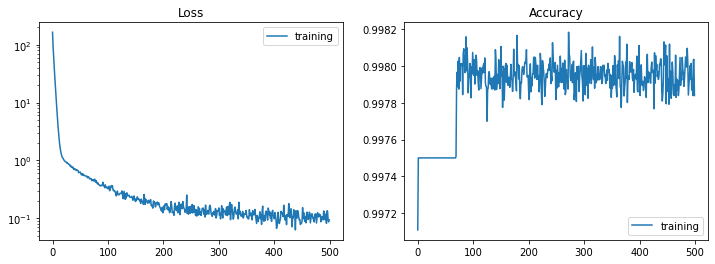

In [18]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.legend()
plt.title("Accuracy")

#### Test the net

In [6]:
sigmoid = nn.Sigmoid()
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
model.eval()

Created dataset for events from 0 to 198917


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.

In [7]:
# Loop over many events and evaluate the true positives and false positives.
# Store in arrays as:
#
#  [tp0 tp1 tp2 tp3 ... tpN], each number corresponding to a different NN threshold or classical threshold
#
tp_unet = []; fp_unet = []
tp_classical = []; fp_classical = []
#nn_thresholds = np.arange(0.05,1.0,0.1)
nn_thresholds = np.concatenate((np.logspace(-4,-0.1,500), np.logspace(-0.1,0,500)))
#nn_thresholds = np.logspace(-3,0,1000)
classical_thresholds = np.arange(600,7000,10)
evts = np.arange(100000,101000)
for evt in evts:
    
    # Get the event and truth.
    evt_item = dataset_train[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1][0]
    
    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    
    # Compute the TP and FP values for unet.
    temp_tp = []; temp_fp = []
    for th in nn_thresholds:
        pred = (prob > th)
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (fp + tn) > 0): fp = fp / (fp + tn)
        else: fp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_unet.append(temp_tp)
    fp_unet.append(temp_fp)
    
    # Compute the TP and FP values for the classical threshold.
    temp_tp = []; temp_fp = []
    for th in classical_thresholds:
        #pred = (evt_arr > th)
        pred = np.zeros(evt_arr.shape)
        pred[np.unravel_index(np.argmax(evt_arr),evt_arr.shape)] = 1
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (tp + tn) > 0): fp = fp / (fp + tn)
        else: tp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_classical.append(temp_tp)
    fp_classical.append(temp_fp)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
    
tp_unet = np.array(tp_unet)
fp_unet = np.array(fp_unet)
tp_classical = np.array(tp_classical)
fp_classical = np.array(fp_classical)

0% done
1% done
2% done
3% done
4% done
5% done
6% done
7% done
8% done
9% done
10% done
11% done
12% done
13% done
14% done
15% done
16% done
17% done
18% done
19% done
20% done
21% done
22% done
23% done
24% done
25% done
26% done
27% done
28% done
29% done
30% done
31% done
32% done
33% done
34% done
35% done
36% done
37% done
38% done
39% done
40% done
41% done
42% done
43% done
44% done
45% done
46% done
47% done
48% done
49% done
50% done
51% done
52% done
53% done
54% done
55% done
56% done
57% done
58% done
59% done
60% done
61% done
62% done
63% done
64% done
65% done
66% done
67% done
68% done
69% done
70% done
71% done
72% done
73% done
74% done
75% done
76% done
77% done
78% done
79% done
80% done
81% done
82% done
83% done
84% done
85% done
86% done
87% done
88% done
89% done
90% done
91% done
92% done
93% done
94% done
95% done
96% done
97% done
98% done
99% done


Text(0, 0.5, 'True positive rate')

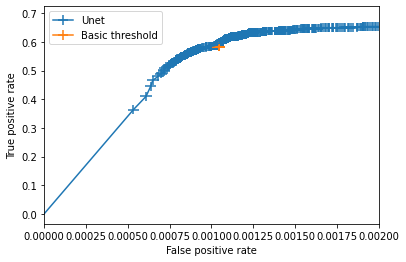

In [21]:
tp_rate_unet = np.mean(tp_unet,axis=0)
tp_err_unet = np.std(tp_unet,axis=0)/np.sqrt(tp_unet.shape[0])
fp_rate_unet = np.mean(fp_unet,axis=0)
fp_err_unet = np.std(fp_unet,axis=0)/np.sqrt(fp_unet.shape[0])
tp_rate_classical = np.mean(tp_classical,axis=0)
tp_err_classical = np.std(tp_classical,axis=0)/np.sqrt(tp_classical.shape[0])
fp_rate_classical = np.mean(fp_classical,axis=0)
fp_err_classical = np.std(fp_classical,axis=0)/np.sqrt(fp_classical.shape[0])

plt.errorbar(fp_rate_unet,tp_rate_unet,xerr=fp_err_unet,yerr=tp_err_unet,label='Unet')
plt.errorbar(fp_rate_classical,tp_rate_classical,xerr=fp_err_classical,yerr=tp_err_classical,label='Basic threshold')
plt.xlim([0,0.002])
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

In [10]:
print("NN ------------------")
for tpr,fpr,th in zip(tp_rate_unet,fp_rate_unet,nn_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))
print("Classical threshold ------------------")
for tpr,fpr,th in zip(tp_rate_classical,fp_rate_classical,classical_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))

NN ------------------
[Threshold 0.0001] TP = 0.675, FP = 0.004423558897243059
[Threshold 0.00010181590626169435] TP = 0.675, FP = 0.004398496240601454
[Threshold 0.00010366478767890119] TP = 0.675, FP = 0.0043508771929824065
[Threshold 0.0001055472430495345] TP = 0.675, FP = 0.0043283208020049625
[Threshold 0.00010746388204511664] TP = 0.675, FP = 0.00430827067669168
[Threshold 0.00010941532540823375] TP = 0.675, FP = 0.004270676691729275
[Threshold 0.000111402205153575] TP = 0.675, FP = 0.004230576441102709
[Threshold 0.00011342516477262434] TP = 0.675, FP = 0.004197994987468625
[Threshold 0.00011548485944206743] TP = 0.675, FP = 0.0041553884711779
[Threshold 0.00011758195623598486] TP = 0.675, FP = 0.004112781954887173
[Threshold 0.00011971713434189669] TP = 0.675, FP = 0.00409523809523805
[Threshold 0.00012189108528073223] TP = 0.675, FP = 0.0040601503759398055
[Threshold 0.0001241045131307921] TP = 0.675, FP = 0.004025062656641562
[Threshold 0.00012635813475577945] TP = 0.675, FP 

In [ ]:
evt_plt = 100001
evt_item = dataset_train[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1][1]

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
#target = torch.tensor(evt_lbl).float().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

# Threshold
# prob = np.zeros(evt_arr.shape)
# prob[evt_arr > 80] = 1

# Determine number of correct pixels
th = 0.2
pred = (prob > th)
nelec = int(np.sum(evt_lbl == 1))
nelec_pred = int(np.sum(pred))
nspace = int(np.sum(evt_lbl == 0))
nelec_coinc = np.sum((evt_lbl == 1) & (pred == True))
nspace_coinc = np.sum((evt_lbl == 0) & (pred == False))
print("{}/{} electrons predicted".format(nelec_pred,nelec))
print("{}/{} electrons coincided exactly".format(nelec_coinc,nelec))
print("{}/{} empty spaces coincided exactly".format(nspace_coinc,nspace))

# Information for drawing the line.
nrows = evt_arr.shape[0]
ncols = evt_arr.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
m = -2*nrows/ncols
b = 80
print("Line drawn: m = {}, b = {}".format(m,b))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event")

# xfit = np.arange(0,ncols,0.1)
# yfit = m*xfit + b
# plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

ax2 = fig.add_subplot(132)
plt.imshow(evt_lbl)
plt.colorbar()
plt.title("Target")

ax3 = fig.add_subplot(133)
#plt.imshow(np.log10(prob))
plt.imshow(prob)
plt.colorbar()
plt.title("{}/{} electrons predicted\n{}/{} electrons coincided exactly\n{}/{} empty spaces coincided exactly".format(nelec_pred,nelec,nelec_coinc,nelec,nspace_coinc,nspace))

#### Test loss function

In [ ]:
# Construct output and label arrays for 5 events.
frames,outputs,labels = [], [], []
for iframe in range(50):
    frame,label = frameset[iframe]
    frames.append(frame)
    outputs.append(label[1])
    labels.append(label)
frames = np.array(frames)
outputs = np.array(outputs)
labels = np.array(labels)
print("Frames shape is:",frames.shape)
print("Outputs shape is:",outputs.shape)
print("Labels shape is:",labels.shape)

# Convert to tensors.
outputs[outputs == 0] = 1e-10
outputs[outputs == 1] = 0.99999999
frames = torch.tensor(frames)
output = torch.tensor(np.log(outputs/(1-outputs)))
target = torch.tensor(labels)

# Compute the loss.
sigma_dist = 1
real_truth = target[:,0,:,:]
th_truth = target[:,1,:,:]
edge_truth = target[:,2,:,:]
dist = target[:,3,:,:]

final_truth = th_truth * edge_truth

wts     = torch.sum(torch.exp(-(dist)**2/(2*sigma_dist**2))*th_truth,axis=(1,2))
wt_norm = torch.sum(th_truth,axis=(1,2))
wt_norm[wt_norm == 0] = 1
wts /= wt_norm
print("Weights are: ",wts)

w_edge = 100
bce_loss = torch.nn.BCEWithLogitsLoss(reduce=False)
sigmoid = torch.nn.Sigmoid()
loss0 = bce_loss(output,final_truth)
loss1 = w_edge*sigmoid(output)*(1-edge_truth)
loss0W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0)
loss1W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss1)
loss = torch.mean(torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0 + loss1))
print("Mean loss is ",loss)
print("Mean loss0 is ",torch.mean(loss0))
print("Mean loss0W is ",torch.mean(loss0W))
print("Mean loss1 is ",torch.mean(loss1))
print("Mean loss1W is ",torch.mean(loss1W))

In [ ]:
dist_mod = torch.sum(torch.abs(dist*(edge_truth-1)),axis=(1,2))
dist_mod.shape

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(16.0)

ax1 = fig.add_subplot(241)
if(show_sum): plt.imshow(np.sum(np.array(sigmoid(output)),axis=0),interpolation=None)
else: plt.imshow(np.array(sigmoid(output[iframe])),interpolation=None)
plt.colorbar()
plt.title("sigmoid(Output)")

ax2 = fig.add_subplot(242)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(243)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax4 = fig.add_subplot(244)
if(show_sum): plt.imshow(np.sum(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))),axis=0))
else: plt.imshow(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))[iframe]))
plt.colorbar()
plt.title("Distance")

ax5 = fig.add_subplot(245)
if(show_sum): plt.imshow(np.sum(np.array(loss0), axis=0))
else: plt.imshow(np.array(loss0[iframe]))
plt.colorbar()
plt.title("Loss0")

ax6 = fig.add_subplot(246)
if(show_sum): plt.imshow(np.sum(np.array(loss1),axis=0))
else: plt.imshow(np.array(loss1[iframe]))
plt.colorbar()
plt.title("Loss1")

ax7 = fig.add_subplot(247)
if(show_sum): plt.imshow(np.sum(np.array(loss0W + loss1W),axis=0))
else: plt.imshow(np.array(loss0W[iframe] + loss1W[iframe]))
# if(show_sum): plt.imshow(np.sum(np.array(dist_mod),axis=0))
# else: plt.imshow(np.array(dist_mod[iframe]))
plt.colorbar()
plt.title("LossW")

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(3.0)
fig.set_figwidth(20.0)

ax1 = fig.add_subplot(151)
if(show_sum): plt.imshow(np.sum(frames,axis=0)/np.max(np.sum(frames,axis=0)),interpolation=None)
else: plt.imshow(np.array(frames[iframe]),interpolation=None)
plt.colorbar()
plt.title("Event")

ax2 = fig.add_subplot(152)
if(show_sum): plt.imshow(np.sum(np.array(real_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(153)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(th_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Classical threshold")

ax4 = fig.add_subplot(154)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax5 = fig.add_subplot(155)
if(show_sum): plt.imshow(np.sum(np.array(final_truth), axis=0))
else: plt.imshow(np.array(final_truth[iframe]))
plt.colorbar()
plt.title("Combined truth")

##### Test on real data

In [ ]:
# Evaluate real data
img_data_cut = img_data[-1023:,-1440:]/12
img_data_torch = torch.tensor(img_data_cut).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(img_data_torch)
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

In [ ]:
# Plot the results of the real data evaluation
logscale = False
view_row_low = -350
view_row_high = -300
view_col_low = -350
view_col_high = -300

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
if(logscale):
    plt.imshow(np.log(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high]),interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    plt.title("Scaled data (log counts)")
else:
    plt.imshow(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none') #np.log(frame))
    cbar = plt.colorbar()
    plt.title("Scaled data")

ax2 = fig.add_subplot(122);
plt.imshow(prob[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none')
plt.title("U-net output")
plt.colorbar()

In [ ]:
prob.shape

## Real data

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [ ]:
# From https://stackoverflow.com/questions/1035340/reading-binary-file-and-looping-over-each-byte
def bytes_from_file(filename, chunksize=4):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield struct.unpack('@I', chunk)[0]
            else:
                break

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/stack_1.dat"
freader = iter(bytes_from_file(datfile))

In [ ]:
img = []
for i in range(5760*4092):
    img.append(next(freader))
img = np.array(img)

In [ ]:
# Prepare for input to a NN
img_data = img.reshape([4092,5760])

In [ ]:
#plt.imshow(np.log(img.reshape([5760,4092])),vmin=9.5,vmax=10.5)
#plt.imshow(img.reshape([5760,4092])[-100:,0:100],vmin=750,vmax=10000)
plt.imshow(img_data,interpolation='none',vmin=750,vmax=15000)
plt.colorbar()

## Attempt to fit the edge

In [ ]:
noise_th = 750*12
max_th = 751*12
fit_img = np.copy(img_data)
fit_img[fit_img < noise_th] = 0
fit_img[fit_img >= noise_th] = max_th
fit_img = fit_img/np.max(fit_img)
fit_img = np.array(fit_img,dtype=np.uint8)
print("Min value:",np.min(fit_img),"; max value:",np.max(fit_img))

In [ ]:
plt.imshow(fit_img,interpolation='none')
plt.colorbar()

In [ ]:
A = fit_img
th = 0.5
nrows = A.shape[0]
ncols = A.shape[1]
ncts = np.sum(A >= th)
nzeros = np.sum(A < th)
wcts = nzeros/ncts
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]

def count_loss(x):
    m,b = x
    
    # The loss L is:
    #
    # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
    # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
    # 
    # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
    # the number of zeros.
    L = 0
    L1 = np.sum((irows < m*icols + b) & (A < th))
    L2 = np.sum((irows < m*icols + b) & (A >= th))
    L3 = np.sum((irows >= m*icols + b) & (A >= th))
    L4 = np.sum((irows >= m*icols + b) & (A < th))
    
    L = L1 - wcts*L2 + wcts*L3 - L4
    print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
    return -L

In [ ]:
initial_guess = [-nrows/ncols,nrows]
result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-6)
m,b = result.x
Lmin = result.fun
print("m = ",m,"b = ",b,"Lmin=",Lmin)

In [ ]:
plt.imshow(fit_img,interpolation='none')
xfit = np.arange(ncols)
yfit = m*xfit + b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

In [ ]:
# Plot the loss in a range near the parameters.
mrng = np.arange(m-0.1*m, m+0.1*m, 0.2*m/100)
Lrng = np.array([count_loss([mval,b])/Lmin for mval in mrng])
print(mrng)
plt.plot(mrng,Lrng)
plt.xlabel("Parameter m")
plt.ylabel("Relative loss L/L(m$_0$)")

In [ ]:
def auto_canny(image, sigma=0.1):
    v = 255/2. #np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    print("Lower =",lower,", upper=",upper)
    return cv2.Canny(image, lower, upper)

edges = auto_canny(image=fit_img) 

# Show images for testing
#cv2.imshow('edges', edges)
plt.imshow(edges)
plt.colorbar()

## Fit the noise peak

In [ ]:
fscale = 12.

def gauss(x, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2)

def gaussexpo(x, amp, mu, sigma, const, mean, x0):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2) + const * np.exp(-(x-x0)/mean)


yh, xh, _ = plt.hist(img[(img/fscale > 7000/fscale) & (img/fscale < 9300/fscale)]/fscale,bins=50)
xh = (xh[1:] + xh[0:-1])/2

#popt, pcov = curve_fit(gaussexpo, xh, yh, [3.0e6, 8200, 300, 1000, 10, -1])
popt, pcov = curve_fit(gauss, xh, yh, [3.0e6, 8200/fscale, 135/fscale])
xfit = np.linspace(xh[0],xh[-1],100)
plt.plot(xfit,gauss(xfit,*popt))
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
print("Fit mean:",popt[1])
print("Fit sigma:",popt[2])

In [ ]:
fn = np.load("frame_4855x4855_11occ.npz")
img_sim = fn['frame'].flatten()

In [ ]:
#plt.hist(img[(img > 0) & (img < 10000)],bins=50)
plt.hist(img_sim,bins=50,range=[0,10000],label='MC')
plt.hist(img/12,bins=50,range=[0,10000],label='data')

plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
plt.legend()
print("Total pixels:",len(img))
print("Counts near peak",np.sum(img[(img > 29) & (img < 33)]))

In [ ]:
177383690/935130034.

In [ ]:
plt.hist(np.abs(np.random.normal(loc=0,scale=50,size=1000)))

## Train a network (single-electrons)

In [ ]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-4   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 74      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/model_10cells_noise_100k_74.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
dataset_train = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=0)
dataset_val   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        tr.val(model, epoch, val_loader)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_10cells_noise_100k_{}.pt".format(modeldir,epoch))

### Plot the training and validation loss

In [ ]:
# Plot the training and validation losses.
tloss = np.loadtxt("train.txt")
vloss = np.loadtxt("val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
model.eval()

In [ ]:
evts = np.arange(80000,80100)
df, evts = emsim_utils.construct_evt_dataframe(dset,evts,model)

In [ ]:
axes = pd.plotting.scatter_matrix(df[["error_r_NN","error_r_maxpt","error_r_3x3","error_r_3x3_th","error_r_5x5","error_r_5x5_th"]], 
                                  figsize=[15,15], alpha=0.2, hist_kwds={'bins':100})
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        #if i == j:  # only the histograms
        #ax.set_yscale('log')
        ax.set_xlim(0,0.01)
        ax.set_ylim(0,0.01)
            
plt.savefig("errors_scatter_matrix.pdf")

In [ ]:
err_cut = 0.02
sigma_cut = 1e9
plt.hist(df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN,alpha=0.8,bins=50,color='blue',label='NN error')
plt.hist(df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3,alpha=0.8,bins=50,color='green',label='3x3 centroid')
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("counts/bin")
plt.yscale('log')
plt.legend()

In [ ]:
print("Mean 3x3 error:",df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3.mean())
print("Mean NN error: ",df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN.mean())

In [ ]:
df["error_r_diff"] = df.error_r_NN - df.error_r_3x3

In [ ]:
err_diff_cut = 0.005
plt.hist(df[(df.error_r_diff < err_diff_cut) & (df.error_r_diff > -err_diff_cut) & (df.sigma_r_NN < 0.011)].error_r_diff,alpha=0.8,bins=50,color='blue',label='NN error')
plt.yscale("log")
plt.xlabel("error difference (NN - 3x3-method)")

In [ ]:
# Save dataframe and event arrays.
df.to_pickle("evts_80000_to_90000.pkl")
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

In [ ]:
df = pd.read_pickle("evts_80000_to_90000.pkl")

In [ ]:
cut_sigma = 0.011

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r_NN < cut_sigma].error_r_NN,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r_NN < cut_sigma].sigma_r_NN,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

In [ ]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.003,0.4,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r_NN < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r_NN.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r_NN.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net for individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
softmax = nn.Softmax(dim=1)
model.eval()

In [ ]:
evt_plt = 81001
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = emnet.PIXEL_ERR_RANGE_MIN - dset.add_shift*emnet.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = emnet.PIXEL_ERR_RANGE_MAX + dset.add_shift*emnet.PIXEL_SIZE
ERR_PIXEL_SIZE = emnet.PIXEL_SIZE*(2*dset.add_shift+1)/emnet.ERR_SIZE

x_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
y_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2

xbin = int(emnet.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,emnet.ERR_SIZE-1)

ybin = int(emnet.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,emnet.ERR_SIZE-1)

print("Computed index:",(ybin*emnet.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
ipred = np.argmax(prob)
xpred = int(ipred % emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
ypred = int(ipred / emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
#print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))

# Compute the sigmas of the distribution.
sigma_x0, sigma_y0 = emsim_utils.compute_sigmas(prob,ERR_PIXEL_SIZE,SHIFTED_ERR_RANGE_MIN)
popt, pcov = emsim_utils.fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0,ERR_PIXEL_SIZE)
fit_data = emsim_utils.mult_gaussFun_Fit((x_errgrid,y_errgrid),*popt).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
print("Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:")
print("A = {}".format(popt[0]))
print("(x0, y0) = ({},{})".format(popt[1],popt[2]))
print("(sigma_x, sigma_y) = ({},{})".format(popt[3]**0.5,popt[4]**0.5))
print("C = {}".format(popt[5]))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(132)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within prediction grid")

ax3 = fig.add_subplot(133)
plt.imshow(fit_data)
plt.colorbar()
plt.title("2D Gaussian fit")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")


#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

### Evaluate a dataset for noise

In [ ]:
Nevts = 1000
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset and examine individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl,evt_err_ind = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

### Plot events directly from dataframe

In [ ]:
df = pd.read_pickle("dataframes/EM_4um_back_10M_300keV.pkl")

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))